In [1]:
import os
import astropy
import requests
import pandas as pd
import numpy as np
import lightkurve as lk 
from scipy.interpolate import interp1d
from astropy.modeling import models, fitting
import matplotlib.pyplot as plt
import emcee
import sys
import csv
from astropy.timeseries import LombScargle
from os.path import basename, exists

# change these paths to wherever you have the files
# sys.path.insert(1,'/Users/neisner/Documents/code/utils/')
import filters # Suzanne's functions
import norm

# change these paths to wherever you have the files
# sys.path.insert(1,'/Users/neisner/Documents/code/ETV')
import etv_functions # Nora's functions 

%matplotlib inline

In [2]:
from IPython.display import display, HTML, Javascript, clear_output

display(HTML("<style>.container { width:99% !important; }</style>"))  # Jupyter 6
display(HTML("<style>.jp-Notebook { --jp-notebook-max-width: 98%; }</style>"))  # Jupyter 7

# define the paths where the data will be stores - NEED TO CHANGE THIS TO YOUR OWN PATH
outfile_base = './etv_out'  # for ETV
lk_download_dir = 'C:/dev/_juypter/PH_TESS_LightCurveViewer/data'  

# A command from shell that can be run to notify users, e.g., fitting is finished. Use "echo" if you do not have one
NOTIFY_CMD = "win-notify.bat"

if hasattr(lk, "conf"):  # default download dir
    lk.conf.cache_dir = lk_download_dir
if hasattr(lk.search, "sr_cache"):   # PR for persistent query result cache
    lk.search.sr_cache.cache_dir = lk_download_dir  # None
    lk.search.sr_cache.expire_second = 86400

## Looking for ETVs in TIC 141685465

- Gaia DR3 NSS: AB (Acceleration model), SB1 (period ~= EB Period)

In [3]:
# define the plotting parameters

figsize = (8,4)

In [4]:
# import the data

# choose a TIC ID to analyze
ticid = 141685465

# define the paths where the data will be stores - NEED TO CHANGE THIS TO YOUR OWN PATH
outfile_path = f"{outfile_base}/tic{ticid}_etv_primary.csv"
outfile_path_s = f"{outfile_base}/tic{ticid}_etv_secondary.csv"


# import data using Lightkurve
# sr = lk.search_lightcurve('TIC {}'.format(ticid), author = 'SPOC')  
if not "../.." in sys.path:
    sys.path.append("../..")
import lightkurve_ext as lke  # at ../../
import astropy.units as u


sr = lk.search_lightcurve('TIC {}'.format(ticid))  # get long cadence data too
sr = lke.filter_by_priority(sr, author_priority=['SPOC', 'TESS-SPOC'], exptime_priority=['short', 'long', 'fast'])
# sr = sr[sr.exptime != 1800 *u.s]  # exclude 30min cadence data for now (TESS-SPOC, sectors 18, 19, 23 )
# sr = sr[np.isin(sr.author, ['SPOC', 'TESS-SPOC'])]  # exclude QLP to ensure for uniformity in the data
sr = lke._sort_chronologically(sr)  # workaround lightkurve v2.4.2+ change in sort order
display(sr)
lcc_tess = sr.download_all()
lc_tess = lcc_tess.stitch()
# lc_tess = lc_tess.truncate(None, 1450)  # use data from sectors 2 - 3 for now


search_result = lc_tess

time = search_result.time.value
flux = search_result.flux.value
fluxerr = search_result.flux_err.value
len(search_result)

SearchResult containing 34 data products.

 #     mission     year   author  exptime target_name distance proposal_id
                                     s                 arcsec             
--- -------------- ---- --------- ------- ----------- -------- -----------
  0 TESS Sector 01 2018 TESS-SPOC    1800   141685465      0.0         N/A
  1 TESS Sector 02 2018 TESS-SPOC    1800   141685465      0.0         N/A
  2 TESS Sector 03 2018 TESS-SPOC    1800   141685465      0.0         N/A
  3 TESS Sector 04 2018      SPOC     120   141685465      0.0         N/A
  4 TESS Sector 05 2018      SPOC     120   141685465      0.0         N/A
  5 TESS Sector 06 2018      SPOC     120   141685465      0.0         N/A
  6 TESS Sector 07 2019      SPOC     120   141685465      0.0         N/A
  7 TESS Sector 08 2019      SPOC     120   141685465      0.0         N/A
  8 TESS Sector 09 2019      SPOC     120   141685465      0.0         N/A
  9 TESS Sector 10 2019      SPOC     120   141685465      0.0         N/A
...            ...  ...       ...     ...         ...      ...         ...
 24 TESS Sector 39 2021 TESS-SPOC     600   141685465      0.0         N/A
 25 TESS Sector 61 2023      SPOC     120   141685465      0.0      G05003
 26 TESS Sector 62 2023      SPOC     120   141685465      0.0      G05003
 27 TESS Sector 63 2023      SPOC     120   141685465      0.0      G05003
 28 TESS Sector 64 2023      SPOC     120   141685465      0.0      G05003
 29 TESS Sector 65 2023      SPOC     120   141685465      0.0      G05003
 30 TESS Sector 66 2023       QLP     200   141685465      0.0         N/A
 31 TESS Sector 67 2023      SPOC     120   141685465      0.0      G05003
 32 TESS Sector 68 2023      SPOC     120   141685465      0.0      G05003
 33 TESS Sector 69 2023      SPOC     120   141685465      0.0      G05003
Length = 34 rows

C:\pkg\_winNonPortables\miniforge3\envs\my_lk_plus\lib\site-packages\lightkurve\collections.py:213: LightkurveWarning: The following columns will be excluded from stitching because the column types are incompatible: {'sap_flux', 'sap_bkg', 'sap_bkg_err'}
  warnings.warn(


374260

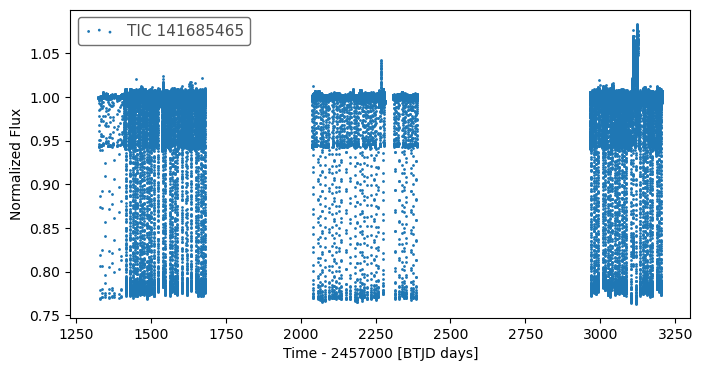

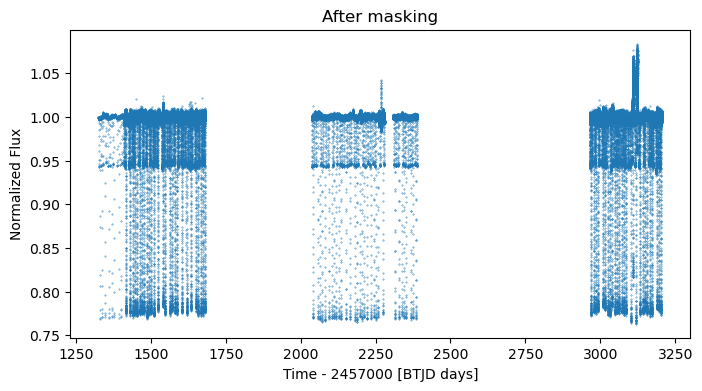

In [5]:
%matplotlib inline
# %matplotlib widget

time = search_result.time.value
flux = search_result.flux.value
fluxerr = search_result.flux_err.value
len(search_result)

# mask out data you don't like...

fig, ax = plt.subplots(figsize=figsize)
search_result.scatter(ax = ax)

mask = time < 0  #( time > 54950) & (time < 54963)  #  truncate weird spikes at the beginning of Kepler data  
# the spikes in sectors 66 (BTJD 3100 - 3125) probably have no significant effect (probably due to imperfect background subtraction)
# mask = flux < 0.85    # remove occassional outliers

time = time[~mask]
flux = flux[~mask]
fluxerr = fluxerr[~mask]

# make sure that therte are no nans!

finite_mask = np.isfinite(time) * np.isfinite(flux) * np.isfinite(fluxerr)

# make a dictionary of the data 

data = pd.DataFrame({'time': time[finite_mask], 'flux': flux[finite_mask], 'err': fluxerr[finite_mask]})

ax2 = plt.figure(figsize=figsize).gca()
ax2.scatter(data.time, data.flux, s=0.1);
ax2.set_ylabel(ax.get_ylabel())
ax2.set_xlabel(ax.get_xlabel())
ax2.set_title("After masking");

In [ ]:
do_bls = False

if do_bls:
    if not "../.." in sys.path:
        sys.path.append("../..")
    import lightkurve_ext_pg_runner as lke_pg_runner  # at ../../

    bls_result = lke_pg_runner.run_bls(
        search_result.remove_nans(),
        pg_kwargs=dict(
            minimum_period=1, maximum_period=20,
            frequency_factor=1,            
            duration=[3.4957 / 24 * f for f in [0.975, 1, 1.025, 1.05, 1.1, 1.15,]],  # based on observed primary eclipse duration for better fit
        ),
    )
    !$NOTIFY_CMD  "BLS Done"

In [ ]:
# Visaully compare different candidate period

# ax = search_result.normalize().fold(epoch_time=1471.4196, period=8.418132651611877).truncate(-0.1, 0.1).scatter(label="BLS period, frequency_factor=10");  # HWHM 0.001571020094789155
# ax = search_result.normalize().fold(epoch_time=1471.4196, period=8.418147).truncate(-0.1, 0.1).scatter(label="s0001-s0009:TCE1");

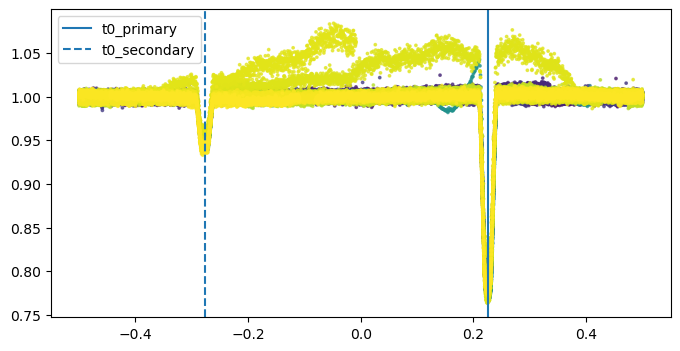

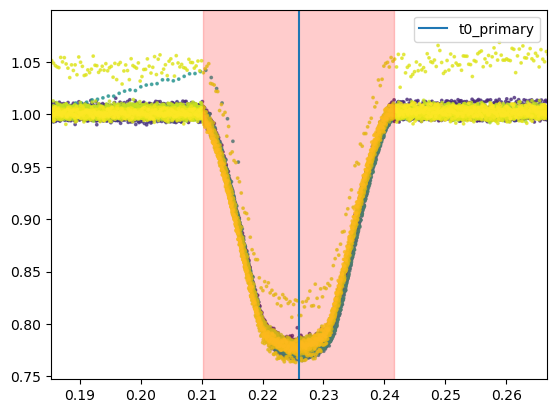

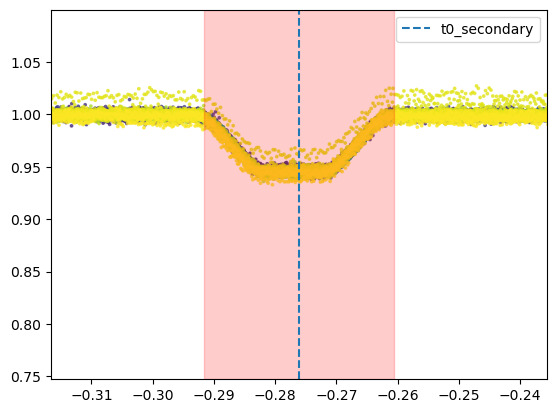

In [28]:
%matplotlib inline
# %matplotlib widget

from astropy.time import Time

# define the orbital period and the t0 

# epoch=1416.2, duration_hr=5.89364, period=7.80752, label="s0001s0069tce1", transit_depth_percent=22.4132,
# epoch=1412.28, duration_hr=5.81014, period=7.807509999999999, label="s0001s0069tce2", transit_depth_percent=5.4490,
# Gaia DR3 SB1: 7.80746191064862050
# MCMC on df_primary: 7.807512880217885

# FILL-IN THE eclipse epoch / period, 
period - 7.807513  # MCMC


t0_primary = 1416.20
t0_secondary = 1412.28


# convert epoch from BTJD to commonly mjd used here
# t0_primary = Time(t0_primary, format="btjd").to_value("mjd")
# t0_secondary = Time(t0_secondary, format="btjd").to_value("mjd")

# Move t0 to the first dip in the data (some of the subsequent codes, espically fit_each_eclipse(), assumes that)
t0_primary = t0_primary - int((t0_primary - data['time'][0]) / period) * period
if t0_secondary is not None:
    t0_secondary = t0_secondary - int((t0_secondary - data['time'][0]) / period) * period

duration_hr_primary = 5.89364  
duration_hr_secondary = 5.81014

t0_for_plotting = 0  # keep 0 for plotting purposes
if t0_secondary is not None:
    t0_for_plotting = t0_primary - np.abs(t0_primary - t0_secondary) * 0.45  # use a custom one so that the eclipses are not near the edge (-0.5 or +0.5)

phase = etv_functions.phase_data(data['time'], t0_for_plotting, period)

fig, ax = plt.subplots(figsize = (8,4))

plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])

# add the phase to the dataframe
data['phase'] = phase

plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
if t0_secondary is not None:
    plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
plt.legend()
# plt.ylim(0.535, 0.55)
# plt.xlim(-0.5, 0.1)
plt.show();

plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])
plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
t1_p, t4_p = etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] - 0.5 * duration_hr_primary / 24/ period, etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] + 0.5 * duration_hr_primary / 24/ period 
plt.xlim(t1_p - 0.025, t4_p + 0.025);
plt.axvspan(t1_p, t4_p, color="red", alpha=0.2);plt.legend();
# plt.ylim(0.75, 0.85);
plt.show()

if t0_secondary is not None:
    plt.scatter(phase,data['flux'], s = 3, alpha = 0.7, c = data['time'])
    plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
    t1_s, t4_s = etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] - 0.5 * duration_hr_secondary / 24/ period, etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] + 0.5 * duration_hr_secondary / 24/ period 
    plt.xlim(t1_s - 0.025, t4_s + 0.025);
    plt.axvspan(t1_s, t4_s, color="red", alpha=0.2);plt.legend();
    plt.legend();
    # plt.ylim(0.975, 1.005);
    plt.show()

### Compare folded plots across sectors

In [ ]:
with plt.style.context(lk.MPLSTYLE):
    fig, axs = plt.subplots(1, len(lcc_tess), figsize=(4 * len(lcc_tess), 3), sharey=True);
    if isinstance(axs, plt.Axes):
        axs = [axs]
    for i, lc in enumerate(lcc_tess):
        lc_f = lc.select_flux("flux").normalize(unit="percent").fold(period=period, epoch_time=t0_primary)
        lc_f = lc_f.truncate(-duration_hr_primary * 2 / 24, duration_hr_primary * 2 / 24)
        ax = lc_f.scatter(ax=axs[i], s=1, label=f"S.{lc_f.sector}");
        ax.legend(loc="lower right");
        if i > 0: 
            ax.set_ylabel(None)
            ax.set_xlabel(None)
    fig.suptitle(f"{lc.label}, folded around primary eclipses");
plt.tight_layout();

# ---
with plt.style.context(lk.MPLSTYLE):
    fig, axs = plt.subplots(1, len(lcc_tess), figsize=(4 * len(lcc_tess), 3), sharey=True);
    if isinstance(axs, plt.Axes):
        axs = [axs]
    for i, lc in enumerate(lcc_tess):
        lc_f = lc.select_flux("flux").normalize(unit="percent").fold(period=period, epoch_time=t0_secondary)
        lc_f = lc_f.truncate(-duration_hr_secondary * 2 / 24, duration_hr_secondary * 2 / 24)
        ax = lc_f.scatter(ax=axs[i], s=1, label=f"S.{lc_f.sector}");
        ax.legend(loc="lower right");
        if i > 0: 
            ax.set_ylabel(None)
            ax.set_xlabel(None)
    fig.suptitle(f"{lc.label}, folded around secondary eclipses");
plt.tight_layout();

### Detrend (optional)

- detrended flux is in `flux_detrended`, and won't be used in subsequent work by default

In [ ]:
# show data to visualize what's changed in each step below
data  

In [ ]:
# phase fold the data and create an appoximate binary model (top) and subtract it from the data (bottom)
#_, _ , flux_sub_binary, model, _, _ = etv_functions.trend_removal_interact(period, 0, data['time'], data['flux'], data['time'], data['flux'])

data = etv_functions.trend_removal_interact(period, t0_for_plotting, data)
data

In [ ]:
# if you want to detrend the data run this line!

data = etv_functions.detrend_suz(data, T_dur = 10, plot = True)
data

In [ ]:
# plot the phase folded data here so that you know at what phase you want to cut the data to model 
fig, ax = plt.subplots(figsize = figsize)
plt.scatter(data.phase, data.flux_detrended, s = 1, label="flux_detrended")
plt.legend()
plt.show()

plt.scatter(phase,data['flux_detrended'], s = 3, alpha = 0.7, c = data['time'])
plt.axvline(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0], label="t0_primary")
plt.xlim(etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] - 0.6 * duration_hr_primary / 24/ period, etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0] + 0.6 * duration_hr_primary / 24/ period);
plt.legend();
# plt.ylim(0.75, 0.85);
plt.show()

plt.scatter(phase,data['flux_detrended'], s = 3, alpha = 0.7, c = data['time'])
plt.axvline(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0], linestyle="--", label="t0_secondary")
plt.xlim(etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] - 0.6 * duration_hr_secondary / 24/ period, etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0] + 0.6 * duration_hr_secondary / 24/ period);
plt.legend();
# plt.ylim(0.75, 0.85);
plt.show()

<span style="background-color: rgba(255, 0, 0, 0.6);"> NOTE: </span> The zoom windows below for the eclipses are made **smaller**, an attempt to reduce the complications of EW variability outside the minima (and some assymetery)

### Now that the data is ready we can start 

Primary:   1330.31728 0.22593602065702345
window_width_p (phase): 0.037743355124290424
Secondary: 1326.39728 -0.2761440252474472
window_width_s (phase): 0.0372086142590733


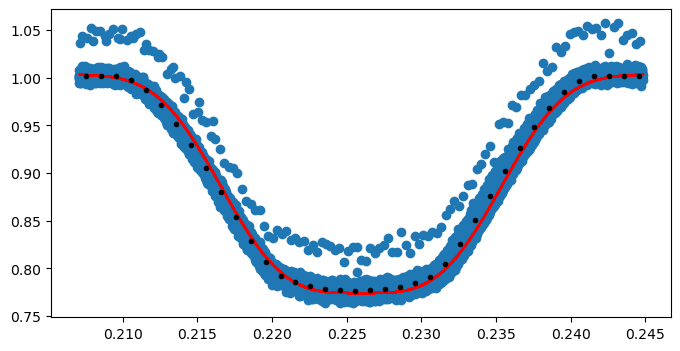

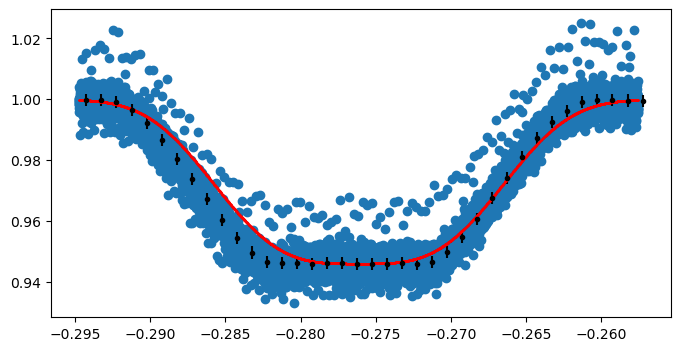

In [30]:
# define the midpoints of the primary and secondary eclipses and the window width

# if these don't look central - change them!! the eclipses should be central
midpoint_p =  etv_functions.phase_data([t0_primary], t0_for_plotting, period)[0]  # convet to time in phase
# midpoint_p -= 0.004  # the offset is added back to t0_primary (& secondary above
print('Primary:  ', t0_primary, midpoint_p)

# change depending on the width of the eclipses, default to be slightly larger than the primary eclipse
window_width_p = 1.2 * duration_hr_primary / 24 / period   # it seems to be difficult to bit model the flat bottom and the curves outside, focus on the overall shape for now
# use a shoter duration to avoid fitting the out-of-eclipse LC, which has its own variability that the model is not equipped to hanlde
# window_width_p = 0.095
print("window_width_p (phase):", window_width_p)

data_primary = data[(data['phase'] > midpoint_p - window_width_p / 2) & (data['phase'] < midpoint_p + window_width_p / 2) ]
ph_binned,flux_binned,err_binned = etv_functions.run_binning_phased(data_primary.phase, data_primary.flux, yerr=data_primary.err,nbins=1000)


if t0_secondary is not None:
    midpoint_s =  etv_functions.phase_data([t0_secondary], t0_for_plotting, period)[0]
    print('Secondary:', t0_secondary, midpoint_s)

    # the coshgauss model seems problematic, try to use a larger width to give it more shape to fit
    window_width_s = 1.2 * duration_hr_secondary / 24 / period  
    # window_width_s = 0.22
    print("window_width_s (phase):", window_width_s)
    
    data_secondary = data[(data['phase'] > midpoint_s - window_width_s / 2) & (data['phase'] < midpoint_s + window_width_s / 2) ]
    ph_binned_s,flux_binned_s,err_binned_s = etv_functions.run_binning_phased(data_secondary.phase, data_secondary.flux, yerr=data_secondary.err,nbins=1000)


### # you need initial guesses!! The order is :
# alpha0, alpha1, t0, d, Tau - CHANGE THESE TO YOUR OWN INITIAL GUESSES
# median flux, -eclipse depth, t0, related to duration, related to shape (U or V) 
# t0 in normalixed phase

start_vals = [1.004, -0.2294, midpoint_p, 0.0067, 1.896]
start_vals_s = [1.00, -0.054, midpoint_s, 0.007, 1.8]
    
# -- -- -- -- -- -- -- -- -- 
etv_functions.plot_initial_guess(data_primary, ph_binned, flux_binned, err_binned, *start_vals)
if t0_secondary is not None:
    etv_functions.plot_initial_guess(data_secondary, ph_binned_s, flux_binned_s, err_binned_s, *start_vals_s)    

In [ ]:
if False: 
    # Export the data around primary eclipses, for period analysis outside of notebook
    data_primary[["time", "flux", "err"]].to_csv(f"tmp/data_primary_{ticid}.csv", index=False)

emcee parallel enabled, use 4 CPUs.


100%|██████████████████████████████████████████████████████████| 1000/1000 [05:33<00:00,  3.00it/s]


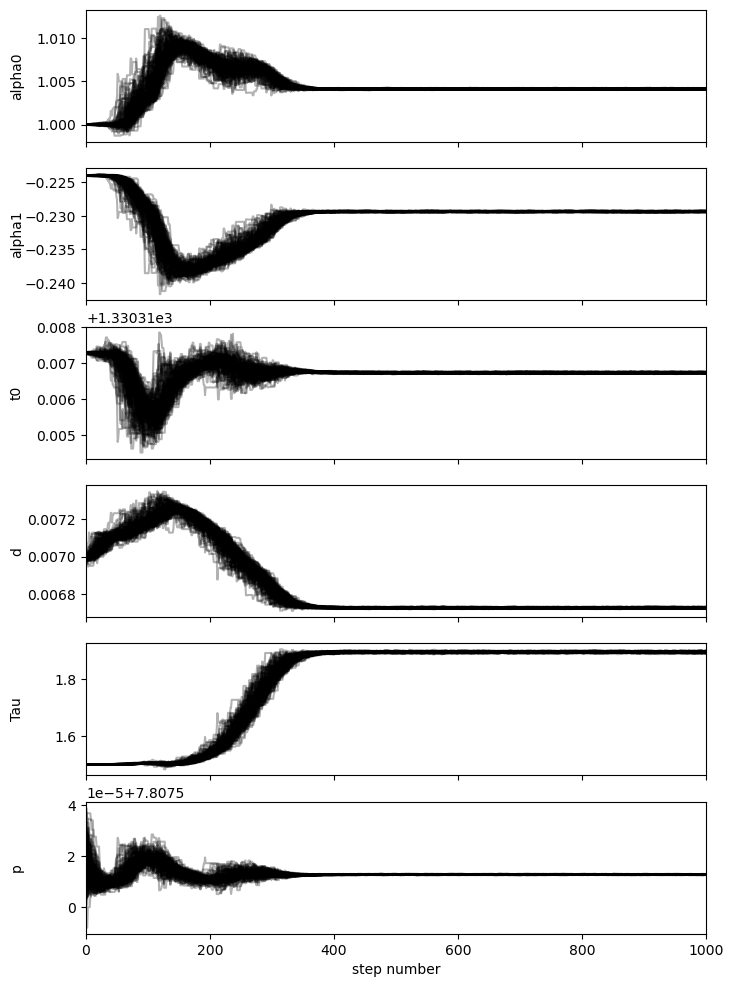

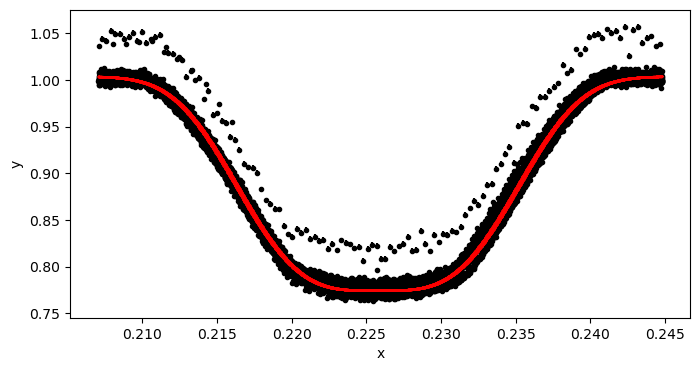

mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p = 1.0041118911923577, -0.22937478529907945, 1330.316737598602, 0.006726731235256804, 1.8960205421287133, 7.807512880217885
std_p: 9.253027159635691e-08


In [27]:
# use MCMC to refine the period

use_mcmc_to_fit_period = True


if use_mcmc_to_fit_period:
    import etv_functions_with_period as etvp

    etv_functions.enable_info_log_for_jupyter()
        
    # MCMC result
    # mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p = 1.0041118911923577, -0.22937478529907945, 1330.316737598602, 0.006726731235256804, 1.8960205421287133, 7.807512880217885
    # std_p: 9.253027159635691e-08
    mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p, fit_params_p_stats = etvp.run_mcmc_initial_fit_p(
        data_primary[:],
        [1.00, -0.224, t0_primary, 0.007, 1.5, 7.807520],
        nruns=1000, discard=600, 
        # nruns=20, discard=1, 
        pool=-2,
        plot_chains=True,
        plot=True,
        also_return_stats=True,
    )
    print("mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p = " + ", ".join([str(v) for v in [mean_alpha0, mean_alpha1, mean_t0_time, mean_d, mean_Tau, mean_p]]))
    print("std_p:", fit_params_p_stats["std_p"])
    !$NOTIFY_CMD "Fitting period done."

emcee parallel enabled, use 4 CPUs.


100%|██████████████████████████████████████████████████████████| 1000/1000 [01:34<00:00, 10.62it/s]


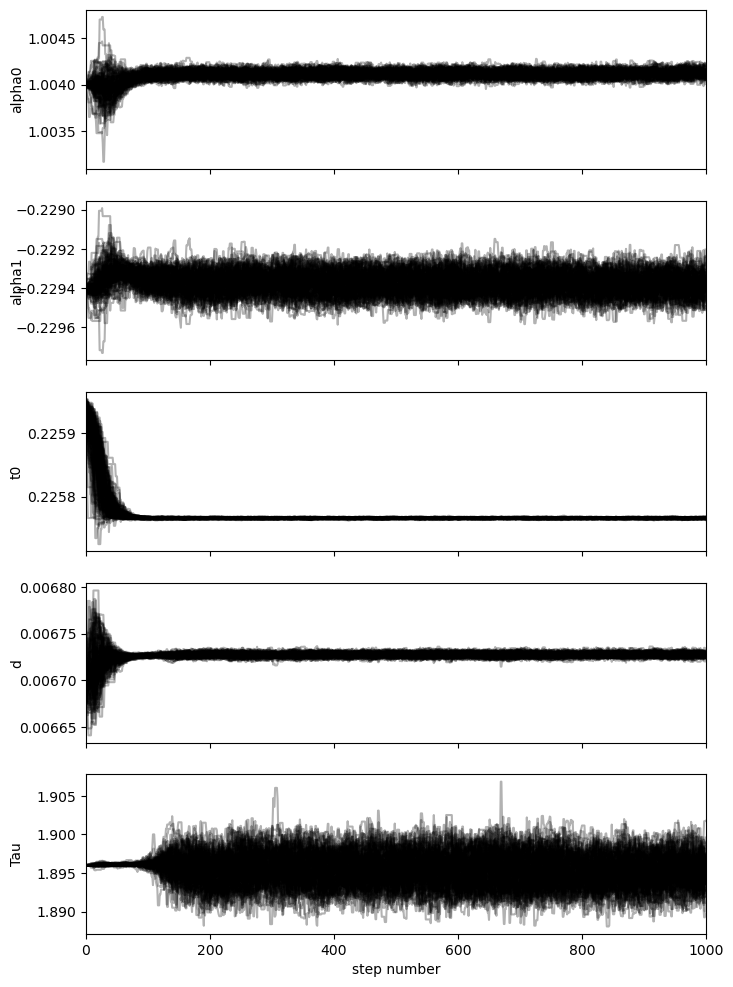

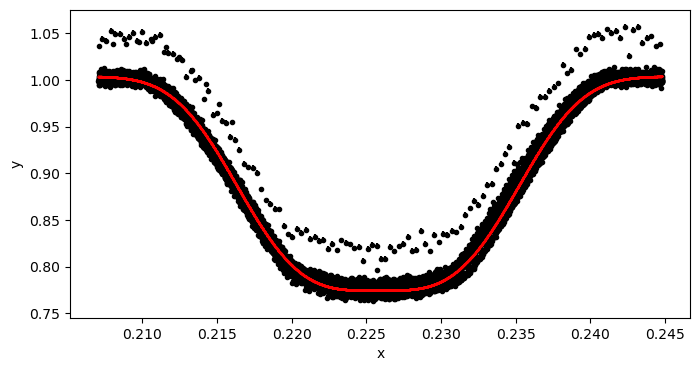

emcee parallel enabled, use 4 CPUs.


100%|██████████████████████████████████████████████████████████| 1000/1000 [01:32<00:00, 10.86it/s]


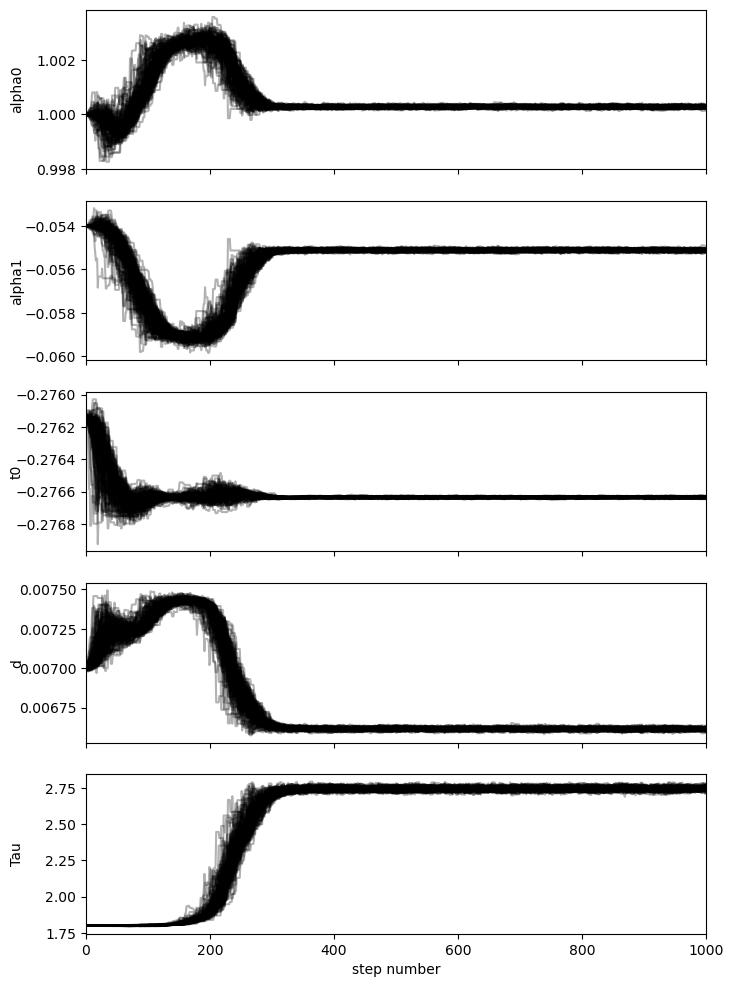

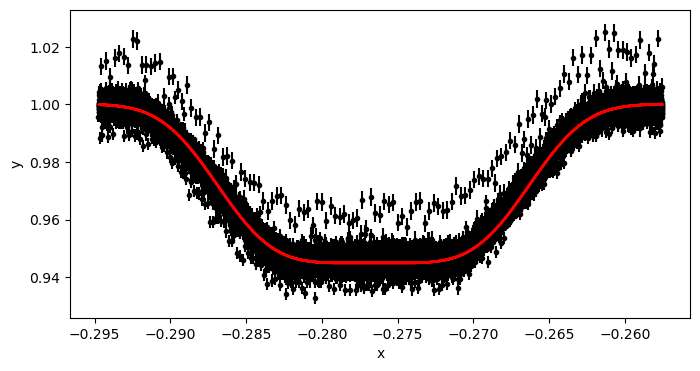

In [31]:
# run the initial model fit using MCMC for the primary and secondary eclipses 
run_init_fit = True

if run_init_fit:
    etv_functions.enable_info_log_for_jupyter()
    mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = etv_functions.run_mcmc_initial_fit(data_primary, start_vals, nruns = 1000, pool=-2, plot_chains = True , plot = True)
    if t0_secondary is not None:
        mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = etv_functions.run_mcmc_initial_fit(data_secondary, start_vals_s, nruns = 1000, pool=-2, plot_chains = True, plot = True)
    !$NOTIFY_CMD "Initial fit done"

In [ ]:
if not run_init_fit:  # case init fit has been previously saved and to be reussed
    print("Use pre-defined inital model params:")
    # initial fit params from TESS data
    mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = 1.0041152122611432, -0.22937734286775174, 0.22576610318860718, 0.006727501159327957, 1.895242770545491
    mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = 1.0002786053716999, -0.05512143769259481, -0.2766361703541277, 0.0066153796957013015, 2.743461682435779

    etv_functions.plot_initial_guess(data_primary, ph_binned, flux_binned, err_binned, *[mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau])
    etv_functions.plot_initial_guess(data_secondary, ph_binned_s, flux_binned_s, err_binned_s, *[mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s])    

In [32]:
print("Initial model params:")  # For information, and they can be copied to the cell above for future reuse

print("mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = " + ", ".join([str(v) for v in [mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau]]))
if t0_secondary is not None:
    print("mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = " + ", ".join([str(v) for v in [mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s]]))

Initial model params:
mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau = 1.0041152122611432, -0.22937734286775174, 0.22576610318860718, 0.006727501159327957, 1.895242770545491
mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s = 1.0002786053716999, -0.05512143769259481, -0.2766361703541277, 0.0066153796957013015, 2.743461682435779


240

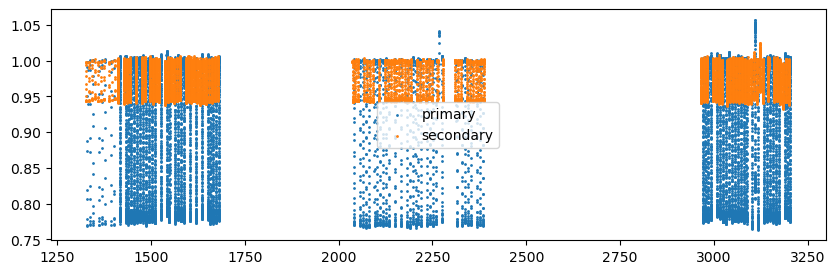

In [33]:
fig = plt.subplots(figsize=(10, 3), sharex=True)
plt.scatter(data_primary.time,data_primary.flux , s = 1, label = 'primary')
if t0_secondary is not None:
    plt.scatter(data_secondary.time,data_secondary.flux , s = 1, label = 'secondary')
plt.legend()

# calculate the number of transits there are within the data 
n_transits = int((max(data_primary.time) - min(data_primary.time)) / period)
n_transits

1330.31728 7.80752 1330.31728


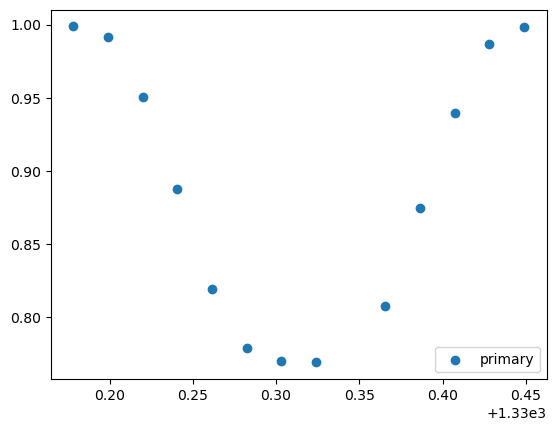

1330.31728 7.80752 1338.1248


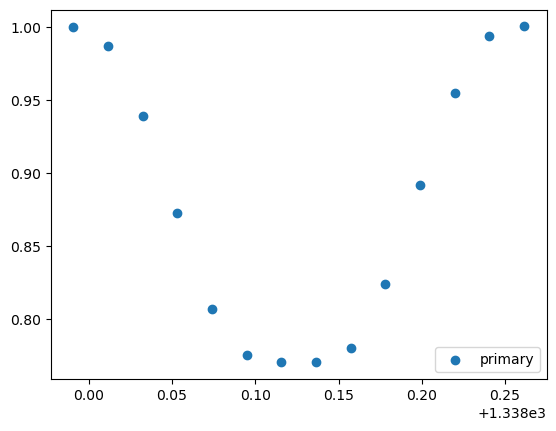

1330.31728 7.80752 1345.93232


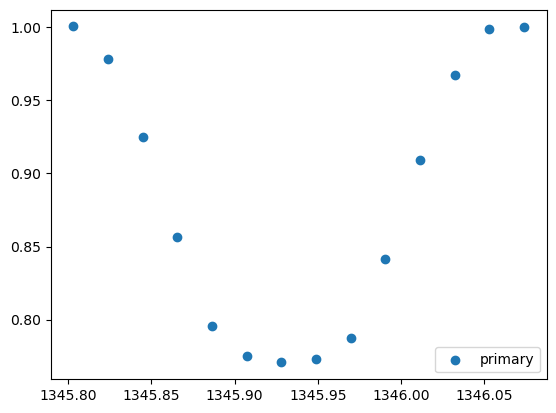

1326.39728 7.80752 1326.39728


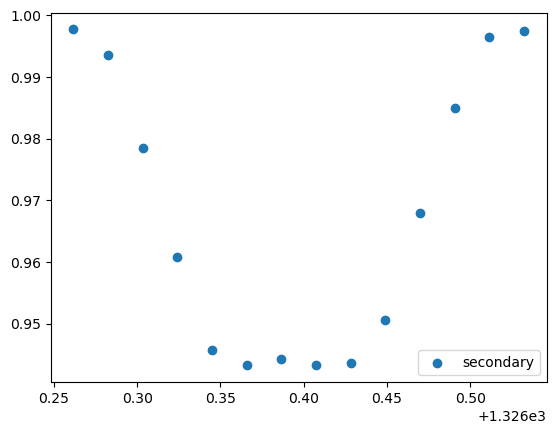

1326.39728 7.80752 1334.2048


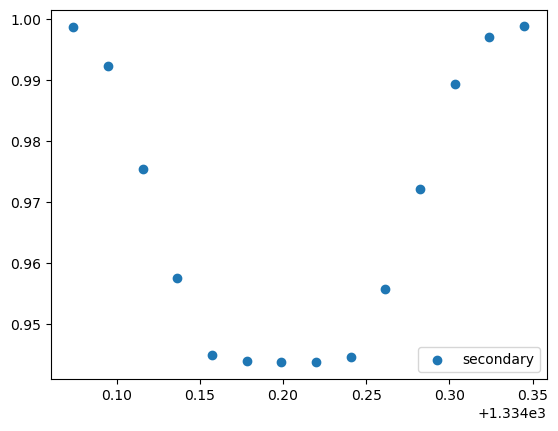

1326.39728 7.80752 1342.0123199999998


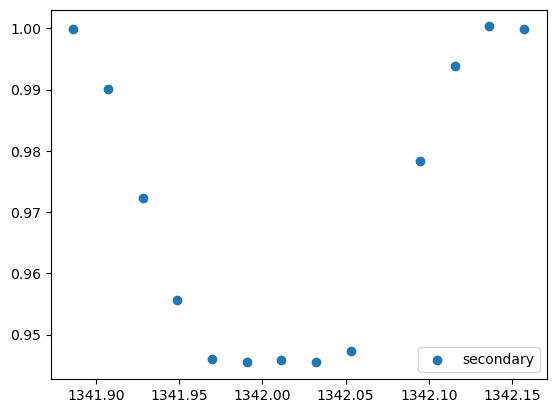

In [34]:
tr_index = range(0,n_transits)

for i in tr_index[0:3]:        
    transit_time = t0_primary+(period*i)
    x = np.array(data_primary.time)
    y = np.array(data_primary.flux) 
    yerr = np.array(data_primary.err)
    
    print (t0_primary, period, transit_time)
    
    mask = (x > (transit_time - (0.2*period))) & (x < (transit_time + (0.2*period))) 
    
    x = np.array(x[mask])
    y = np.array(y[mask]) 
    yerr = np.array(yerr[mask])
    fig, ax = plt.subplots()
    plt.scatter(x,y, label="primary")
    plt.legend(loc="lower right")
    plt.show()
    

if t0_secondary is not None:
    for i in tr_index[0:3]:        
        transit_time = t0_secondary+(period*i)
        x = np.array(data_secondary.time)
        y = np.array(data_secondary.flux) 
        yerr = np.array(data_secondary.err)
        
        print (t0_secondary, period, transit_time)
        
        mask = (x > (transit_time - (0.2*period))) & (x < (transit_time + (0.2*period))) 
        
        x = np.array(x[mask])
        y = np.array(y[mask]) 
        yerr = np.array(yerr[mask])
        fig, ax = plt.subplots()
        plt.scatter(x,y, label="secondary")
        plt.legend(loc="lower right")
        plt.show()

Fitting individual primary eclipses...
Existing manifest file found, will skip previously processed LCs and append to end of manifest file
Number 0 has already been completed -- skip
1338.1248 1.0041152122611432 -0.22937734286775174 0.22576610318860718


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 431.40it/s]


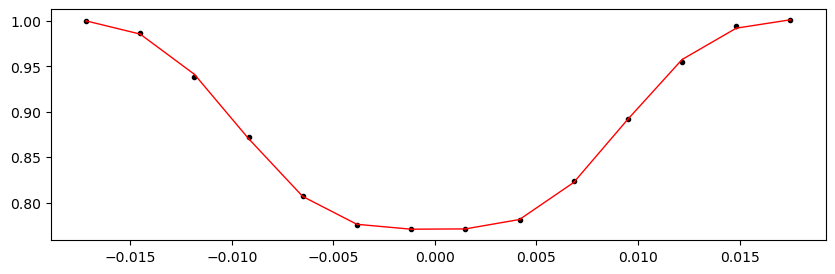

1345.93232 1.0041152122611432 -0.22937734286775174 0.22576610318860718


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 439.83it/s]


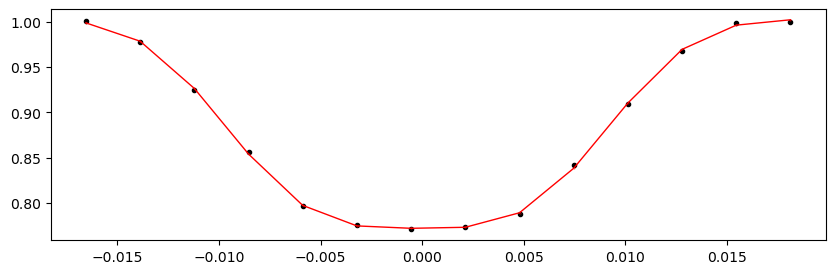

1361.54736 1.0041152122611432 -0.22937734286775174 0.22576610318860718


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 444.79it/s]


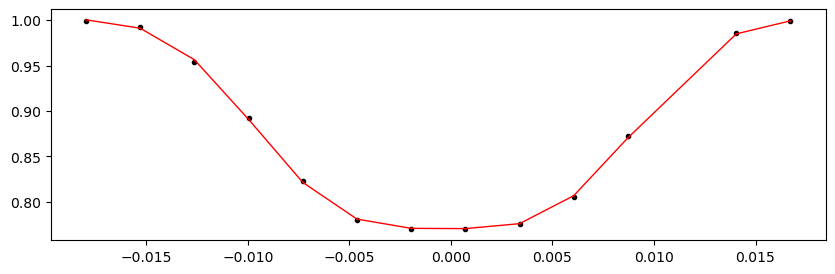

1369.3548799999999 1.0041152122611432 -0.22937734286775174 0.22576610318860718


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 444.47it/s]


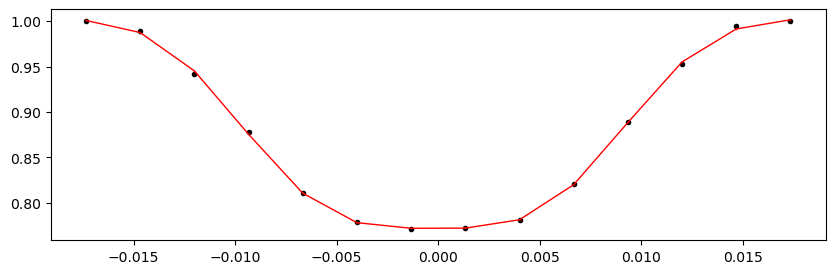

Time 1377.1624 does not have enough data points: 12
Time 1392.77744 does not have enough data points: 12
Time 1400.58496 does not have enough data points: 11
1416.2 1.0041152122611432 -0.22937734286775174 0.22576610318860718


100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 305.20it/s]


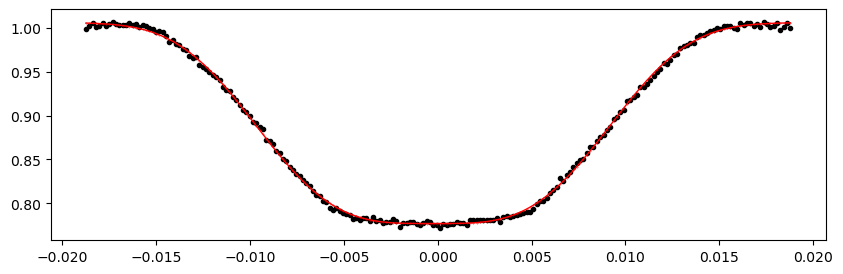

1431.81504 1.0041152122611432 -0.22937734286775174 0.22576610318860718


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 328.00it/s]


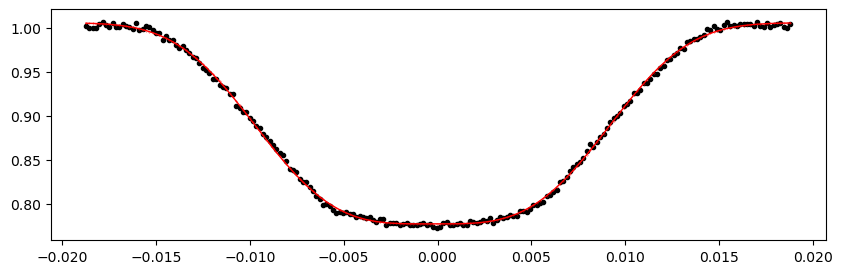

1439.62256 1.0041152122611432 -0.22937734286775174 0.22576610318860718


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 329.34it/s]


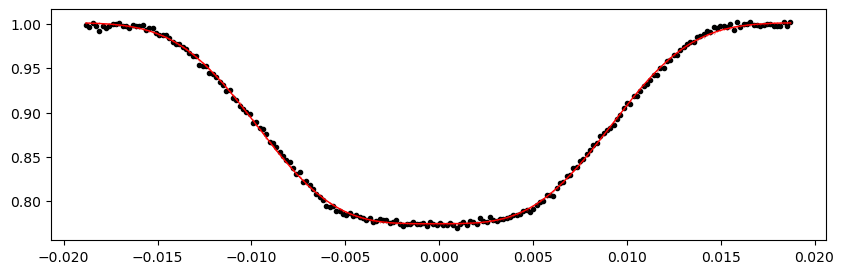

1447.43008 1.0041152122611432 -0.22937734286775174 0.22576610318860718


100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 306.82it/s]


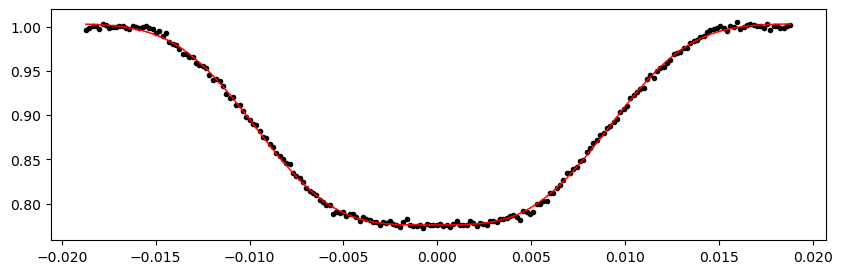

1455.2376 1.0041152122611432 -0.22937734286775174 0.22576610318860718


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 330.86it/s]


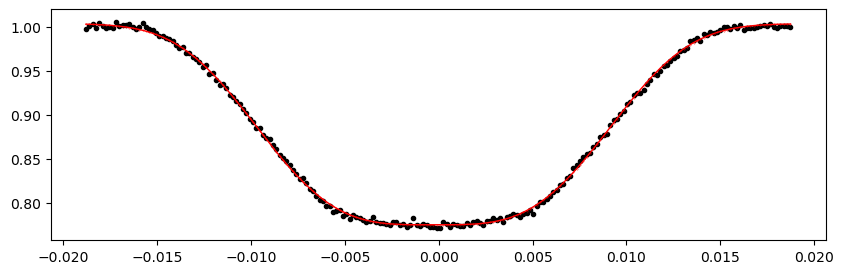

1463.04512 1.0041152122611432 -0.22937734286775174 0.22576610318860718


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 330.55it/s]


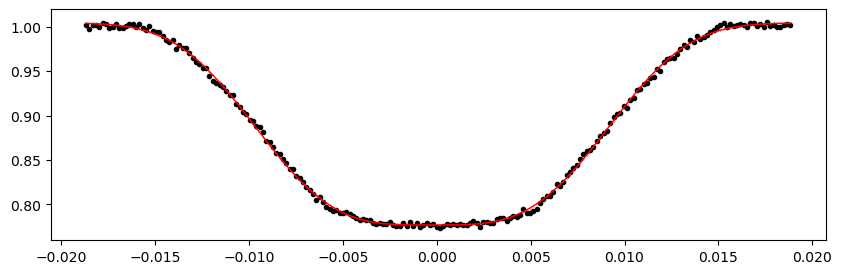

1470.85264 1.0041152122611432 -0.22937734286775174 0.22576610318860718


100%|███████████████████████████████████████████████████████| 10000/10000 [00:35<00:00, 284.36it/s]


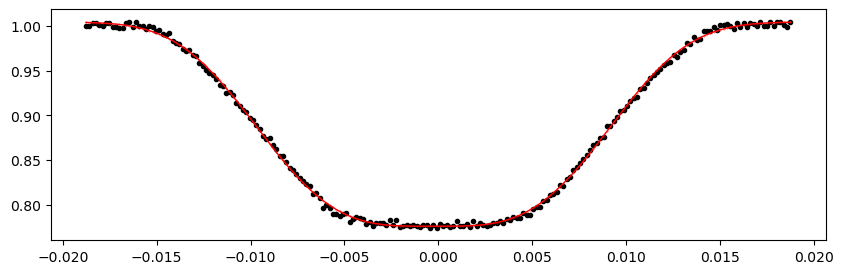

1478.66016 1.0041152122611432 -0.22937734286775174 0.22576610318860718


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 315.01it/s]


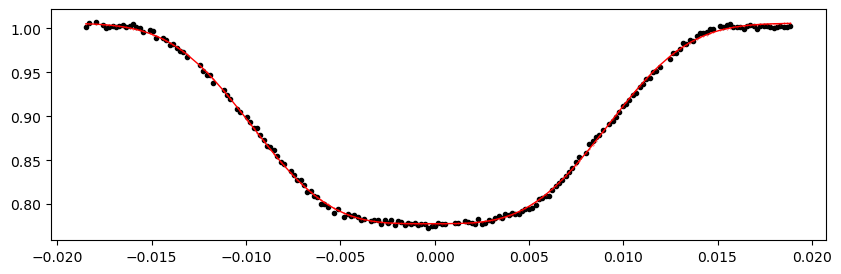

1486.46768 1.0041152122611432 -0.22937734286775174 0.22576610318860718


100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 304.03it/s]


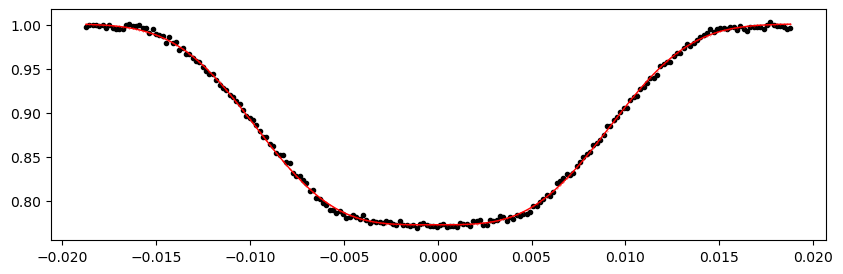

1494.2752 1.0041152122611432 -0.22937734286775174 0.22576610318860718


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 325.32it/s]


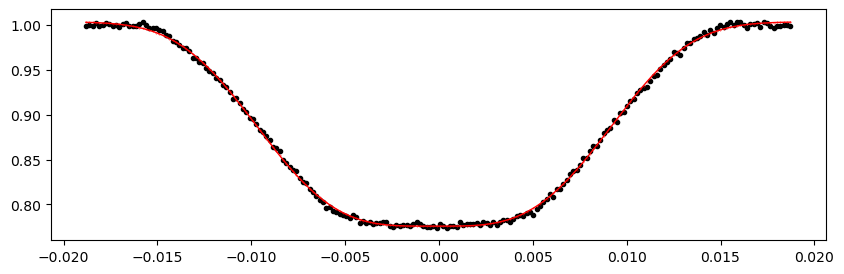

1502.0827199999999 1.0041152122611432 -0.22937734286775174 0.22576610318860718


100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 303.74it/s]


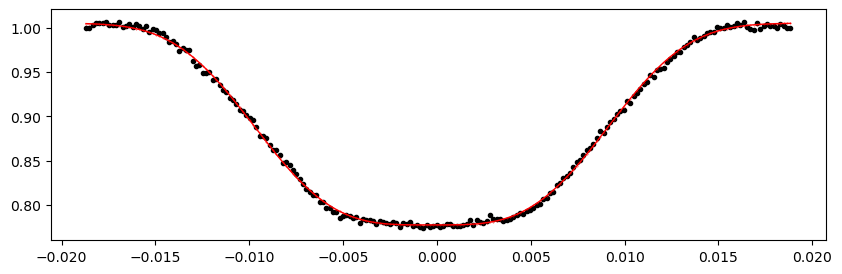

1509.89024 1.0041152122611432 -0.22937734286775174 0.22576610318860718


100%|███████████████████████████████████████████████████████| 10000/10000 [00:33<00:00, 299.78it/s]


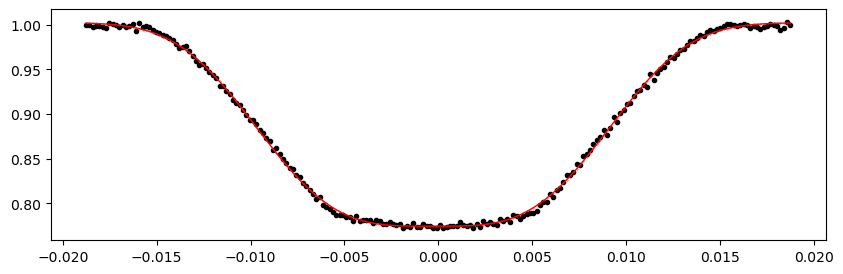

1525.50528 1.0041152122611432 -0.22937734286775174 0.22576610318860718


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 332.44it/s]


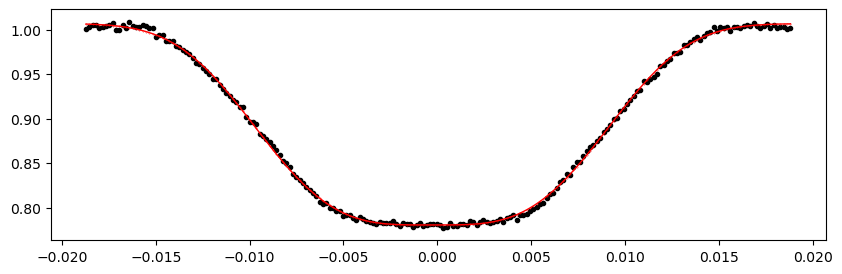

1541.12032 1.0041152122611432 -0.22937734286775174 0.22576610318860718


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 330.53it/s]


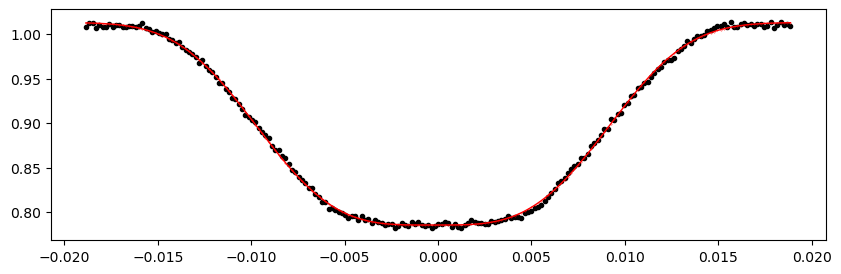

1548.92784 1.0041152122611432 -0.22937734286775174 0.22576610318860718


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 325.28it/s]


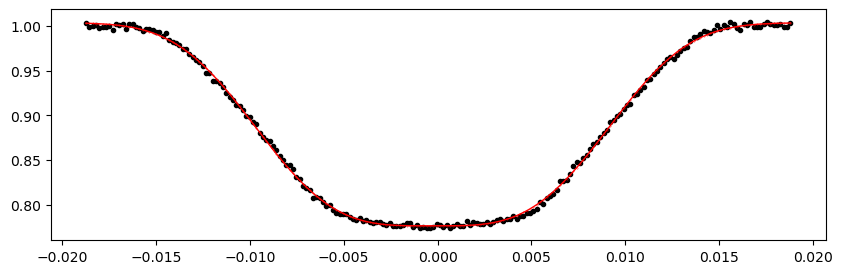

1564.54288 1.0041152122611432 -0.22937734286775174 0.22576610318860718


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 318.48it/s]


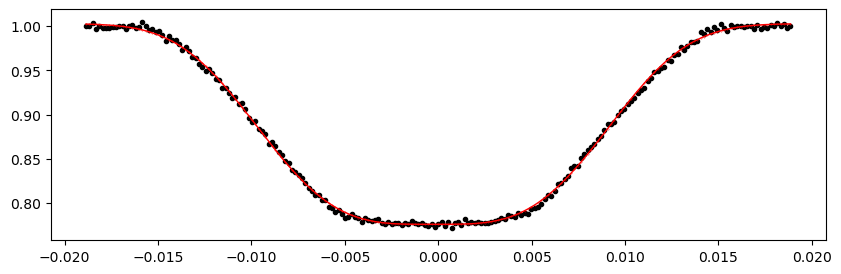

1572.3504 1.0041152122611432 -0.22937734286775174 0.22576610318860718


100%|███████████████████████████████████████████████████████| 10000/10000 [00:33<00:00, 296.09it/s]


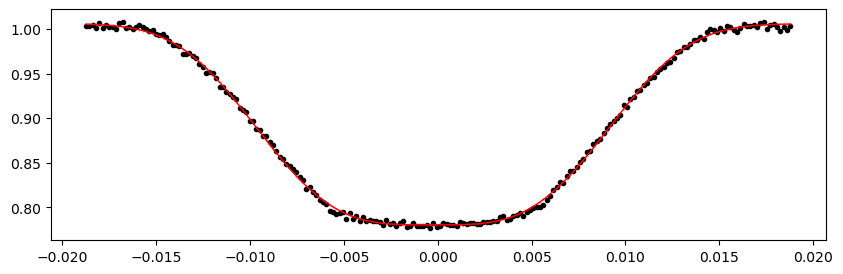

1580.15792 1.0041152122611432 -0.22937734286775174 0.22576610318860718


100%|███████████████████████████████████████████████████████| 10000/10000 [00:33<00:00, 294.65it/s]


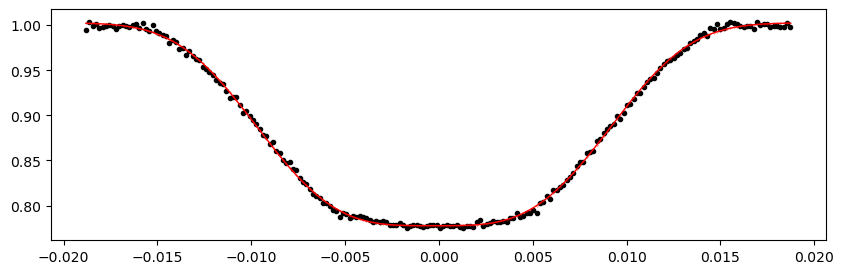

1587.96544 1.0041152122611432 -0.22937734286775174 0.22576610318860718


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 323.16it/s]


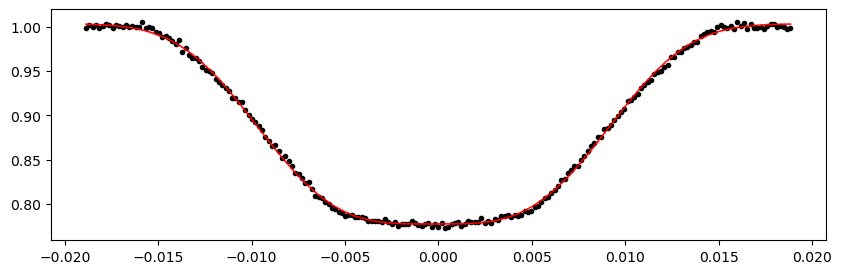

1595.77296 1.0041152122611432 -0.22937734286775174 0.22576610318860718


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 417.83it/s]


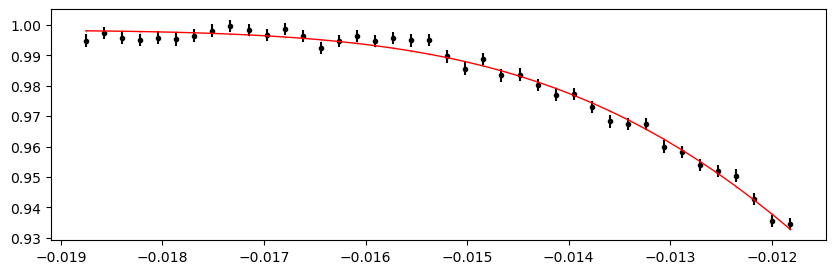

1603.58048 1.0041152122611432 -0.22937734286775174 0.22576610318860718


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 328.82it/s]


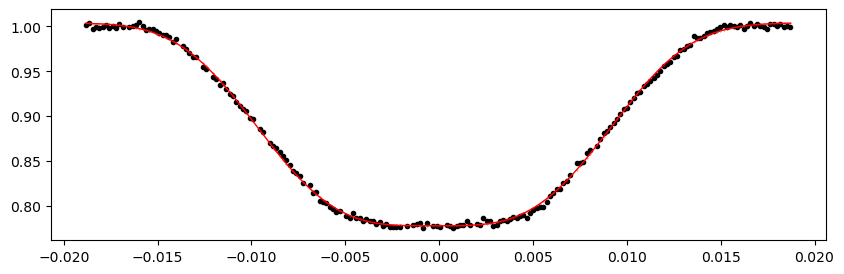

1619.19552 1.0041152122611432 -0.22937734286775174 0.22576610318860718


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 323.01it/s]


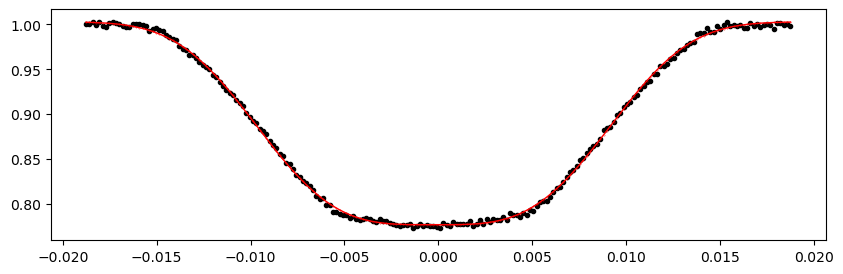

1634.81056 1.0041152122611432 -0.22937734286775174 0.22576610318860718


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 328.20it/s]


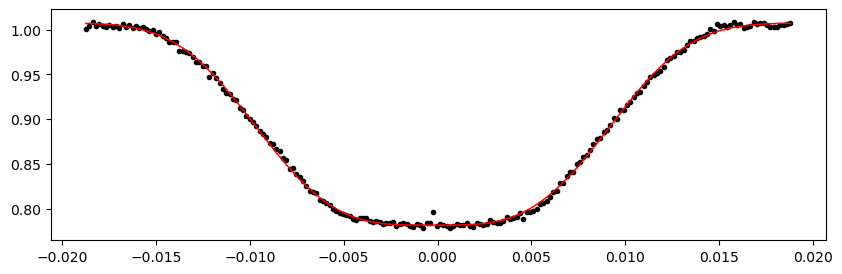

1650.4256 1.0041152122611432 -0.22937734286775174 0.22576610318860718


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 330.69it/s]


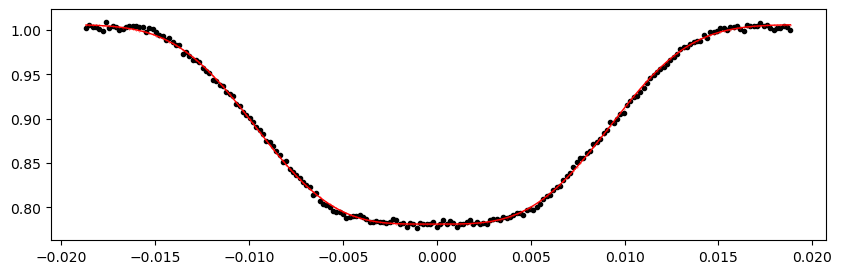

1658.2331199999999 1.0041152122611432 -0.22937734286775174 0.22576610318860718


100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 307.79it/s]


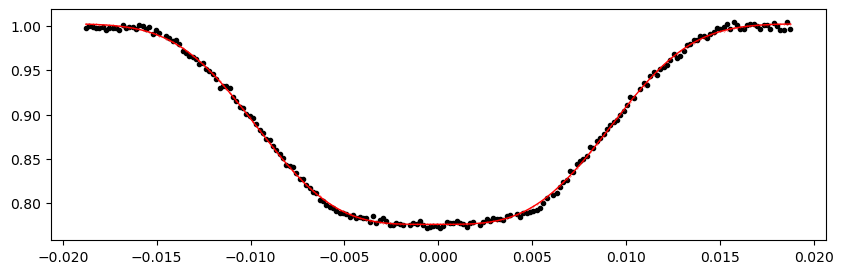

1666.04064 1.0041152122611432 -0.22937734286775174 0.22576610318860718


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 329.84it/s]


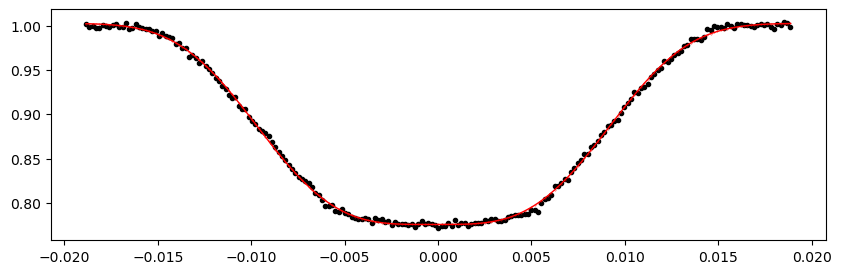

1673.84816 1.0041152122611432 -0.22937734286775174 0.22576610318860718


100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 303.59it/s]


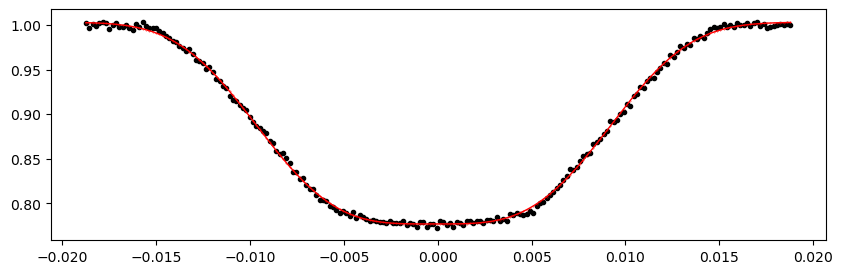

1681.65568 1.0041152122611432 -0.22937734286775174 0.22576610318860718


100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 303.62it/s]


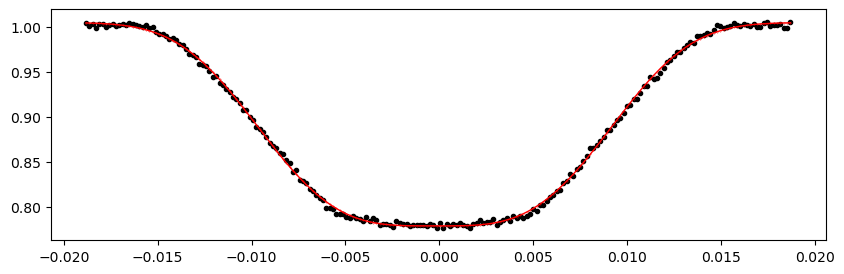

2040.8016 1.0041152122611432 -0.22937734286775174 0.22576610318860718


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 424.87it/s]


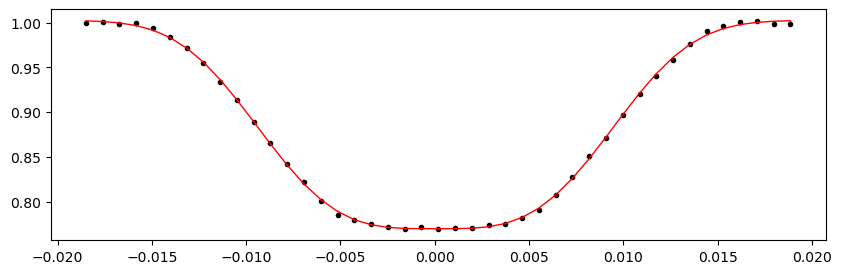

2056.41664 1.0041152122611432 -0.22937734286775174 0.22576610318860718


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 424.34it/s]


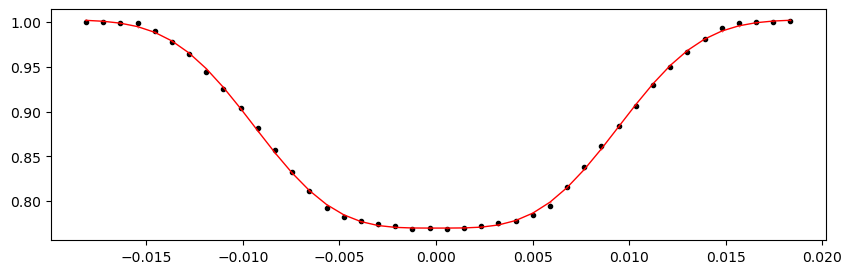

2064.2241599999998 1.0041152122611432 -0.22937734286775174 0.22576610318860718


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 425.47it/s]


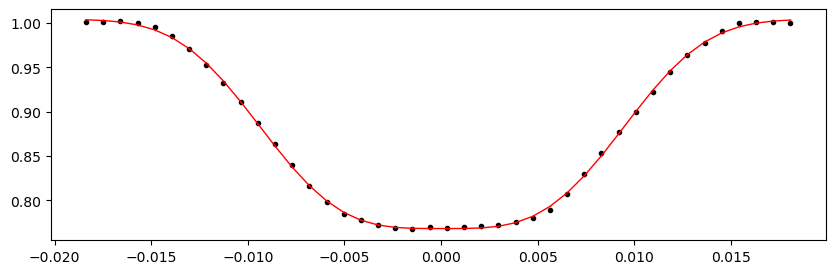

2072.03168 1.0041152122611432 -0.22937734286775174 0.22576610318860718


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 426.91it/s]


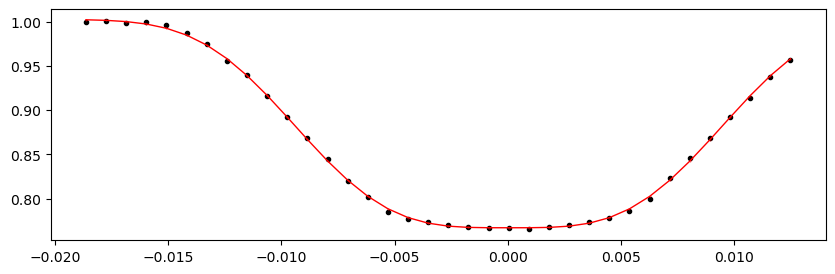

2079.8392 1.0041152122611432 -0.22937734286775174 0.22576610318860718


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 424.91it/s]


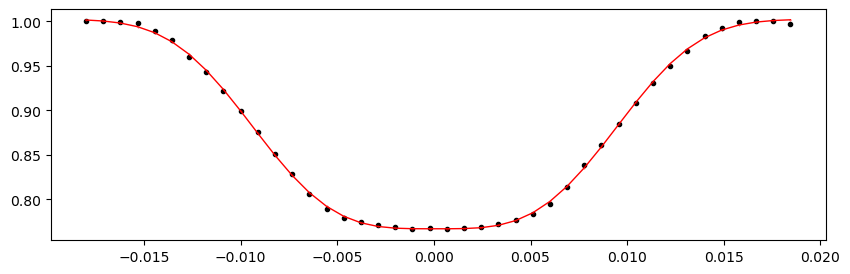

2095.45424 1.0041152122611432 -0.22937734286775174 0.22576610318860718


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 417.40it/s]


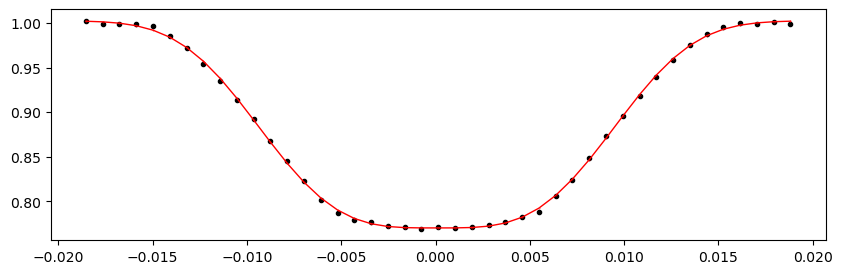

2103.26176 1.0041152122611432 -0.22937734286775174 0.22576610318860718


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 419.56it/s]


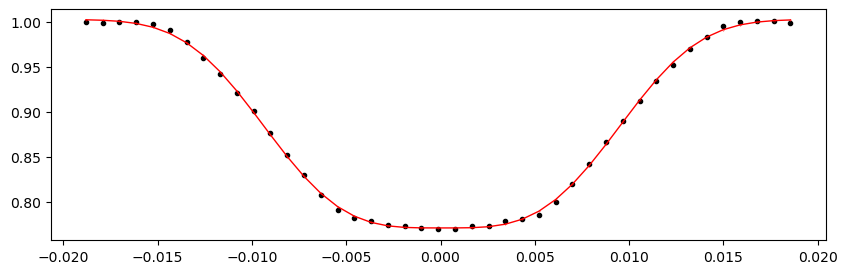

2111.06928 1.0041152122611432 -0.22937734286775174 0.22576610318860718


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 423.78it/s]


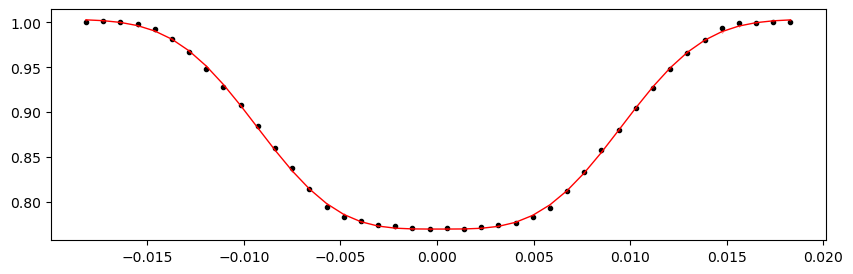

2118.8768 1.0041152122611432 -0.22937734286775174 0.22576610318860718


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 423.79it/s]


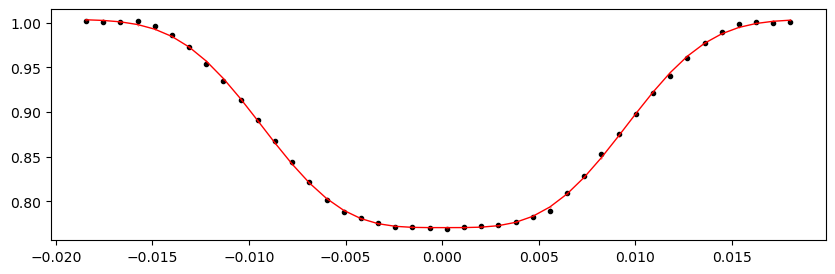

2126.68432 1.0041152122611432 -0.22937734286775174 0.22576610318860718


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 425.73it/s]


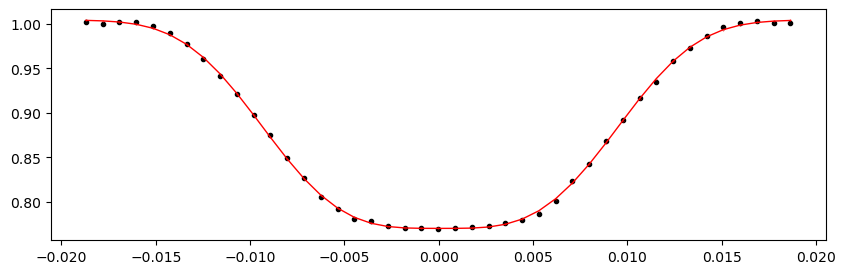

2134.49184 1.0041152122611432 -0.22937734286775174 0.22576610318860718


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 425.20it/s]


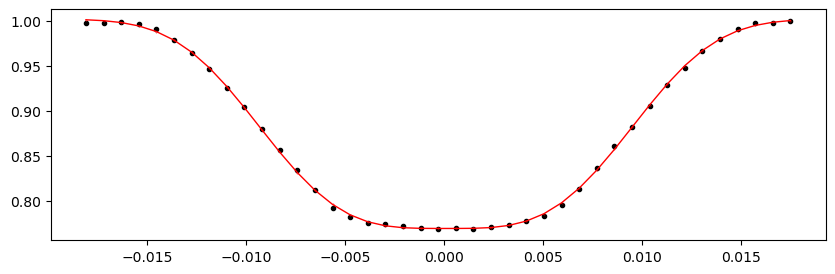

2150.1068800000003 1.0041152122611432 -0.22937734286775174 0.22576610318860718


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 426.02it/s]


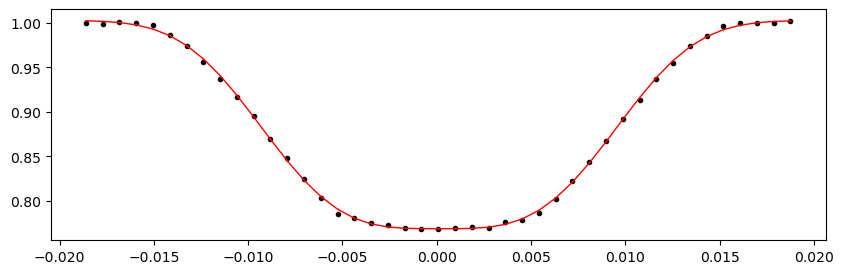

2165.72192 1.0041152122611432 -0.22937734286775174 0.22576610318860718


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 425.64it/s]


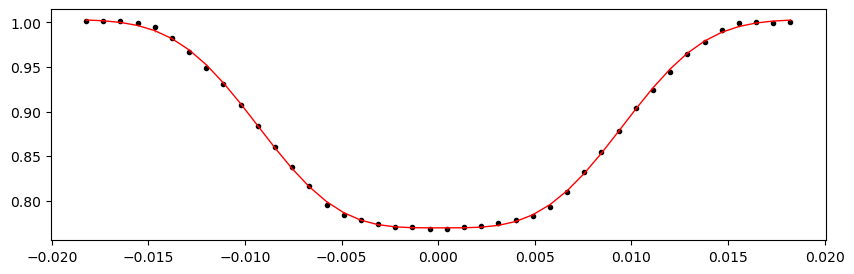

2181.33696 1.0041152122611432 -0.22937734286775174 0.22576610318860718


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 421.25it/s]


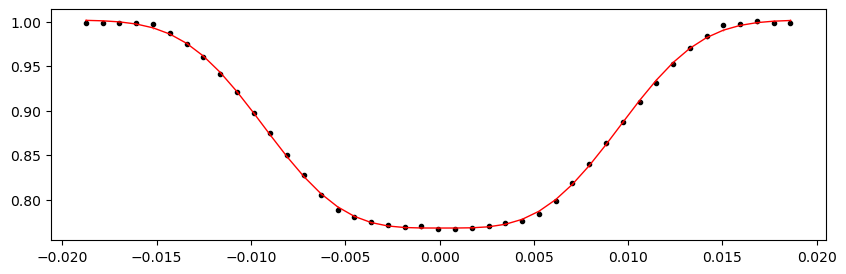

2189.14448 1.0041152122611432 -0.22937734286775174 0.22576610318860718


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 424.90it/s]


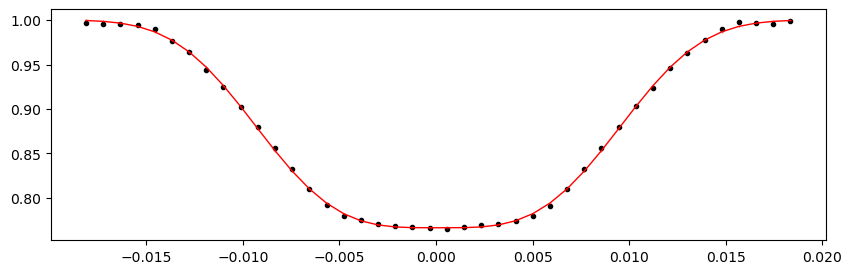

2196.952 1.0041152122611432 -0.22937734286775174 0.22576610318860718


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 419.98it/s]


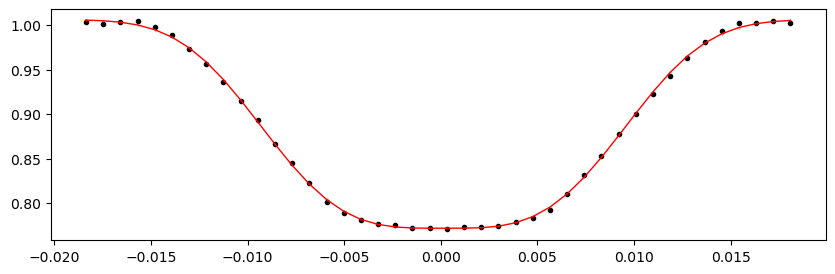

2204.75952 1.0041152122611432 -0.22937734286775174 0.22576610318860718


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 424.08it/s]


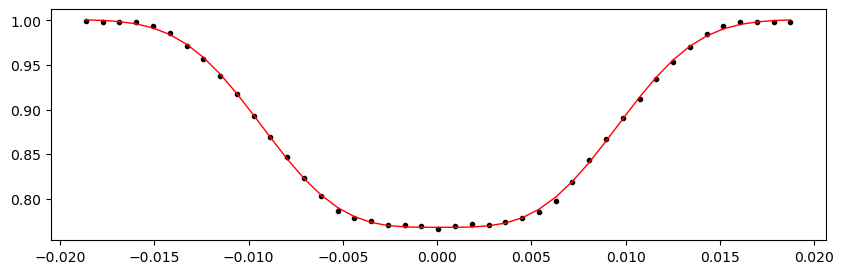

2212.56704 1.0041152122611432 -0.22937734286775174 0.22576610318860718


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 421.80it/s]


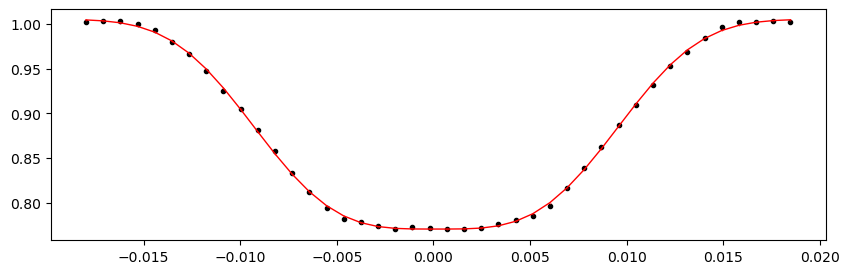

2220.37456 1.0041152122611432 -0.22937734286775174 0.22576610318860718


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 424.63it/s]


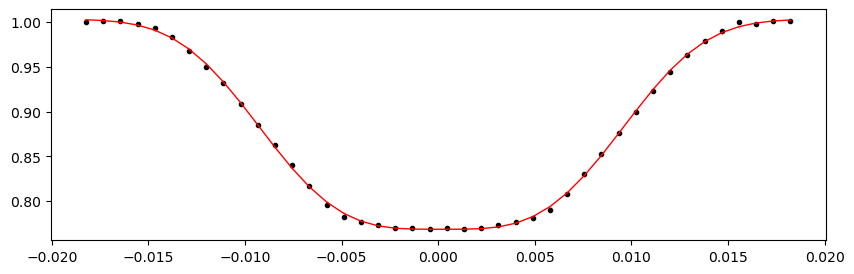

2235.9896 1.0041152122611432 -0.22937734286775174 0.22576610318860718


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 424.09it/s]


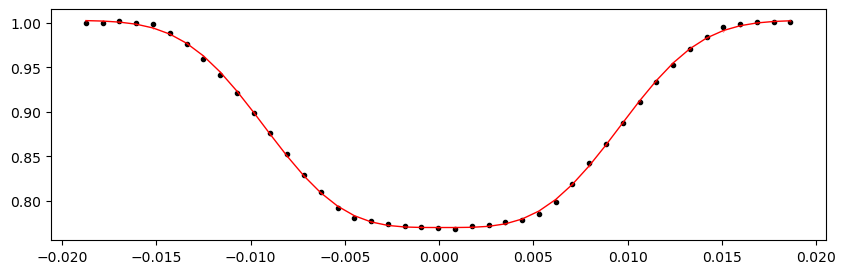

2243.79712 1.0041152122611432 -0.22937734286775174 0.22576610318860718


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 422.95it/s]


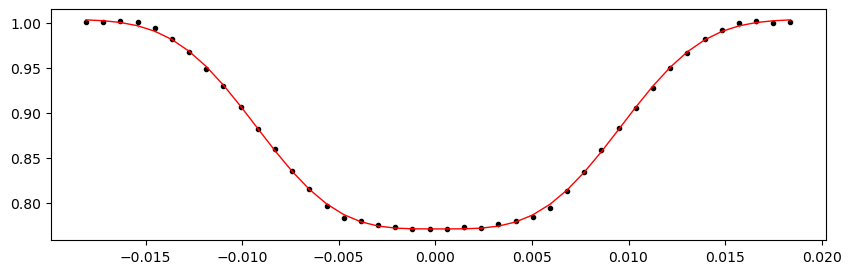

2251.60464 1.0041152122611432 -0.22937734286775174 0.22576610318860718


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 419.58it/s]


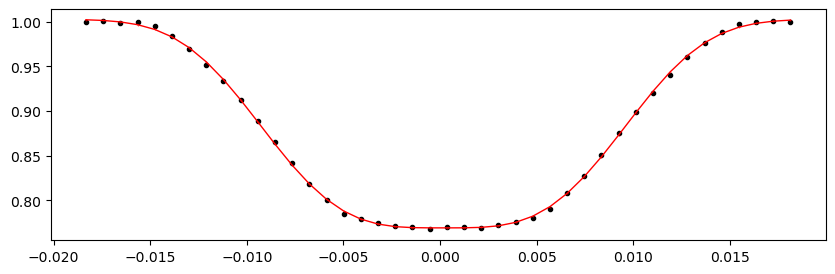

2259.41216 1.0041152122611432 -0.22937734286775174 0.22576610318860718


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 422.36it/s]


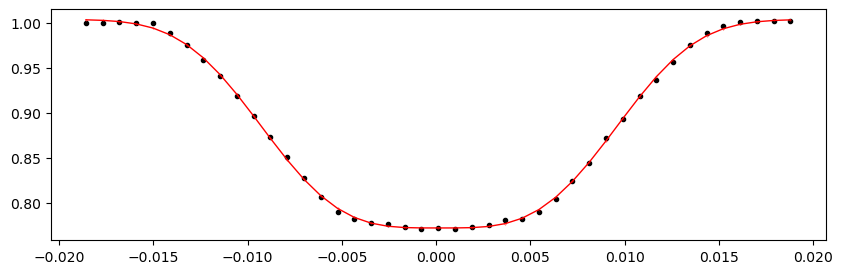

Time 2267.21968 does not have enough data points: 11
2275.0272 1.0041152122611432 -0.22937734286775174 0.22576610318860718


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 423.49it/s]


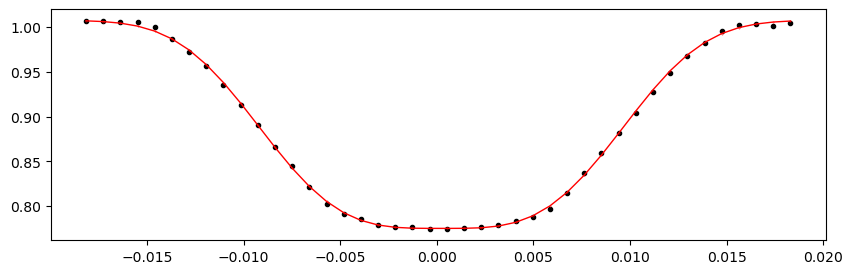

2314.0648 1.0041152122611432 -0.22937734286775174 0.22576610318860718


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 423.23it/s]


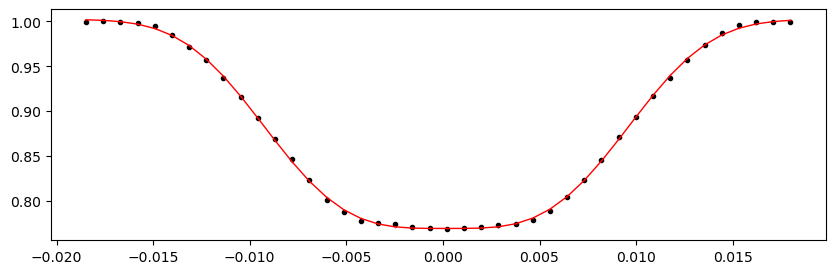

Time 2321.87232 does not have enough data points: 1
2329.67984 1.0041152122611432 -0.22937734286775174 0.22576610318860718


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 424.33it/s]


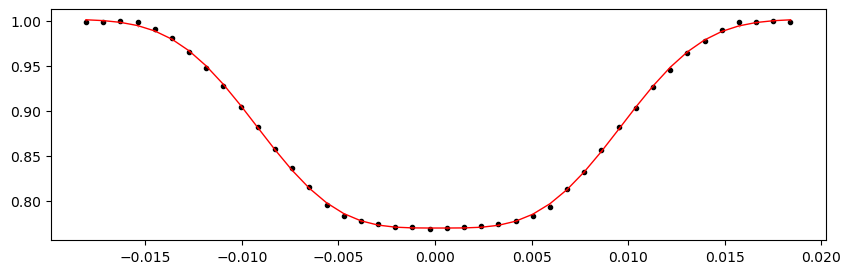

2337.48736 1.0041152122611432 -0.22937734286775174 0.22576610318860718


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 422.65it/s]


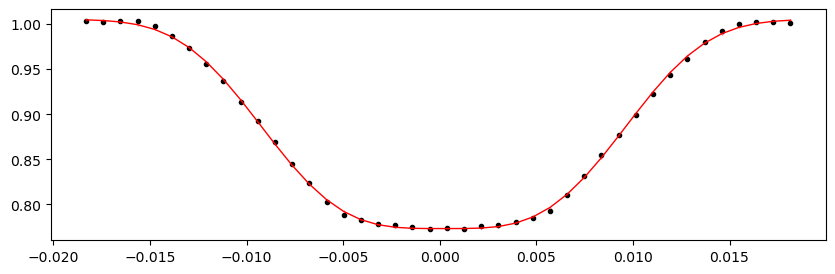

2345.29488 1.0041152122611432 -0.22937734286775174 0.22576610318860718


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 421.84it/s]


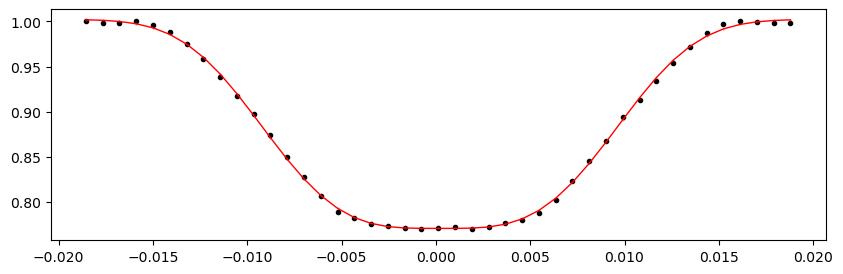

2353.1023999999998 1.0041152122611432 -0.22937734286775174 0.22576610318860718


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 420.38it/s]


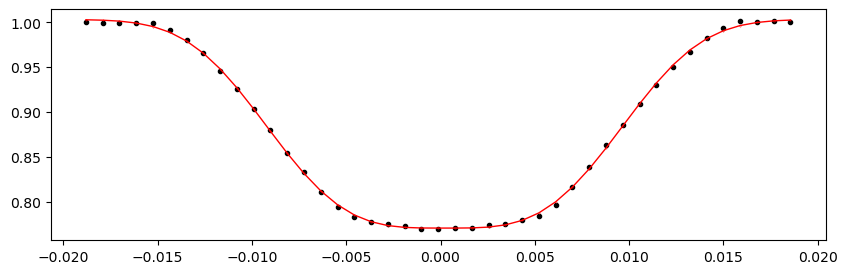

2368.7174400000004 1.0041152122611432 -0.22937734286775174 0.22576610318860718


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 422.51it/s]


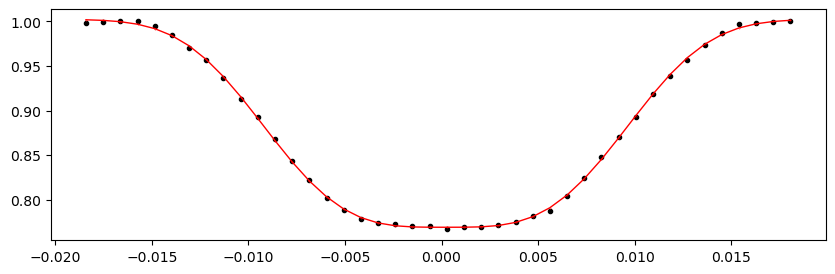

2376.5249599999997 1.0041152122611432 -0.22937734286775174 0.22576610318860718


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 422.92it/s]


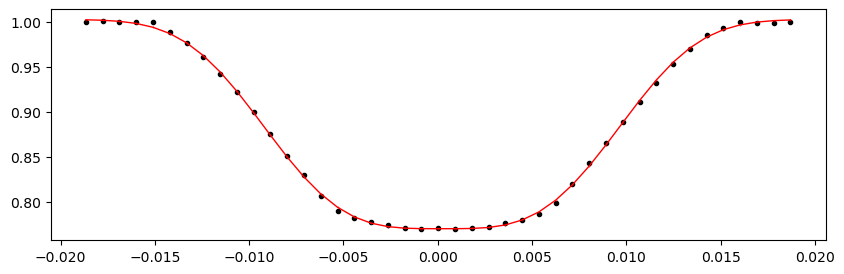

2384.33248 1.0041152122611432 -0.22937734286775174 0.22576610318860718


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 424.59it/s]


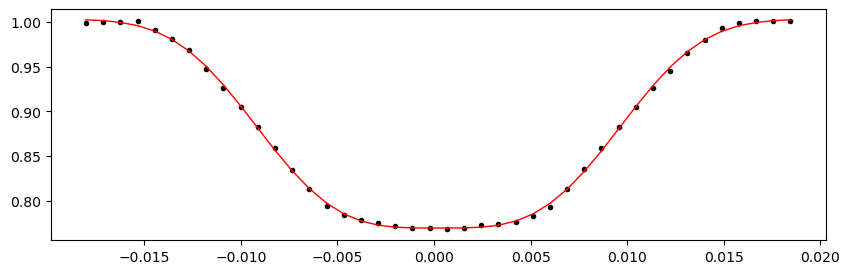

2969.8964800000003 1.0041152122611432 -0.22937734286775174 0.22576610318860718


100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 305.94it/s]


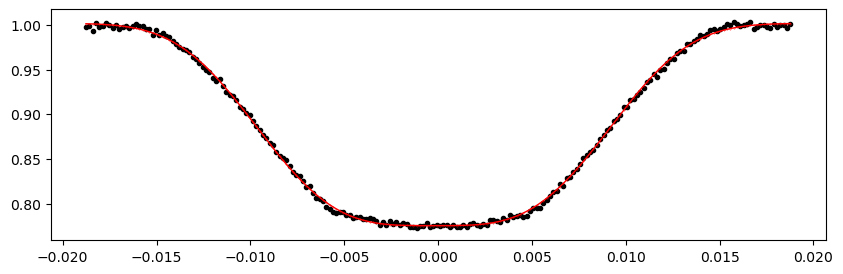

2977.7039999999997 1.0041152122611432 -0.22937734286775174 0.22576610318860718


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 330.42it/s]


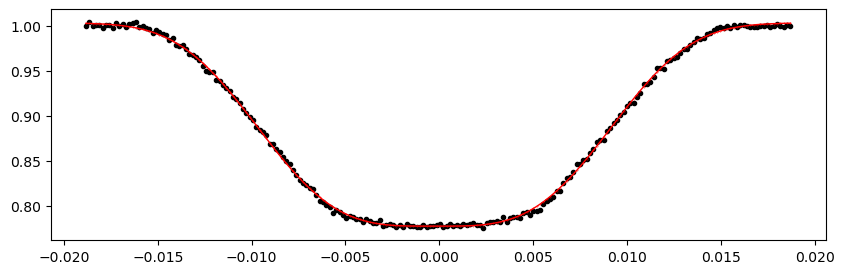

2985.51152 1.0041152122611432 -0.22937734286775174 0.22576610318860718


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 332.27it/s]


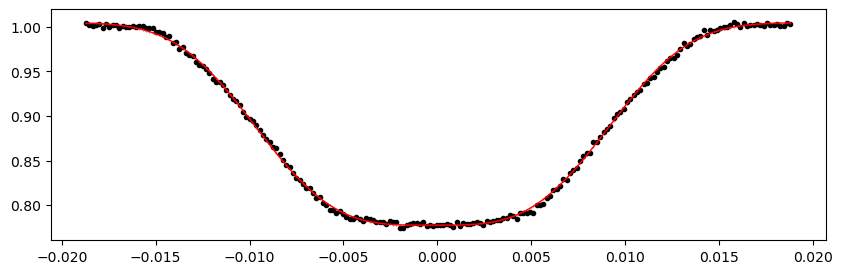

2993.3190400000003 1.0041152122611432 -0.22937734286775174 0.22576610318860718


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 331.23it/s]


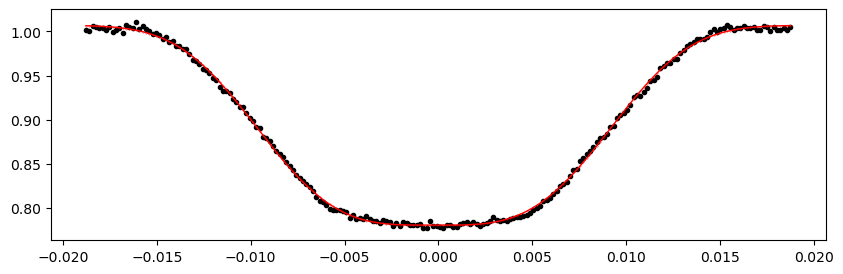

3008.93408 1.0041152122611432 -0.22937734286775174 0.22576610318860718


100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 307.69it/s]


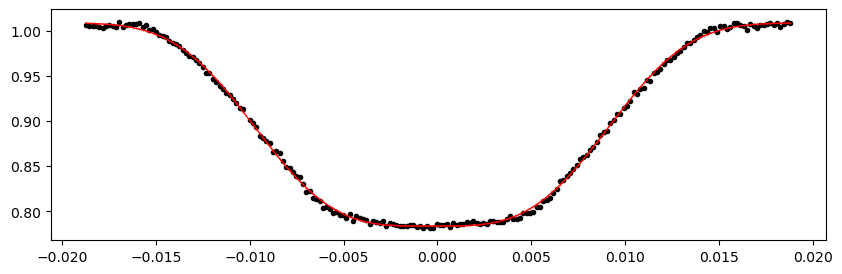

3016.7416000000003 1.0041152122611432 -0.22937734286775174 0.22576610318860718


100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 304.76it/s]


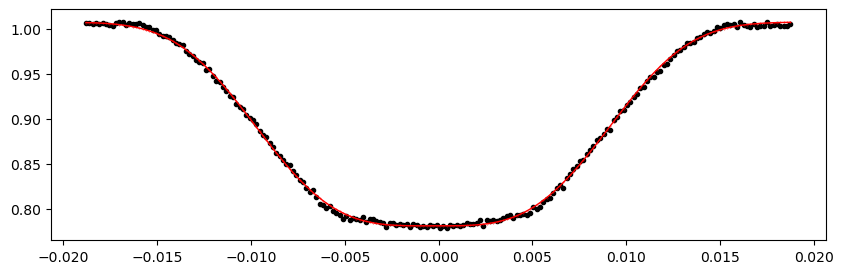

3024.54912 1.0041152122611432 -0.22937734286775174 0.22576610318860718


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 330.04it/s]


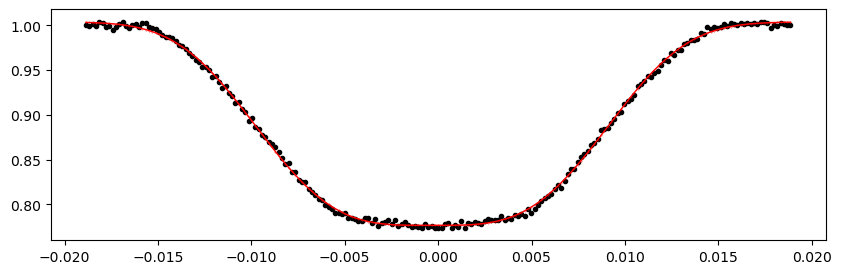

3032.35664 1.0041152122611432 -0.22937734286775174 0.22576610318860718


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 333.14it/s]


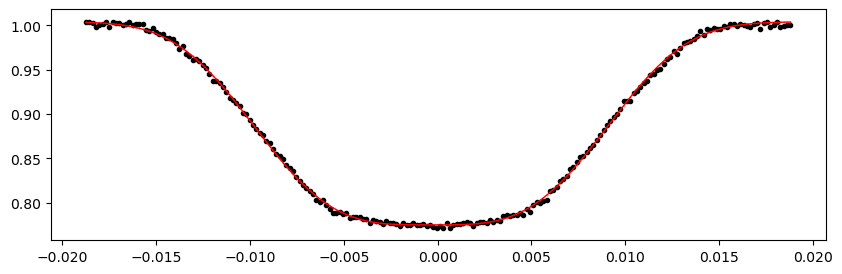

3040.1641600000003 1.0041152122611432 -0.22937734286775174 0.22576610318860718


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 357.81it/s]


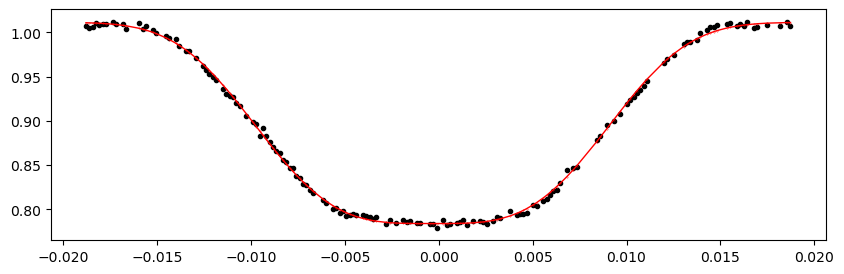

3047.97168 1.0041152122611432 -0.22937734286775174 0.22576610318860718


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 331.23it/s]


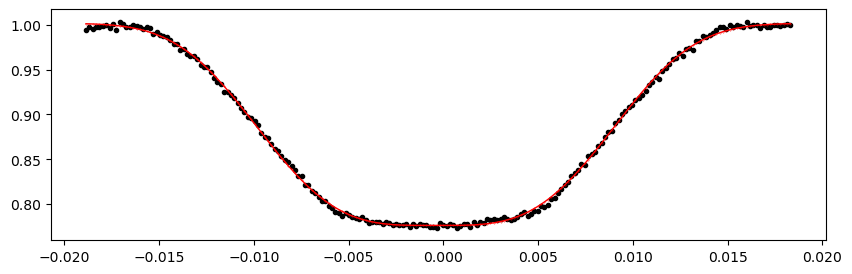

3055.7792 1.0041152122611432 -0.22937734286775174 0.22576610318860718


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 330.71it/s]


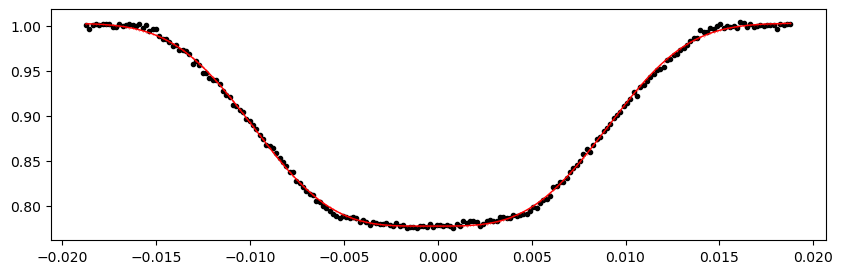

3063.5867200000002 1.0041152122611432 -0.22937734286775174 0.22576610318860718


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 331.58it/s]


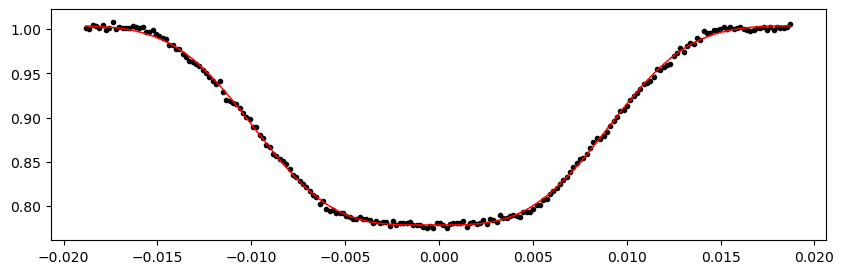

3071.39424 1.0041152122611432 -0.22937734286775174 0.22576610318860718


100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 304.61it/s]


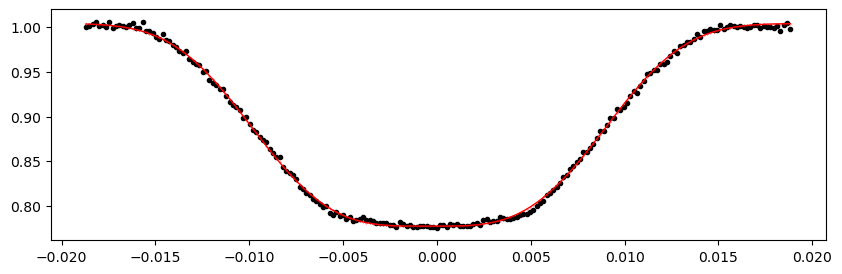

3079.20176 1.0041152122611432 -0.22937734286775174 0.22576610318860718


100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 304.46it/s]


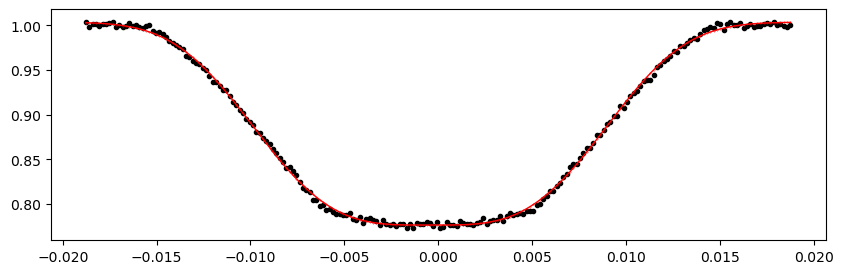

3087.00928 1.0041152122611432 -0.22937734286775174 0.22576610318860718


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 329.16it/s]


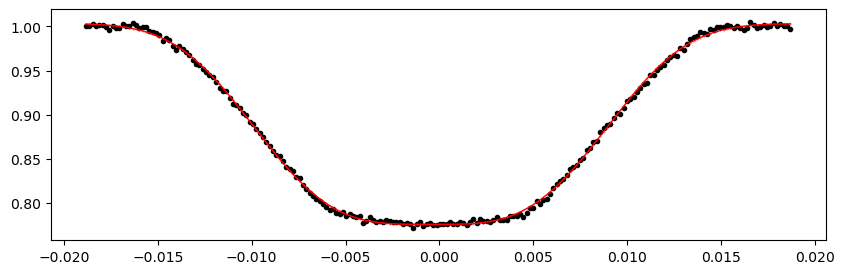

3102.62432 1.0041152122611432 -0.22937734286775174 0.22576610318860718


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 375.11it/s]


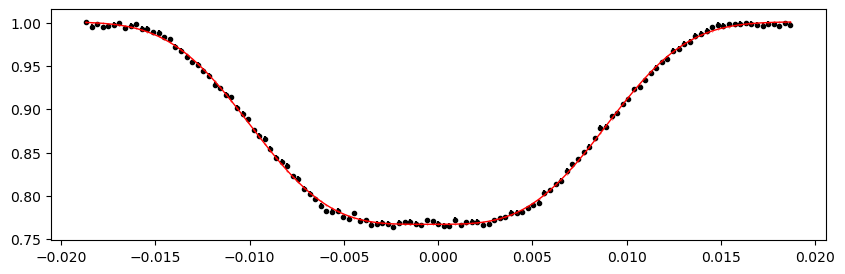

3110.43184 1.0041152122611432 -0.22937734286775174 0.22576610318860718


100%|███████████████████████████████████████████████████████| 10000/10000 [00:28<00:00, 345.24it/s]


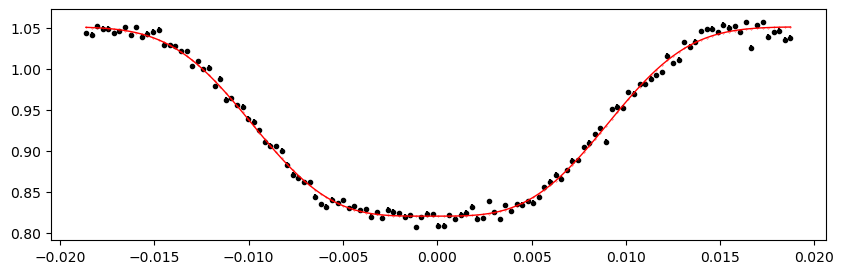

3118.23936 1.0041152122611432 -0.22937734286775174 0.22576610318860718


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 379.82it/s]


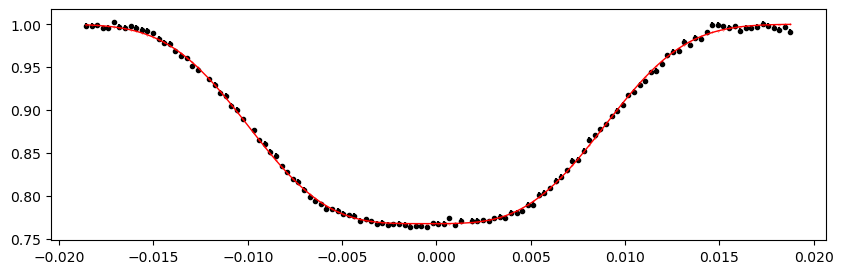

3133.8544 1.0041152122611432 -0.22937734286775174 0.22576610318860718


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 331.05it/s]


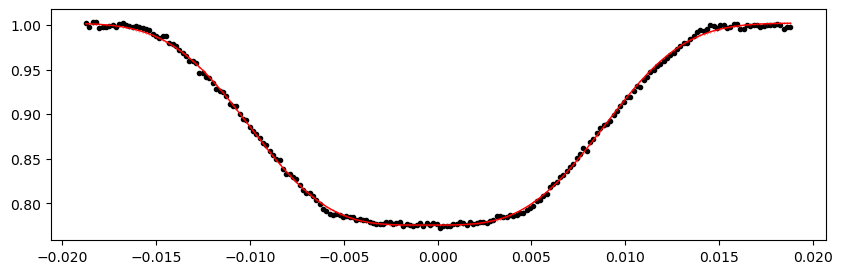

3141.66192 1.0041152122611432 -0.22937734286775174 0.22576610318860718


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 333.10it/s]


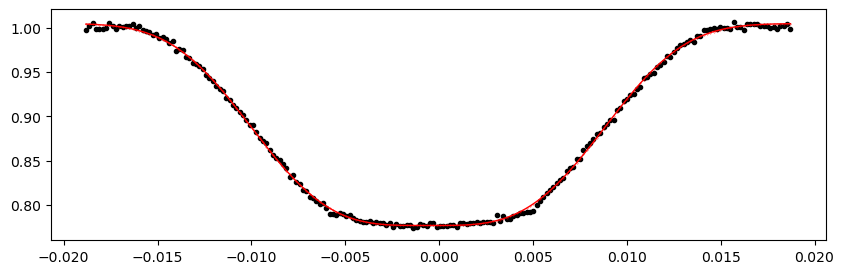

3149.46944 1.0041152122611432 -0.22937734286775174 0.22576610318860718


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 328.49it/s]


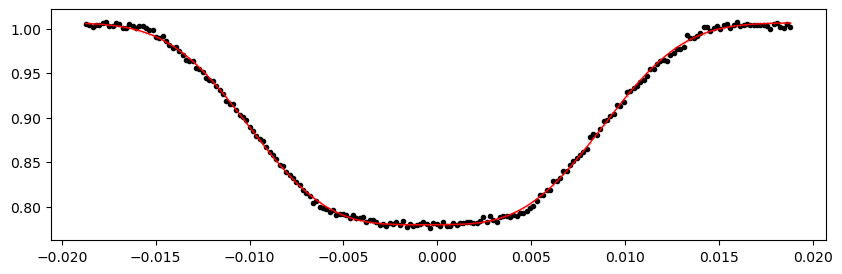

3157.27696 1.0041152122611432 -0.22937734286775174 0.22576610318860718


100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 304.32it/s]


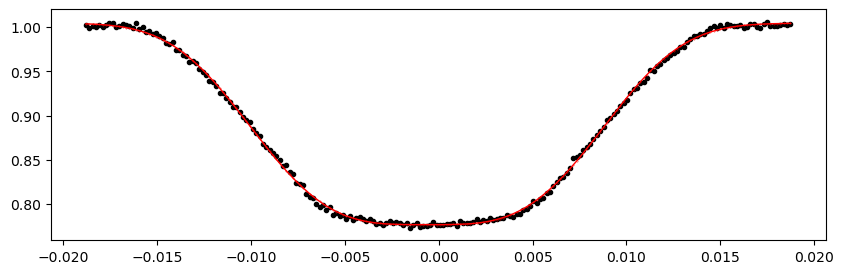

3165.08448 1.0041152122611432 -0.22937734286775174 0.22576610318860718


100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 303.15it/s]


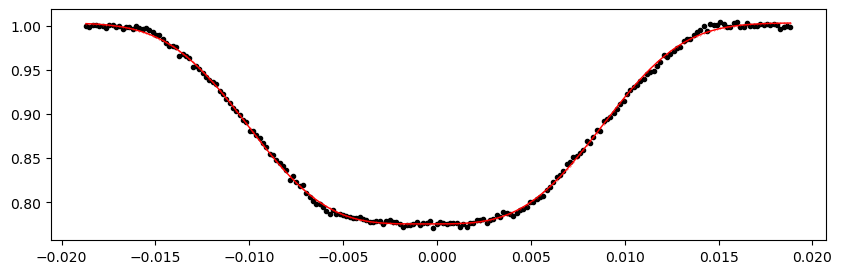

3172.892 1.0041152122611432 -0.22937734286775174 0.22576610318860718


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 331.18it/s]


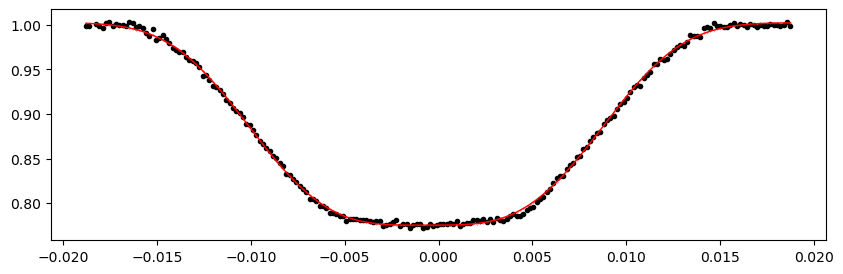

3188.50704 1.0041152122611432 -0.22937734286775174 0.22576610318860718


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 342.26it/s]


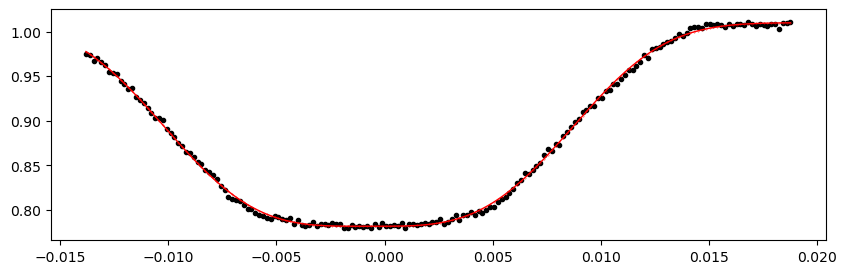

3196.31456 1.0041152122611432 -0.22937734286775174 0.22576610318860718


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 329.50it/s]


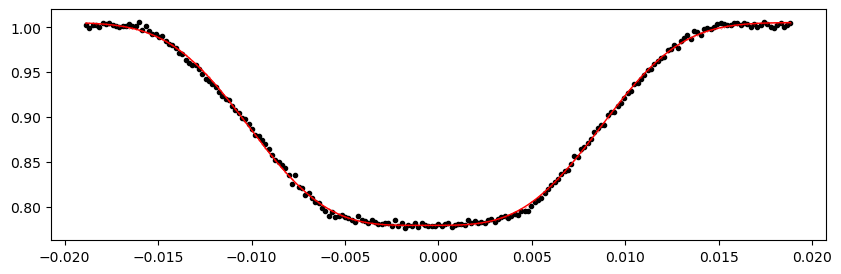

Fitting individual secondary eclipses...
Existing manifest file found, will skip previously processed LCs and append to end of manifest file
Number 0 has already been completed -- skip
1334.2048 1.0002786053716999 -0.05512143769259481 -0.2766361703541277


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 443.55it/s]


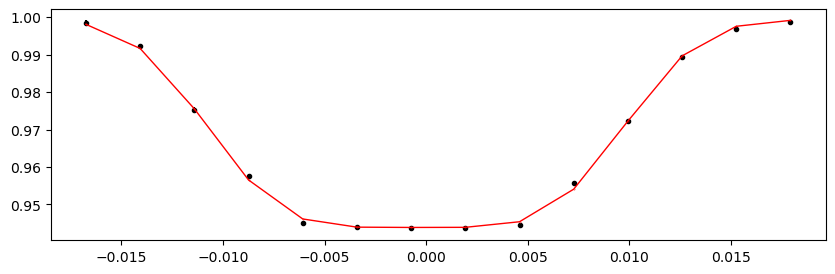

1342.0123199999998 1.0002786053716999 -0.05512143769259481 -0.2766361703541277


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 442.79it/s]


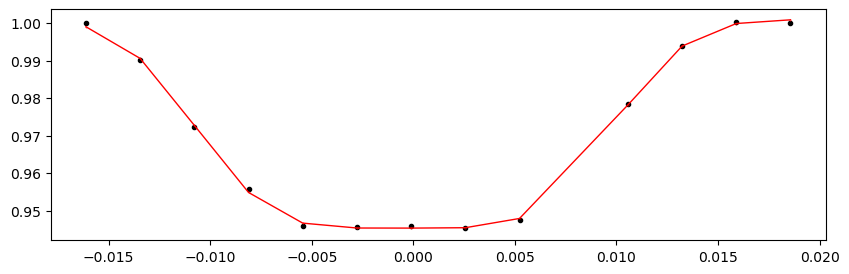

Time 1349.8198399999999 does not have enough data points: 12
1357.62736 1.0002786053716999 -0.05512143769259481 -0.2766361703541277


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 442.46it/s]


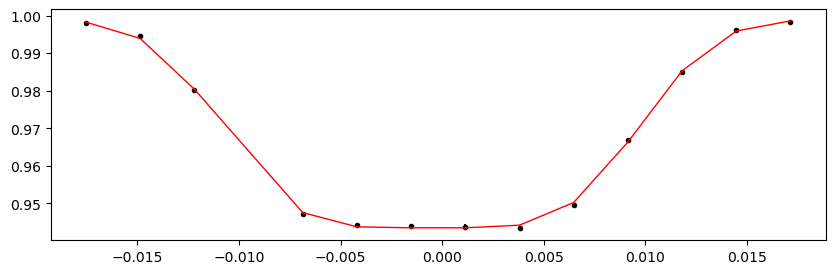

1365.4348799999998 1.0002786053716999 -0.05512143769259481 -0.2766361703541277


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 445.41it/s]


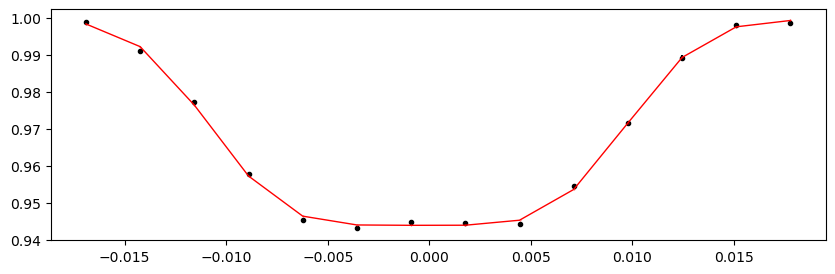

1373.2423999999999 1.0002786053716999 -0.05512143769259481 -0.2766361703541277


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 446.34it/s]


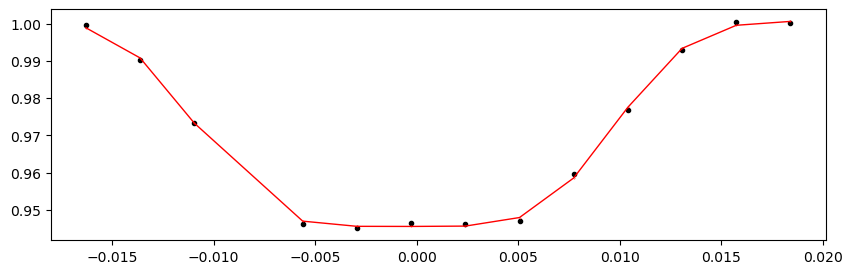

1388.85744 1.0002786053716999 -0.05512143769259481 -0.2766361703541277


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 442.66it/s]


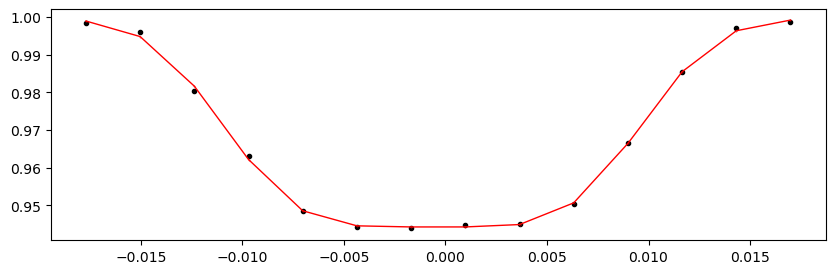

Time 1396.6649599999998 does not have enough data points: 7
1404.47248 1.0002786053716999 -0.05512143769259481 -0.2766361703541277


100%|███████████████████████████████████████████████████████| 10000/10000 [00:22<00:00, 445.11it/s]


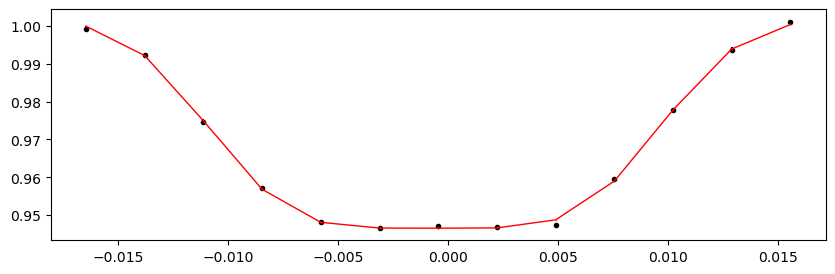

1412.28 1.0002786053716999 -0.05512143769259481 -0.2766361703541277


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 312.92it/s]


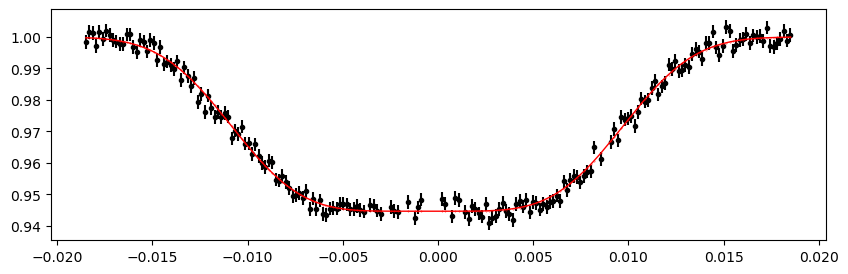

1427.8950399999999 1.0002786053716999 -0.05512143769259481 -0.2766361703541277


100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 304.76it/s]


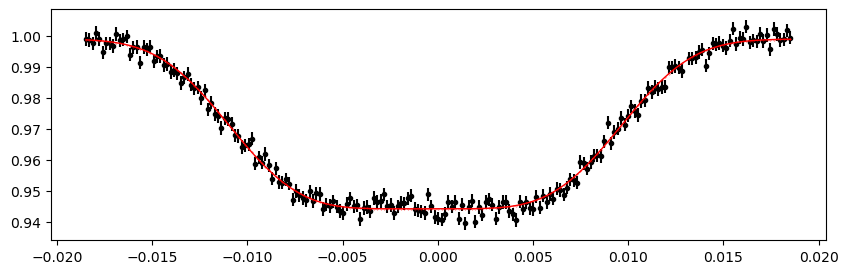

1435.70256 1.0002786053716999 -0.05512143769259481 -0.2766361703541277


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 331.07it/s]


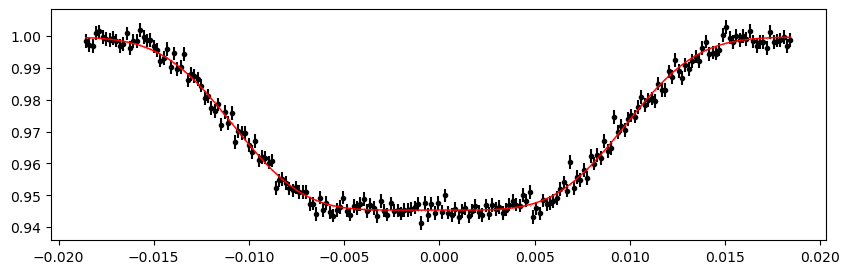

1443.51008 1.0002786053716999 -0.05512143769259481 -0.2766361703541277


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 330.89it/s]


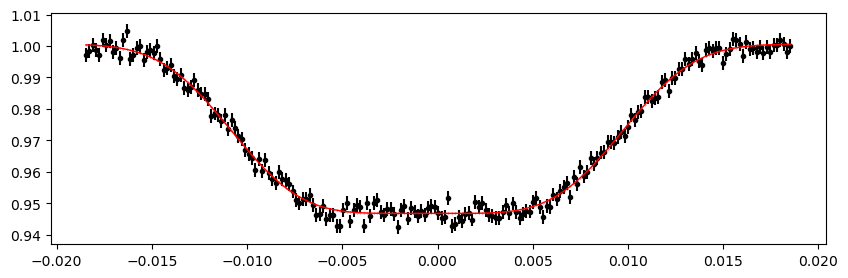

1459.12512 1.0002786053716999 -0.05512143769259481 -0.2766361703541277


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 331.58it/s]


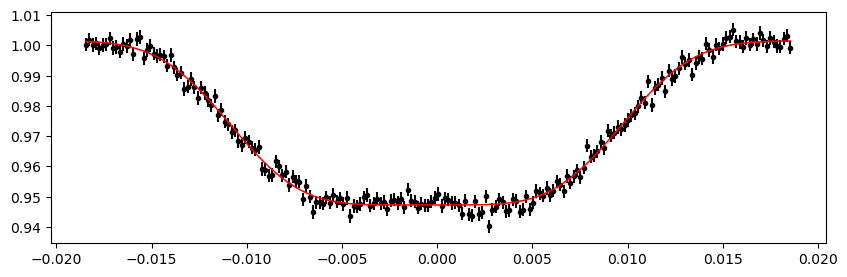

1474.7401599999998 1.0002786053716999 -0.05512143769259481 -0.2766361703541277


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 342.25it/s]


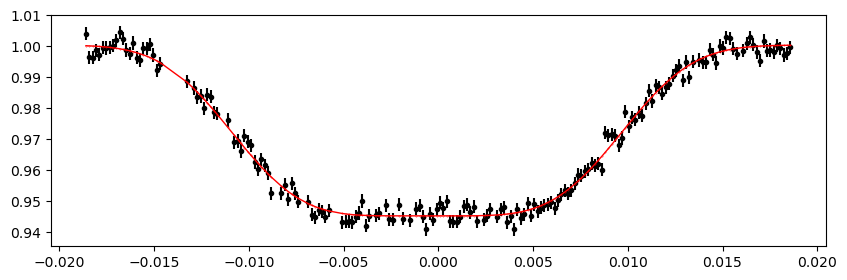

1482.54768 1.0002786053716999 -0.05512143769259481 -0.2766361703541277


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 332.60it/s]


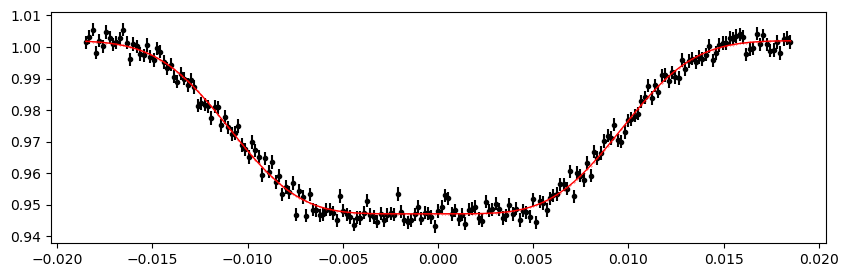

1498.1627199999998 1.0002786053716999 -0.05512143769259481 -0.2766361703541277


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 331.55it/s]


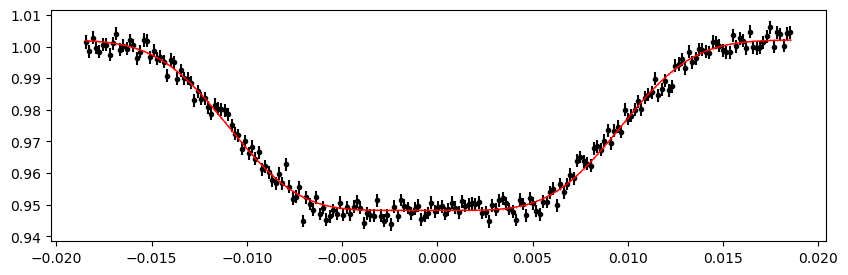

1505.9702399999999 1.0002786053716999 -0.05512143769259481 -0.2766361703541277


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 331.76it/s]


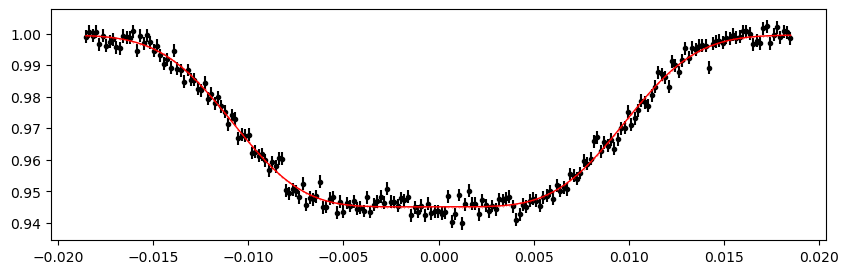

1513.77776 1.0002786053716999 -0.05512143769259481 -0.2766361703541277


100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 306.37it/s]


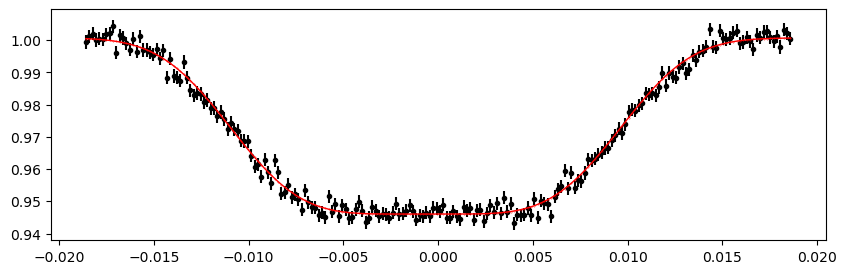

1521.58528 1.0002786053716999 -0.05512143769259481 -0.2766361703541277


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 332.44it/s]


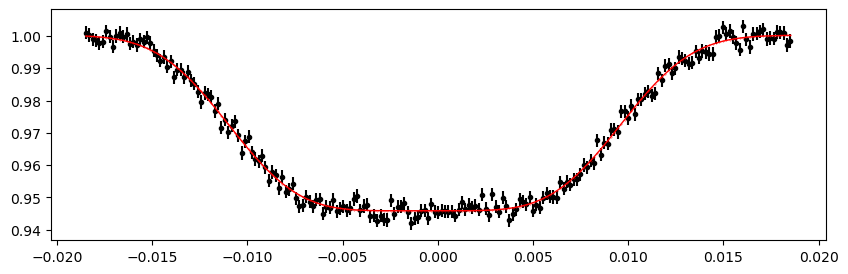

1537.20032 1.0002786053716999 -0.05512143769259481 -0.2766361703541277


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 333.83it/s]


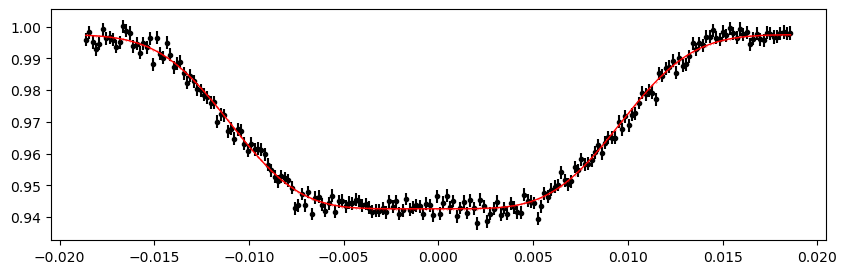

1545.00784 1.0002786053716999 -0.05512143769259481 -0.2766361703541277


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 330.87it/s]


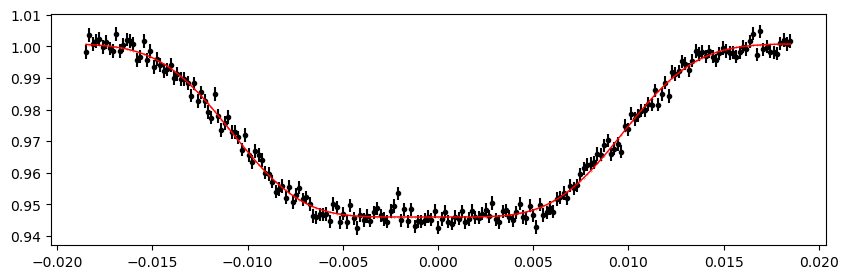

1552.8153599999998 1.0002786053716999 -0.05512143769259481 -0.2766361703541277


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 328.49it/s]


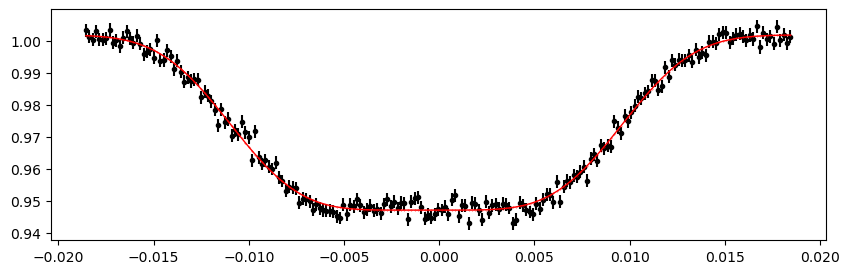

1560.62288 1.0002786053716999 -0.05512143769259481 -0.2766361703541277


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 330.89it/s]


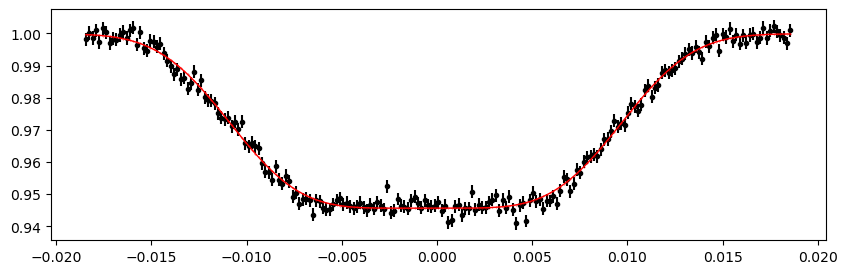

1568.4304 1.0002786053716999 -0.05512143769259481 -0.2766361703541277


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 362.35it/s]


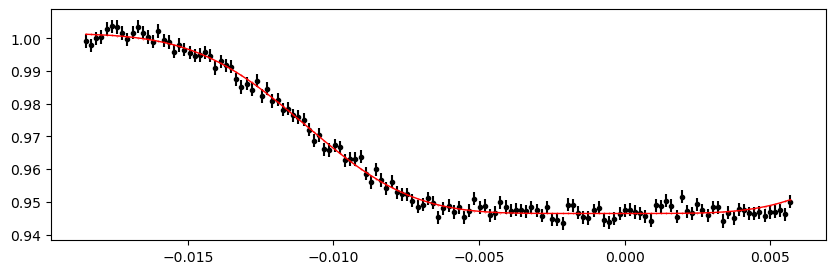

1576.23792 1.0002786053716999 -0.05512143769259481 -0.2766361703541277


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 333.11it/s]


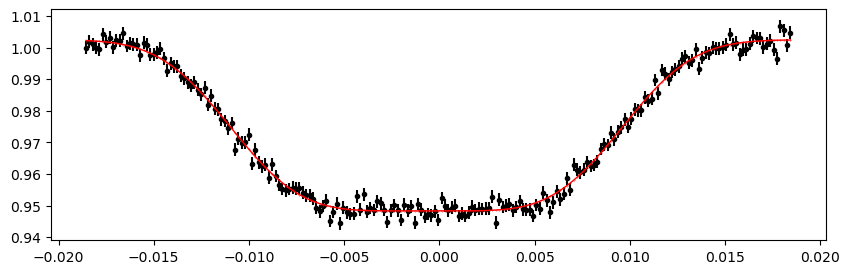

1591.85296 1.0002786053716999 -0.05512143769259481 -0.2766361703541277


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 331.40it/s]


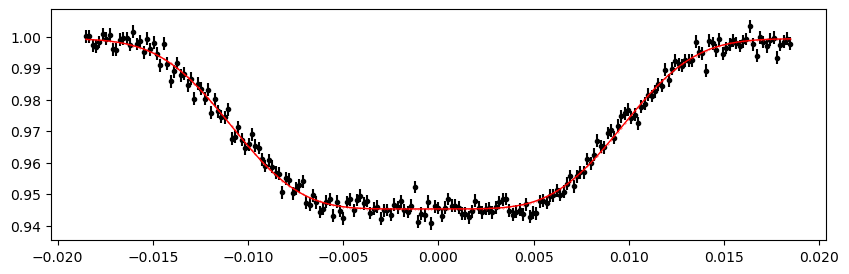

1599.66048 1.0002786053716999 -0.05512143769259481 -0.2766361703541277


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 331.82it/s]


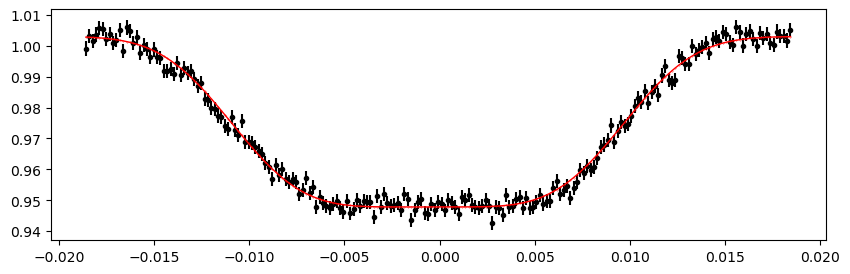

1607.4679999999998 1.0002786053716999 -0.05512143769259481 -0.2766361703541277


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 329.35it/s]


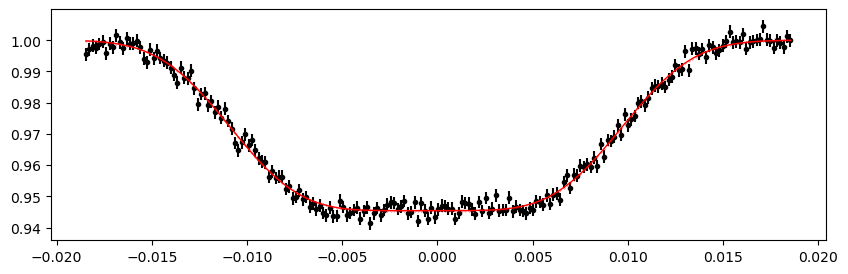

1615.27552 1.0002786053716999 -0.05512143769259481 -0.2766361703541277


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 331.23it/s]


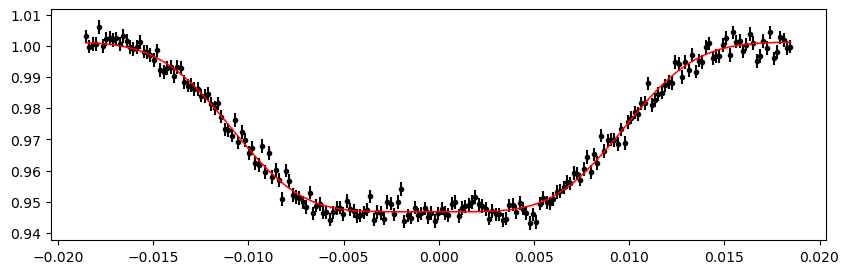

1623.08304 1.0002786053716999 -0.05512143769259481 -0.2766361703541277


100%|███████████████████████████████████████████████████████| 10000/10000 [00:32<00:00, 305.48it/s]


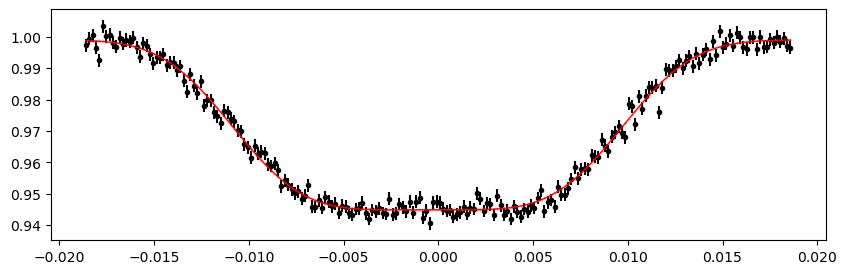

1630.8905599999998 1.0002786053716999 -0.05512143769259481 -0.2766361703541277


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 332.07it/s]


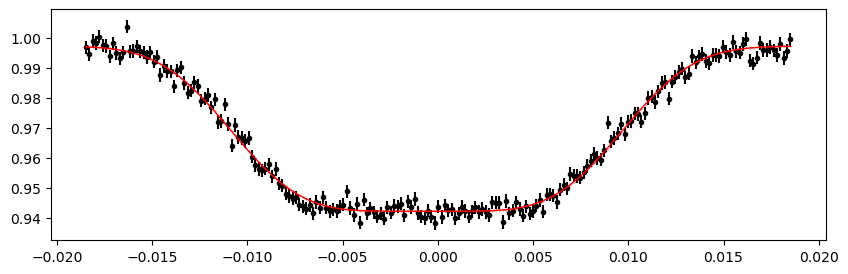

1638.69808 1.0002786053716999 -0.05512143769259481 -0.2766361703541277


100%|███████████████████████████████████████████████████████| 10000/10000 [00:33<00:00, 297.88it/s]


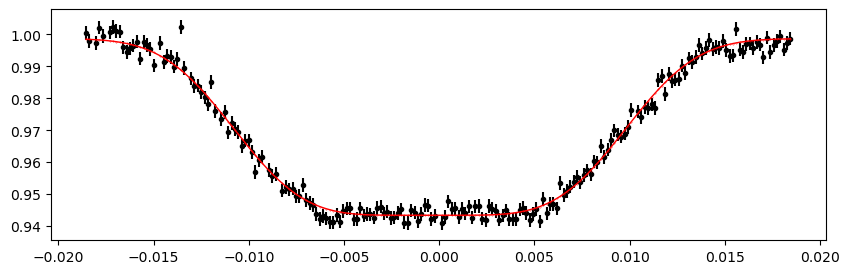

1646.5056 1.0002786053716999 -0.05512143769259481 -0.2766361703541277


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 319.61it/s]


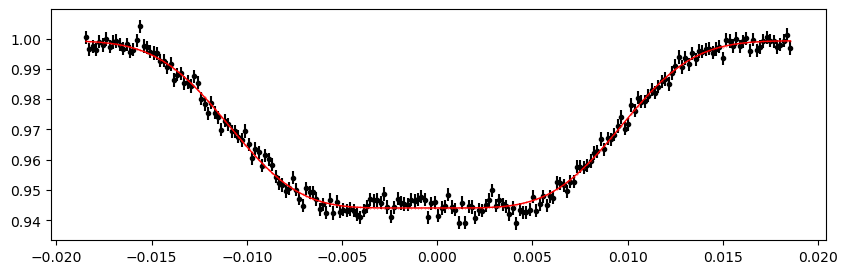

1654.3131199999998 1.0002786053716999 -0.05512143769259481 -0.2766361703541277


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 371.57it/s]


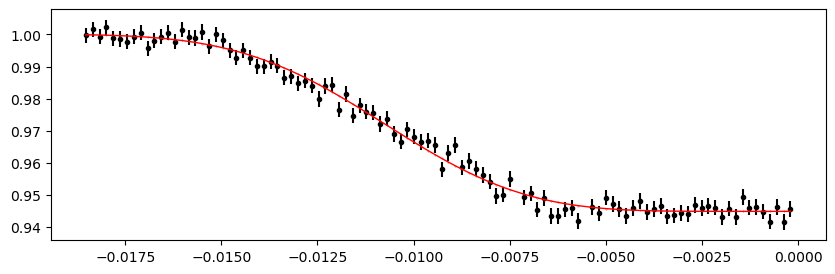

1662.1206399999999 1.0002786053716999 -0.05512143769259481 -0.2766361703541277


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 325.97it/s]


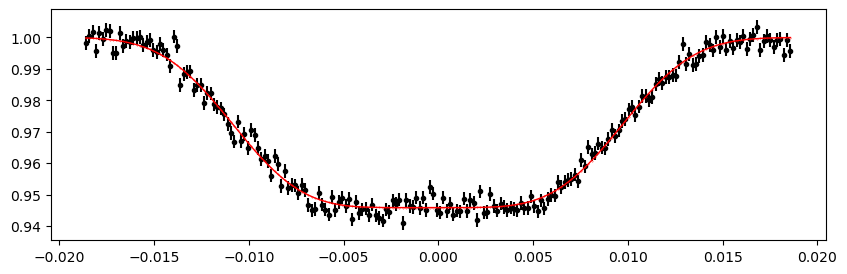

1669.92816 1.0002786053716999 -0.05512143769259481 -0.2766361703541277


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 323.55it/s]


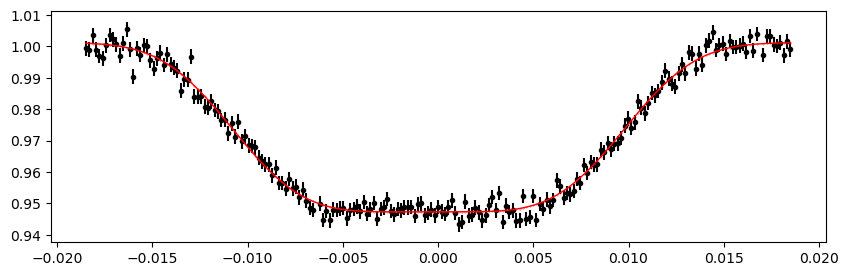

1677.73568 1.0002786053716999 -0.05512143769259481 -0.2766361703541277


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 322.73it/s]


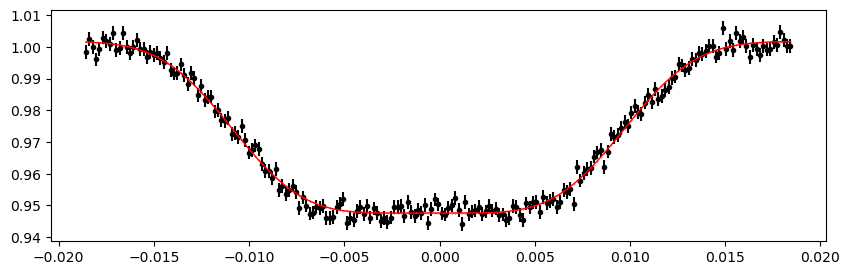

2036.8816 1.0002786053716999 -0.05512143769259481 -0.2766361703541277


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 416.15it/s]


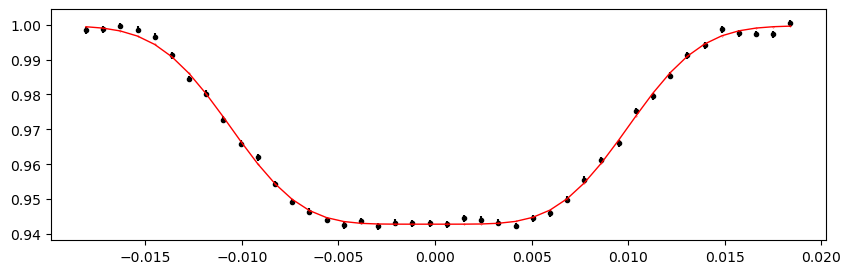

2044.68912 1.0002786053716999 -0.05512143769259481 -0.2766361703541277


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 416.40it/s]


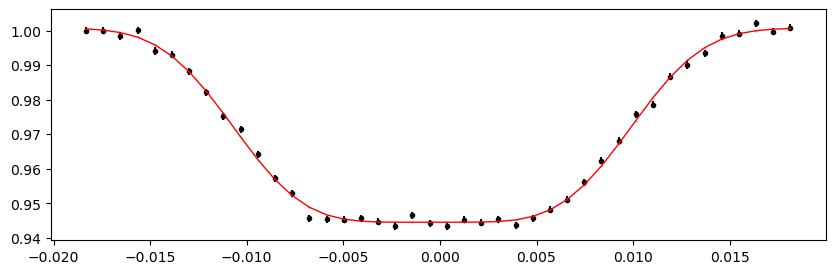

2052.49664 1.0002786053716999 -0.05512143769259481 -0.2766361703541277


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 418.17it/s]


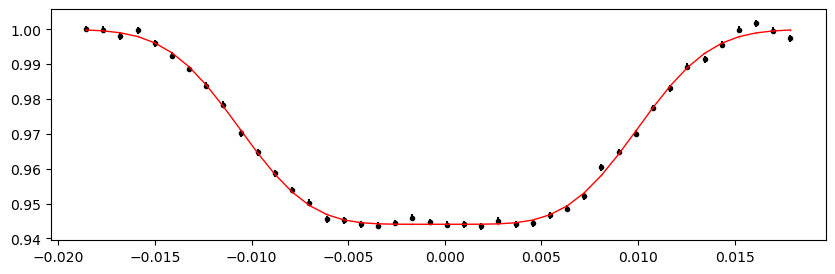

2068.11168 1.0002786053716999 -0.05512143769259481 -0.2766361703541277


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 416.23it/s]


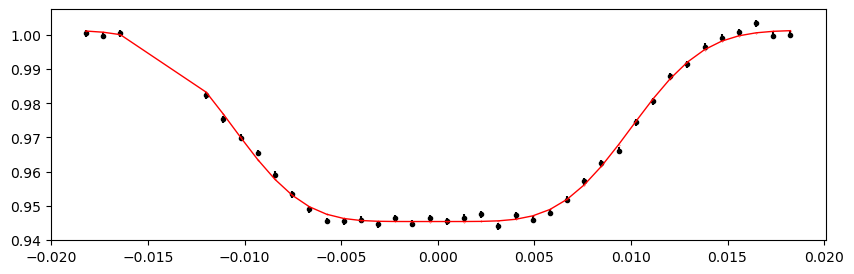

2075.9192 1.0002786053716999 -0.05512143769259481 -0.2766361703541277


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 414.90it/s]


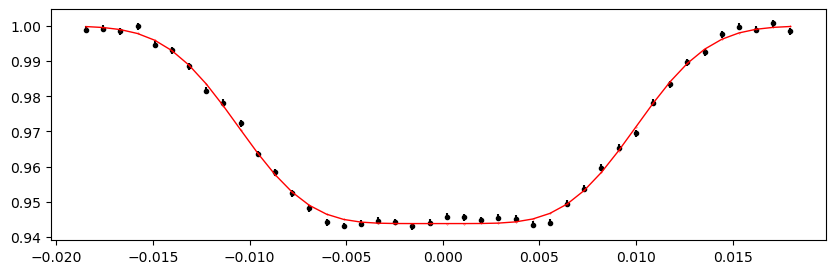

2083.7267199999997 1.0002786053716999 -0.05512143769259481 -0.2766361703541277


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 412.45it/s]


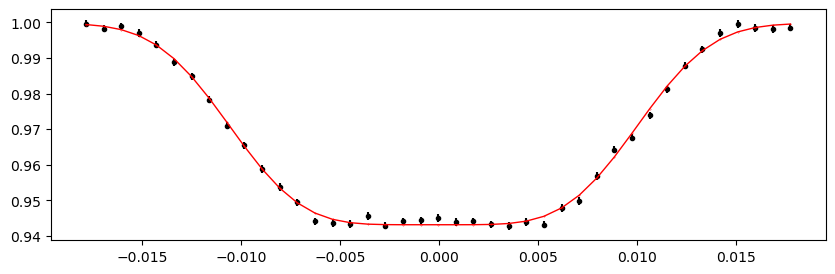

2091.53424 1.0002786053716999 -0.05512143769259481 -0.2766361703541277


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 416.85it/s]


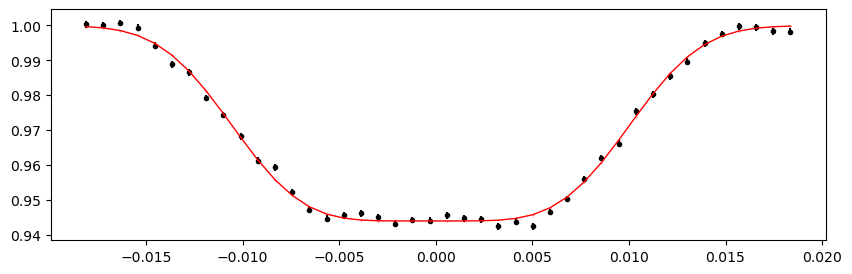

2107.14928 1.0002786053716999 -0.05512143769259481 -0.2766361703541277


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 407.19it/s]


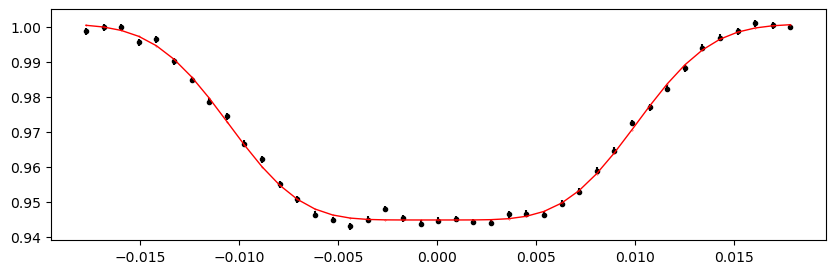

2122.7643199999998 1.0002786053716999 -0.05512143769259481 -0.2766361703541277


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 409.15it/s]


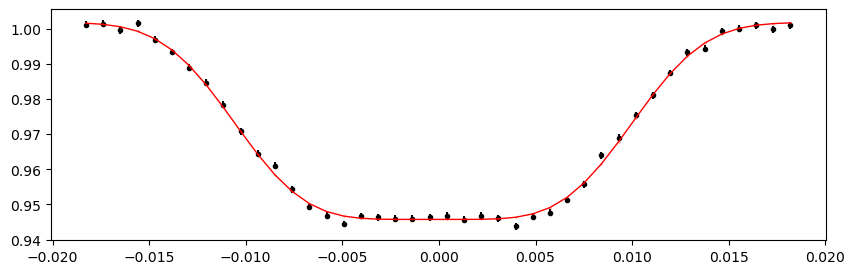

2130.57184 1.0002786053716999 -0.05512143769259481 -0.2766361703541277


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 412.99it/s]


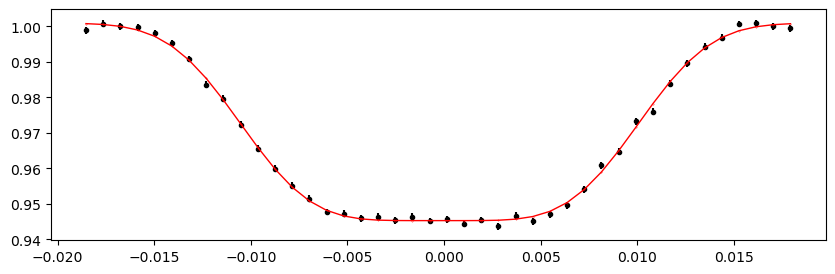

2138.37936 1.0002786053716999 -0.05512143769259481 -0.2766361703541277


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 412.02it/s]


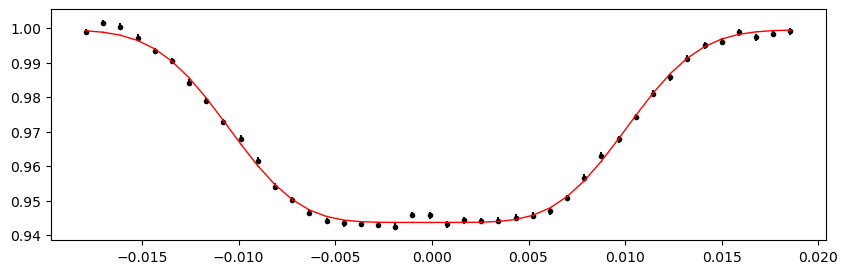

2146.18688 1.0002786053716999 -0.05512143769259481 -0.2766361703541277


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 414.21it/s]


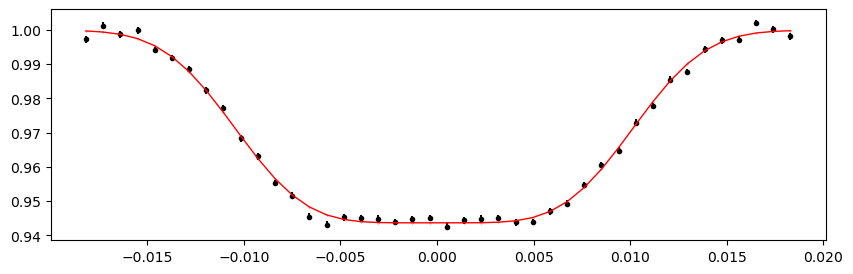

2153.9944 1.0002786053716999 -0.05512143769259481 -0.2766361703541277


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 416.36it/s]


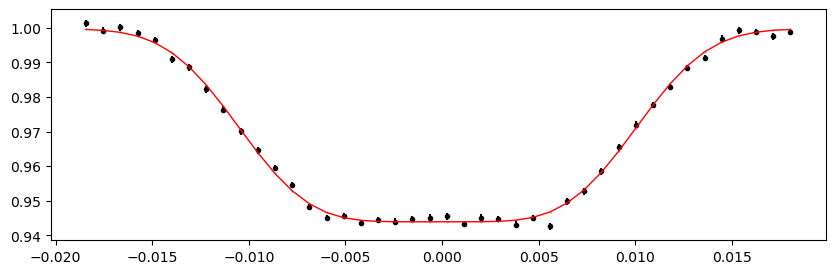

2161.80192 1.0002786053716999 -0.05512143769259481 -0.2766361703541277


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 414.71it/s]


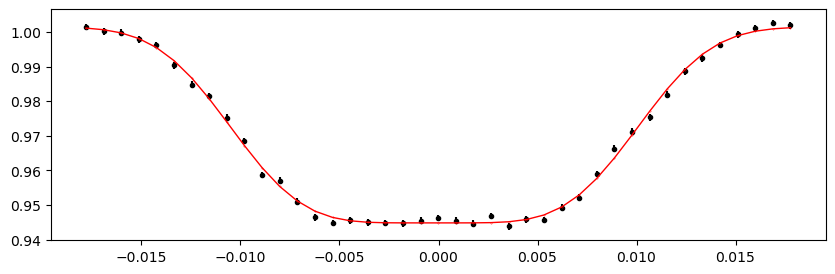

2169.60944 1.0002786053716999 -0.05512143769259481 -0.2766361703541277


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 401.88it/s]


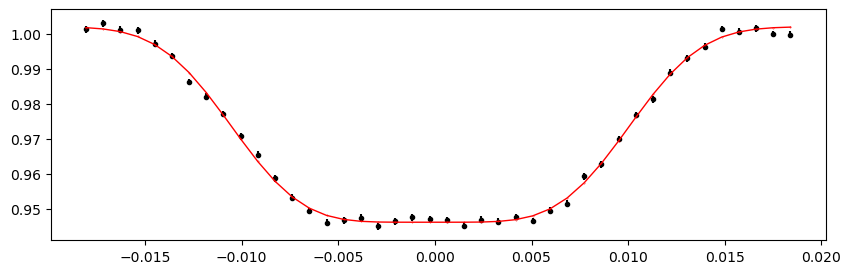

2177.41696 1.0002786053716999 -0.05512143769259481 -0.2766361703541277


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 418.03it/s]


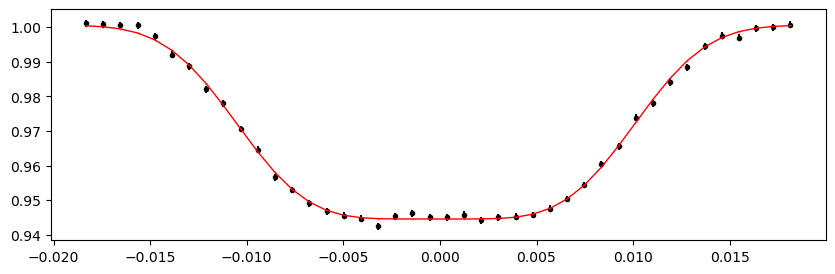

2185.22448 1.0002786053716999 -0.05512143769259481 -0.2766361703541277


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 410.56it/s]


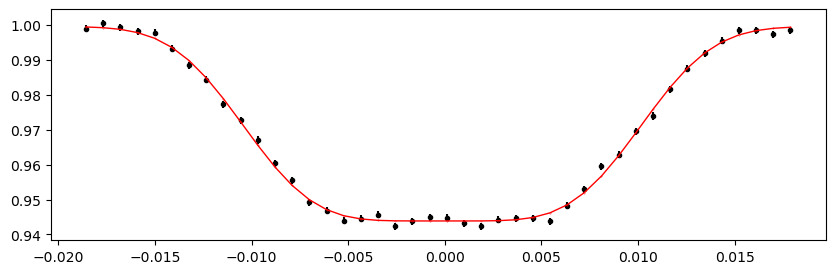

2193.032 1.0002786053716999 -0.05512143769259481 -0.2766361703541277


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 414.68it/s]


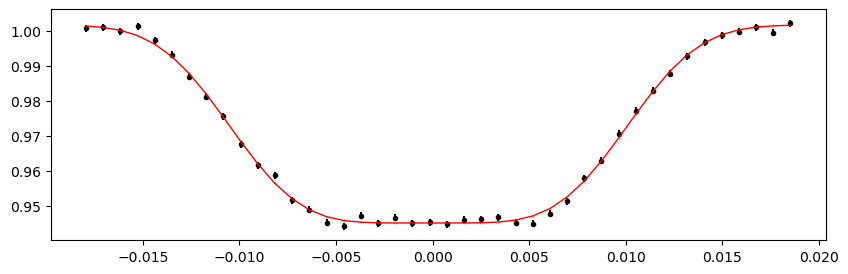

2208.64704 1.0002786053716999 -0.05512143769259481 -0.2766361703541277


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 403.05it/s]


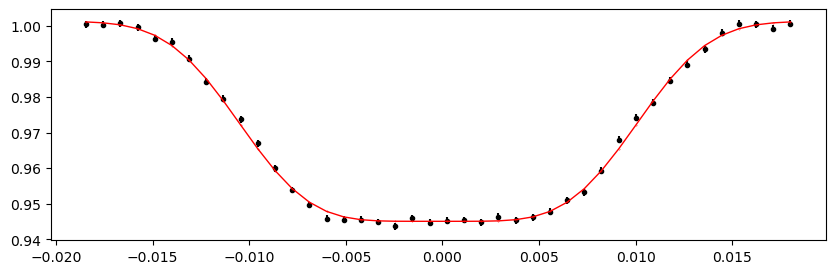

2216.45456 1.0002786053716999 -0.05512143769259481 -0.2766361703541277


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 413.52it/s]


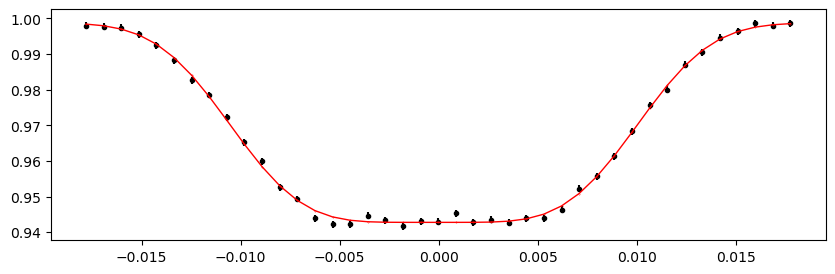

2224.26208 1.0002786053716999 -0.05512143769259481 -0.2766361703541277


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 406.73it/s]


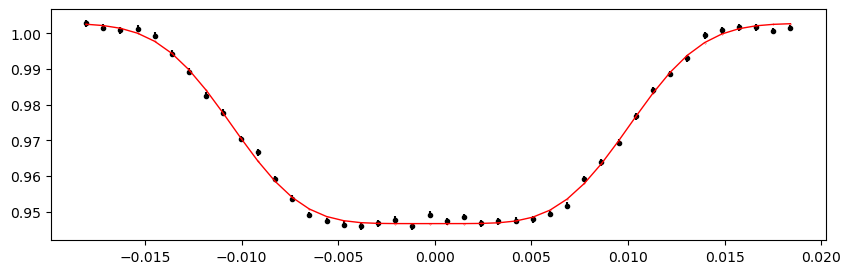

2232.0696 1.0002786053716999 -0.05512143769259481 -0.2766361703541277


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 420.31it/s]


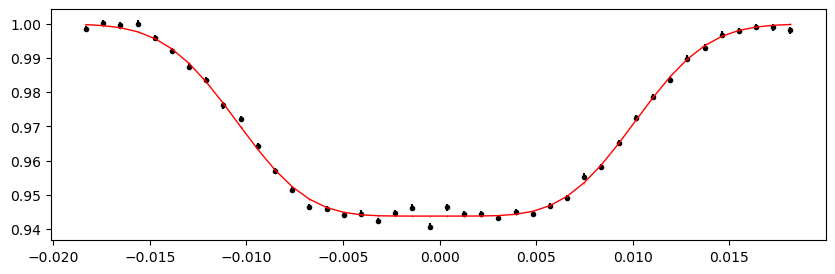

2239.87712 1.0002786053716999 -0.05512143769259481 -0.2766361703541277


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 409.92it/s]


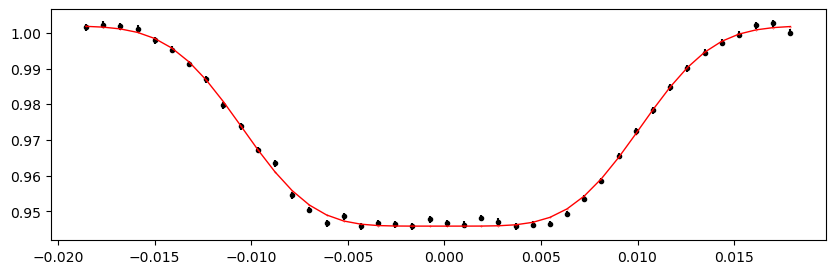

2247.68464 1.0002786053716999 -0.05512143769259481 -0.2766361703541277


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 414.44it/s]


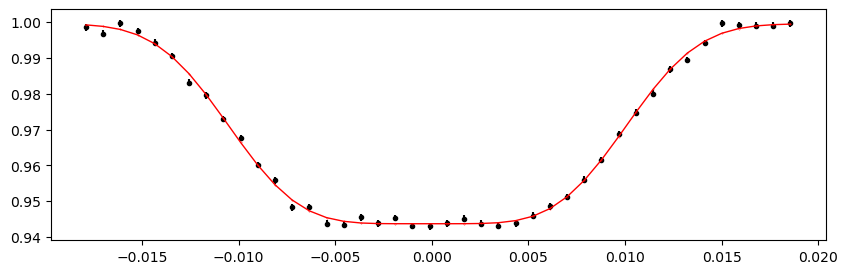

2263.29968 1.0002786053716999 -0.05512143769259481 -0.2766361703541277


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 412.82it/s]


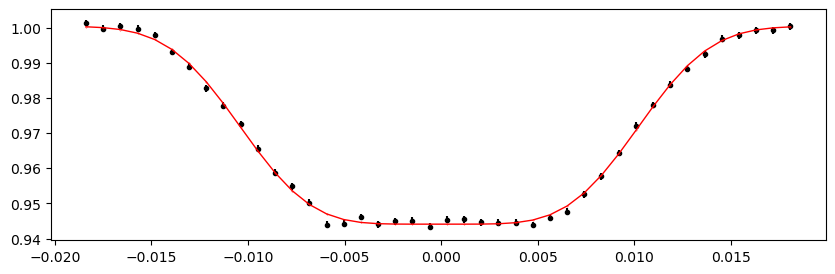

2278.9147199999998 1.0002786053716999 -0.05512143769259481 -0.2766361703541277


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 411.58it/s]


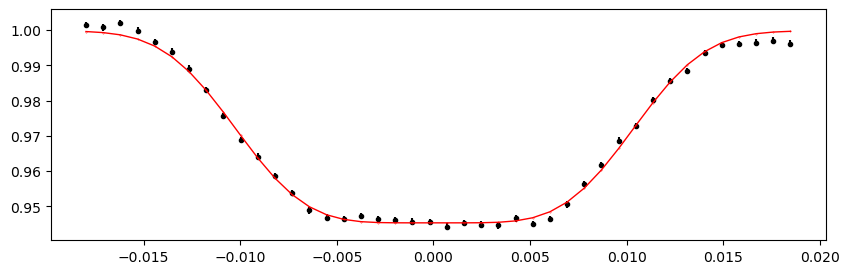

2310.1448 1.0002786053716999 -0.05512143769259481 -0.2766361703541277


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 414.95it/s]


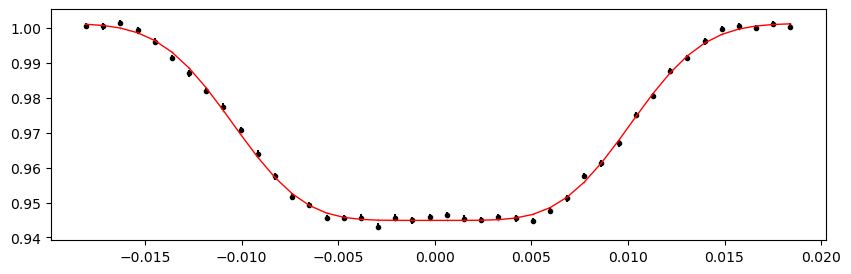

2317.95232 1.0002786053716999 -0.05512143769259481 -0.2766361703541277


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 415.97it/s]


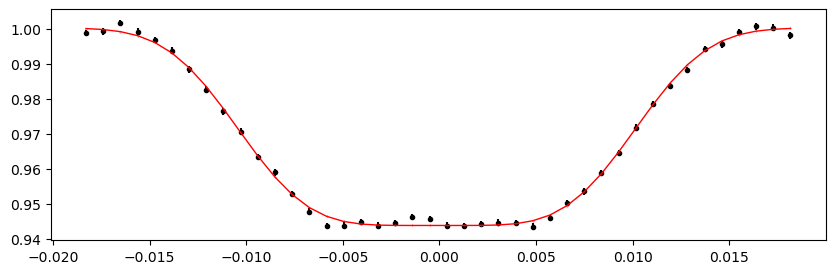

2325.7598399999997 1.0002786053716999 -0.05512143769259481 -0.2766361703541277


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 411.45it/s]


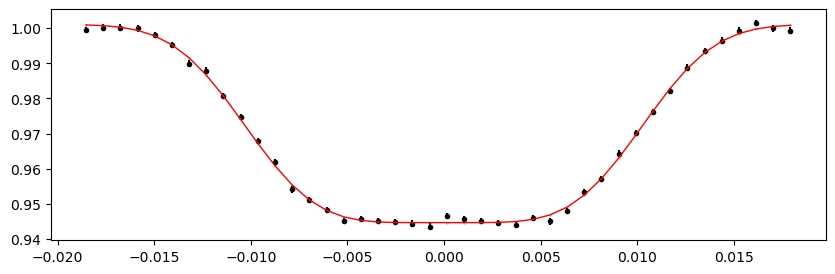

2341.37488 1.0002786053716999 -0.05512143769259481 -0.2766361703541277


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 408.38it/s]


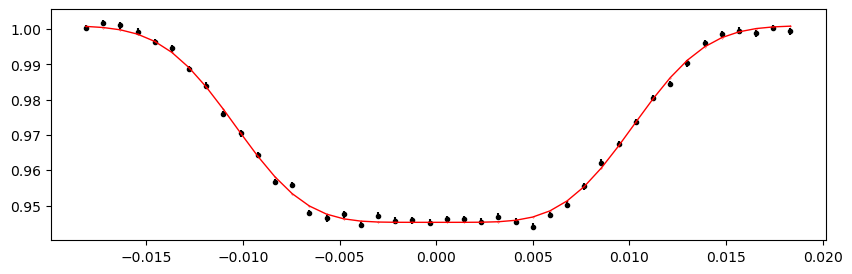

2349.1823999999997 1.0002786053716999 -0.05512143769259481 -0.2766361703541277


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 414.01it/s]


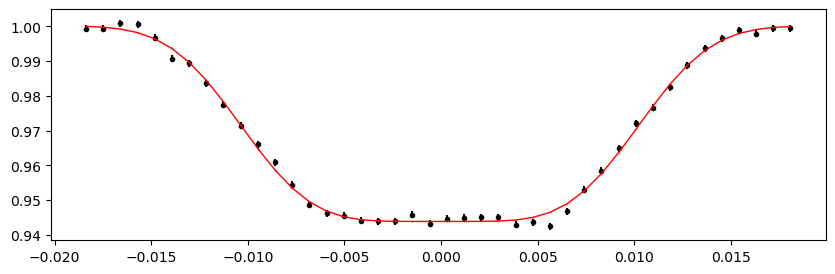

2356.98992 1.0002786053716999 -0.05512143769259481 -0.2766361703541277


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 418.57it/s]


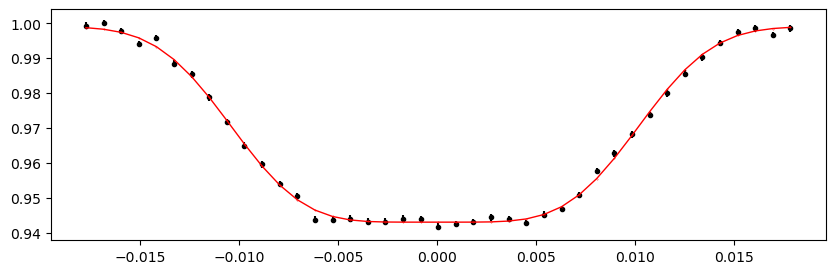

2364.7974400000003 1.0002786053716999 -0.05512143769259481 -0.2766361703541277


100%|███████████████████████████████████████████████████████| 10000/10000 [00:24<00:00, 414.65it/s]


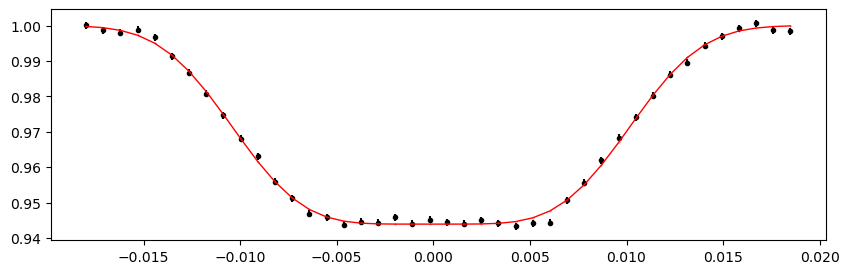

2372.6049599999997 1.0002786053716999 -0.05512143769259481 -0.2766361703541277


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 416.91it/s]


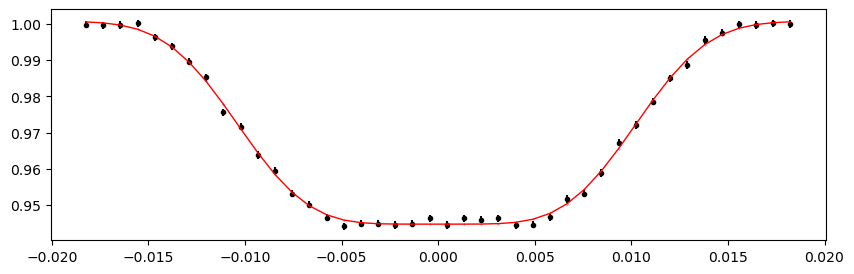

2380.41248 1.0002786053716999 -0.05512143769259481 -0.2766361703541277


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 419.39it/s]


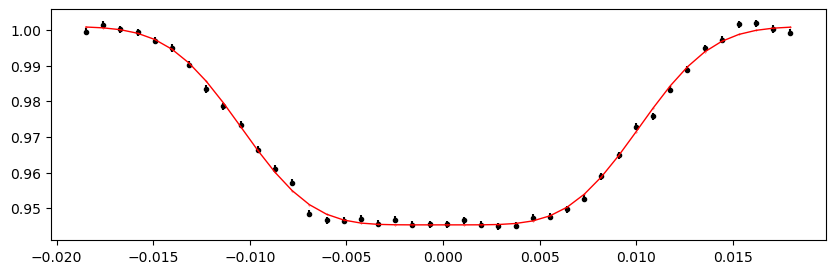

2388.2200000000003 1.0002786053716999 -0.05512143769259481 -0.2766361703541277


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 420.57it/s]


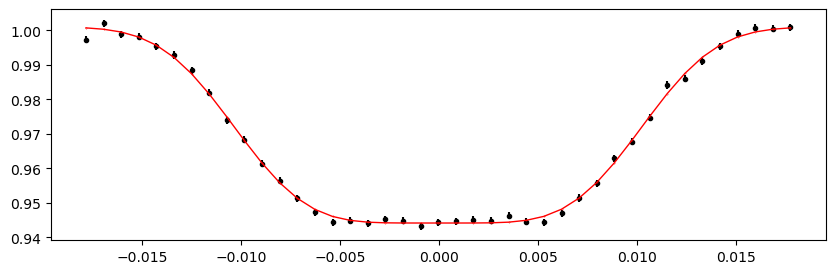

2965.9764800000003 1.0002786053716999 -0.05512143769259481 -0.2766361703541277


100%|███████████████████████████████████████████████████████| 10000/10000 [00:35<00:00, 282.34it/s]


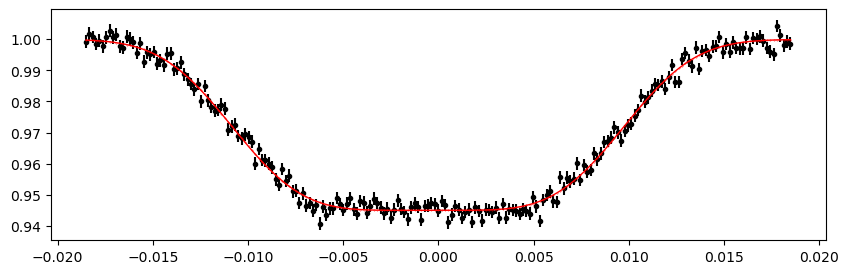

2973.7839999999997 1.0002786053716999 -0.05512143769259481 -0.2766361703541277


100%|███████████████████████████████████████████████████████| 10000/10000 [00:33<00:00, 300.50it/s]


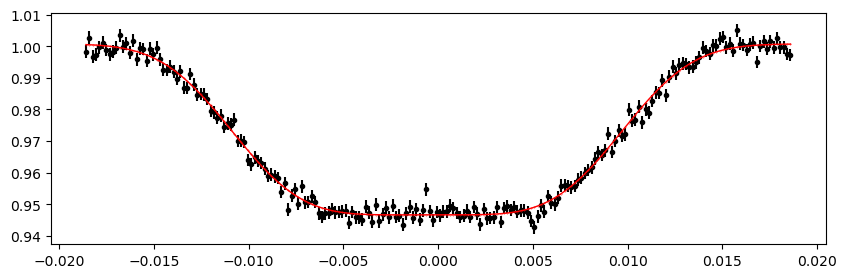

2981.59152 1.0002786053716999 -0.05512143769259481 -0.2766361703541277


100%|███████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 338.16it/s]


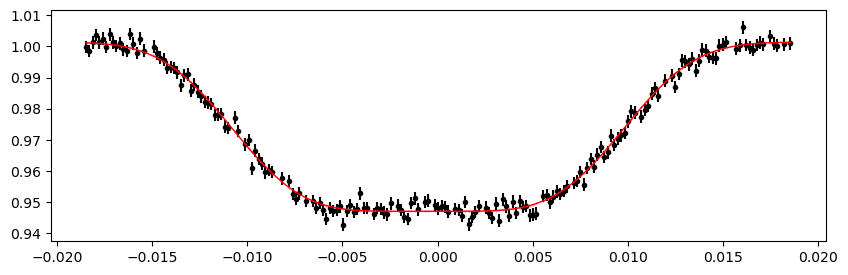

2997.2065599999996 1.0002786053716999 -0.05512143769259481 -0.2766361703541277


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 324.67it/s]


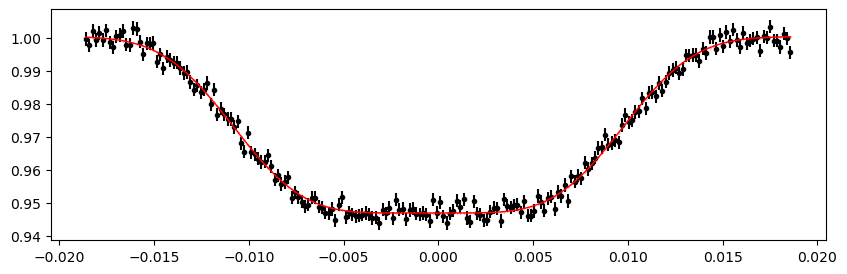

3005.01408 1.0002786053716999 -0.05512143769259481 -0.2766361703541277


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 328.49it/s]


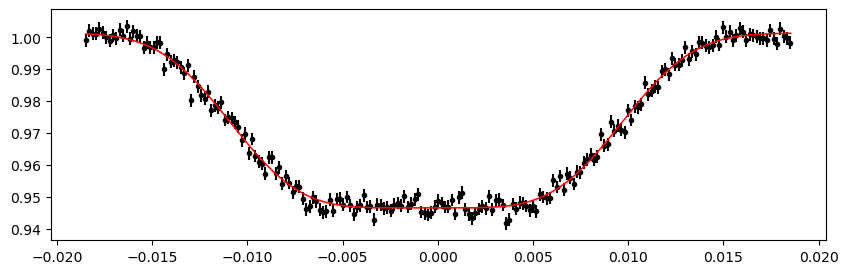

3012.8216 1.0002786053716999 -0.05512143769259481 -0.2766361703541277


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 327.51it/s]


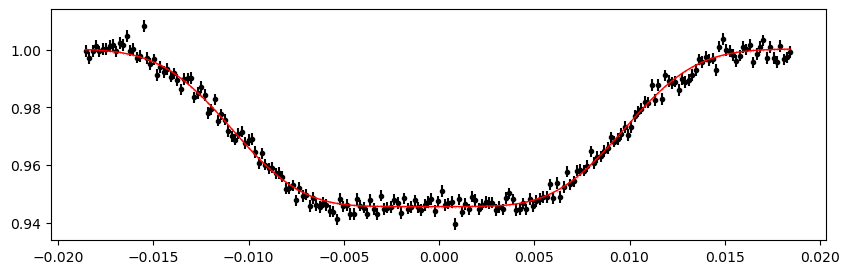

3020.62912 1.0002786053716999 -0.05512143769259481 -0.2766361703541277


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 327.70it/s]


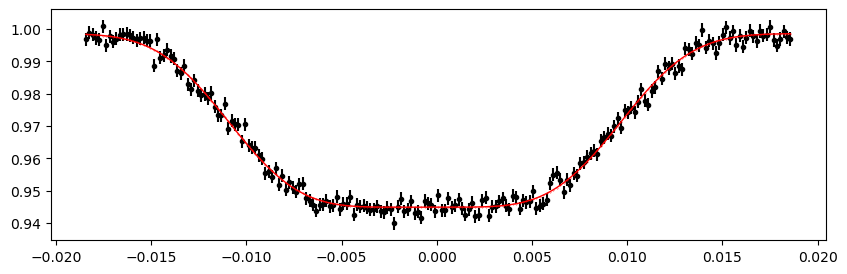

3036.24416 1.0002786053716999 -0.05512143769259481 -0.2766361703541277


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 330.21it/s]


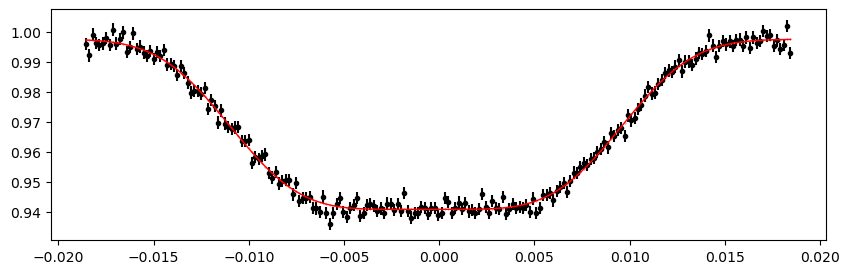

3044.05168 1.0002786053716999 -0.05512143769259481 -0.2766361703541277


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 324.93it/s]


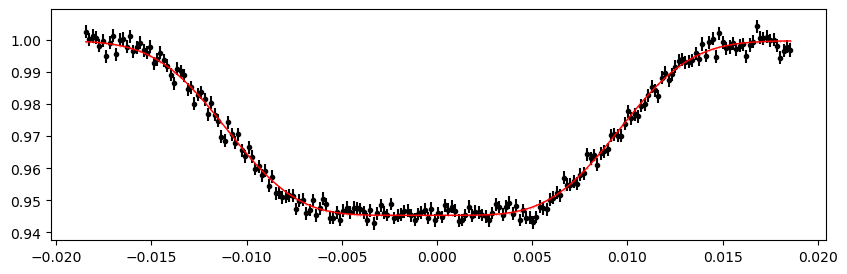

3051.8592 1.0002786053716999 -0.05512143769259481 -0.2766361703541277


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 321.70it/s]


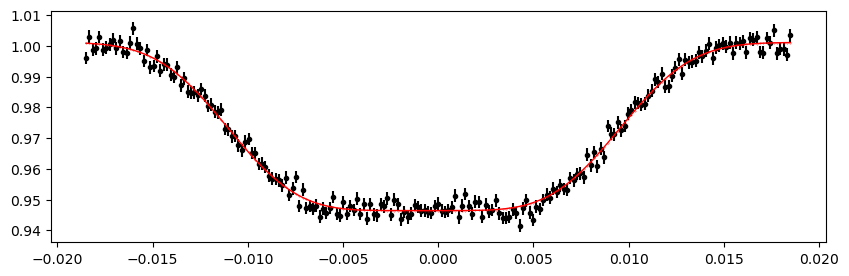

3059.66672 1.0002786053716999 -0.05512143769259481 -0.2766361703541277


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 322.23it/s]


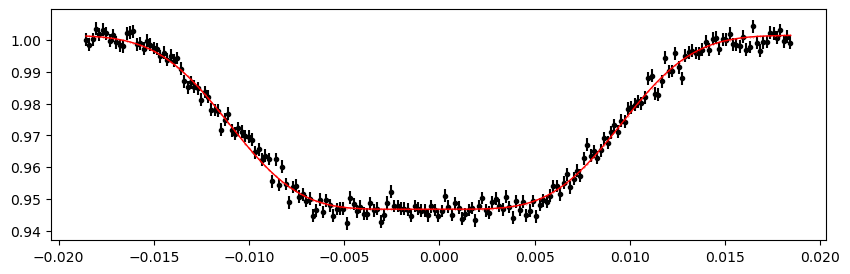

3067.47424 1.0002786053716999 -0.05512143769259481 -0.2766361703541277


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 323.14it/s]


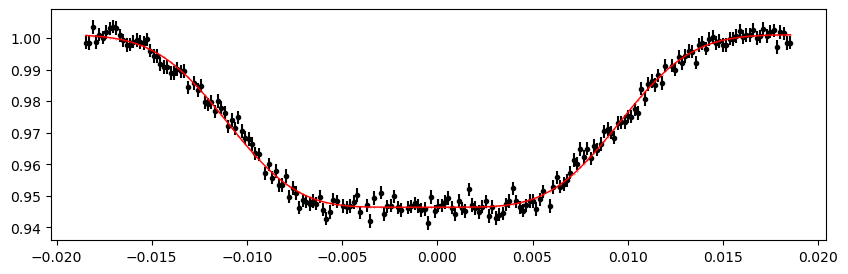

3075.28176 1.0002786053716999 -0.05512143769259481 -0.2766361703541277


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 325.05it/s]


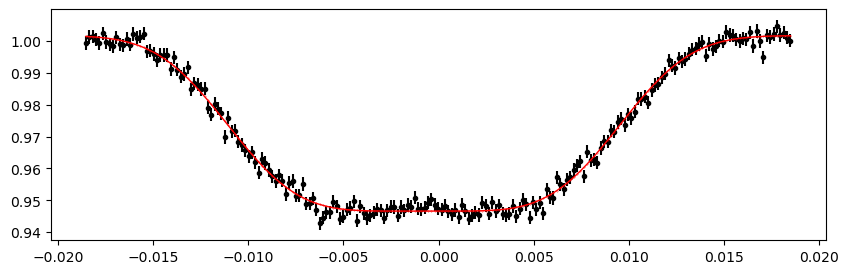

3083.08928 1.0002786053716999 -0.05512143769259481 -0.2766361703541277


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 326.27it/s]


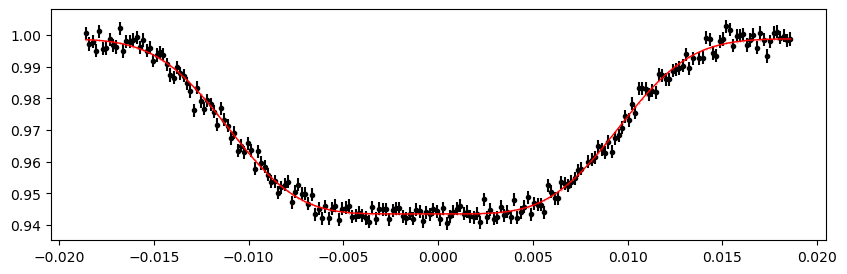

3090.8968 1.0002786053716999 -0.05512143769259481 -0.2766361703541277


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 321.55it/s]


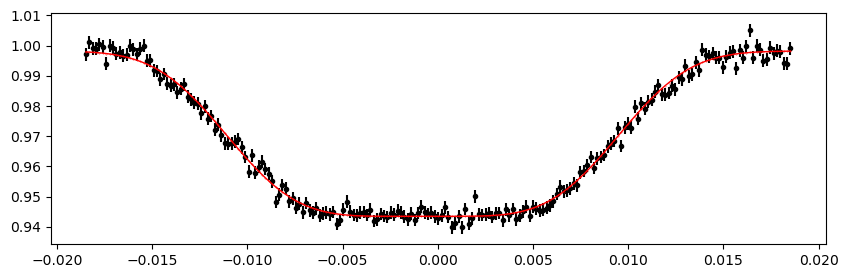

3098.70432 1.0002786053716999 -0.05512143769259481 -0.2766361703541277


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 368.13it/s]


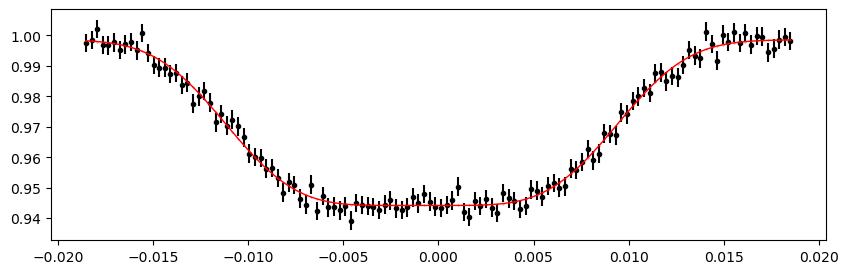

3106.51184 1.0002786053716999 -0.05512143769259481 -0.2766361703541277


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 369.31it/s]


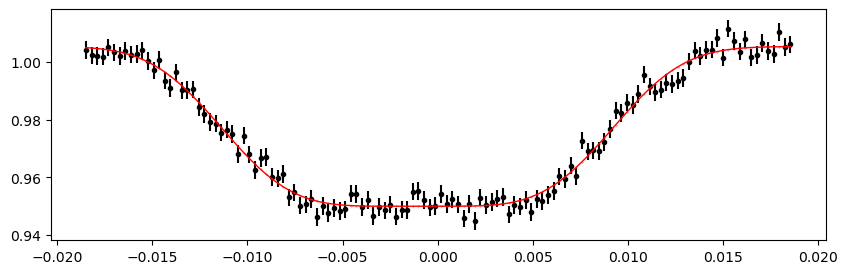

3114.31936 1.0002786053716999 -0.05512143769259481 -0.2766361703541277


100%|███████████████████████████████████████████████████████| 10000/10000 [00:26<00:00, 370.58it/s]


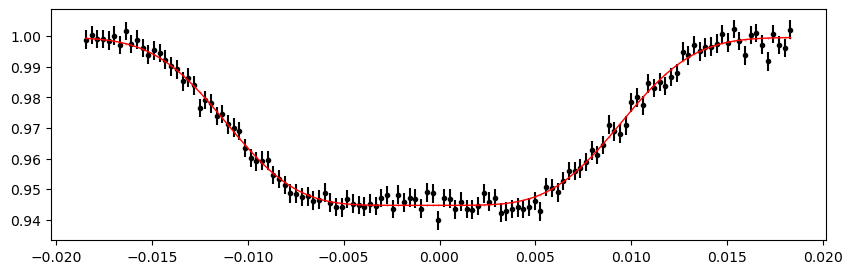

3122.12688 1.0002786053716999 -0.05512143769259481 -0.2766361703541277


100%|███████████████████████████████████████████████████████| 10000/10000 [00:27<00:00, 367.59it/s]


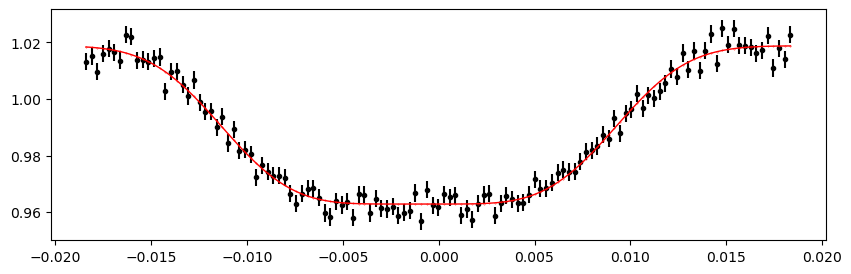

3129.9344 1.0002786053716999 -0.05512143769259481 -0.2766361703541277


100%|███████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 326.16it/s]


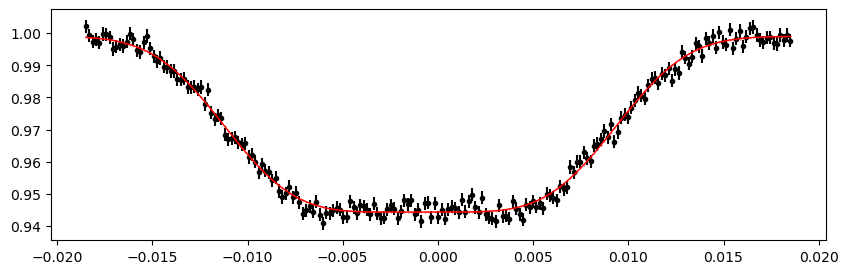

3145.54944 1.0002786053716999 -0.05512143769259481 -0.2766361703541277


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 320.33it/s]


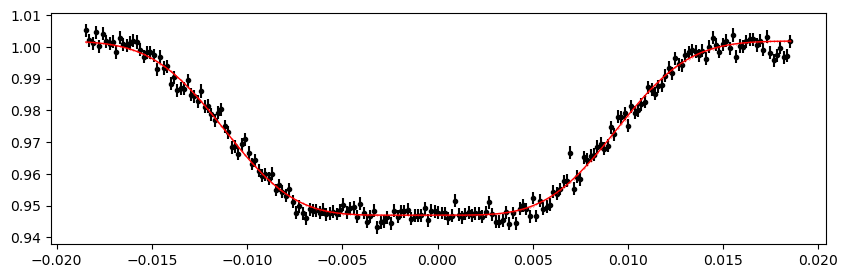

3161.16448 1.0002786053716999 -0.05512143769259481 -0.2766361703541277


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 319.74it/s]


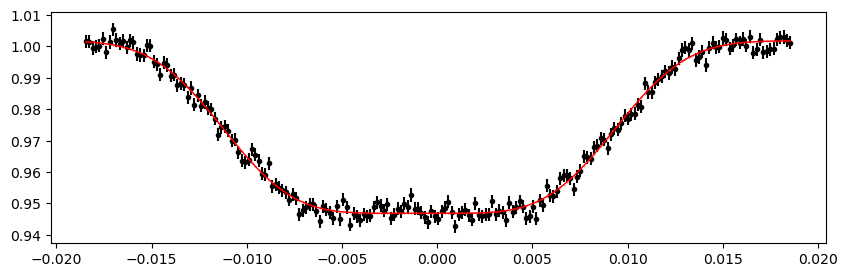

3168.9719999999998 1.0002786053716999 -0.05512143769259481 -0.2766361703541277


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 317.86it/s]


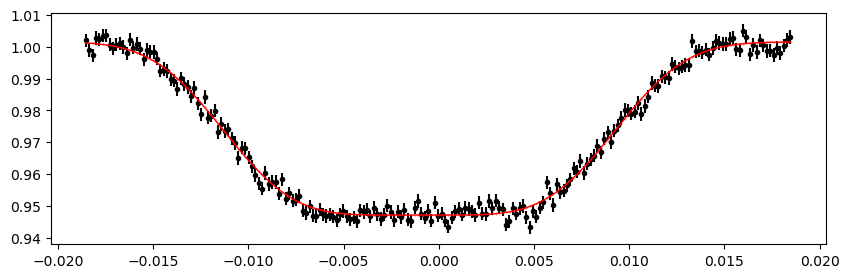

3176.77952 1.0002786053716999 -0.05512143769259481 -0.2766361703541277


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 317.68it/s]


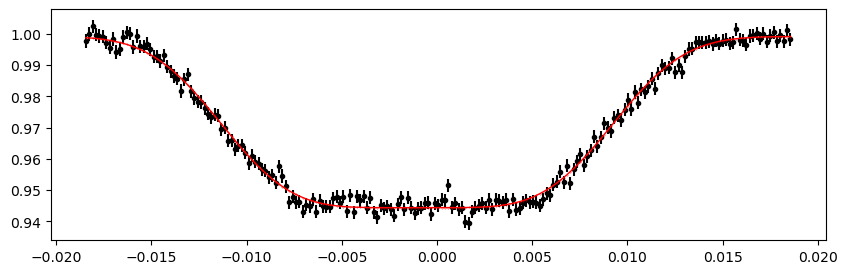

3184.58704 1.0002786053716999 -0.05512143769259481 -0.2766361703541277


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 319.01it/s]


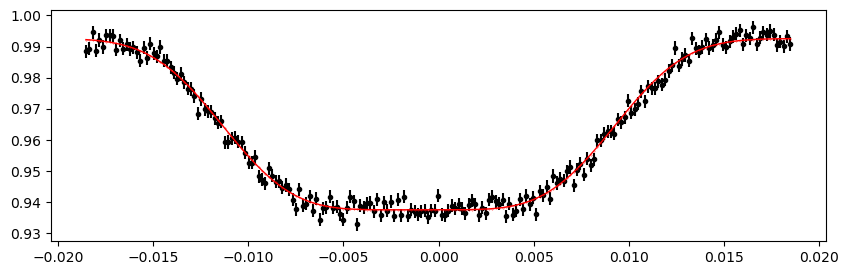

3192.3945599999997 1.0002786053716999 -0.05512143769259481 -0.2766361703541277


100%|███████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 322.26it/s]


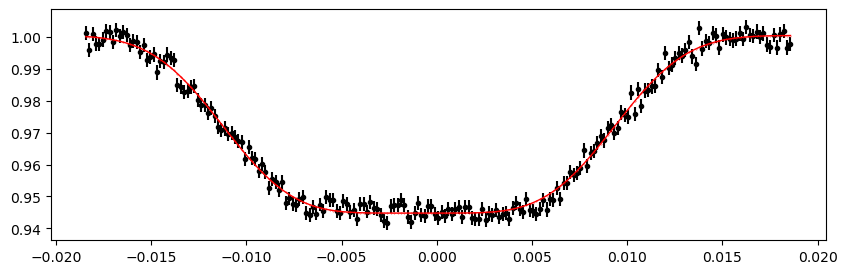

In [37]:
%matplotlib inline

# from importlib import reload
# reload(etv_functions)

print("Fitting individual primary eclipses...")
etv_functions.fit_each_eclipse(data_primary, n_transits, t0_primary, period, mean_alpha0, mean_alpha1, mean_t0, mean_d, mean_Tau, outfile_path,
                               min_number_data=12,   # accomodate long cadence datta
                              )
!$NOTIFY_CMD "Individual primary eclipses fit done"

# ---

%matplotlib inline

if t0_secondary is not None:
    print("Fitting individual secondary eclipses...")
    etv_functions.fit_each_eclipse(data_secondary, n_transits, t0_secondary, period, mean_alpha0_s, mean_alpha1_s, mean_t0_s, mean_d_s, mean_Tau_s, outfile_path_s,
                                   min_number_data=12,   # accomodate long cadence datta
                                  )
    !$NOTIFY_CMD "Individual secondary eclipses fit done"
else:
    print("No secondary eclipses defined. No-Op.")


Fitting individual secondary eclipses...
Creating new manifest file
1326.39728 1.0002786053716999 -0.05512143769259481 -0.2766361703541277


100%|███████████████████████████████████████████████████████| 10000/10000 [00:23<00:00, 432.17it/s]


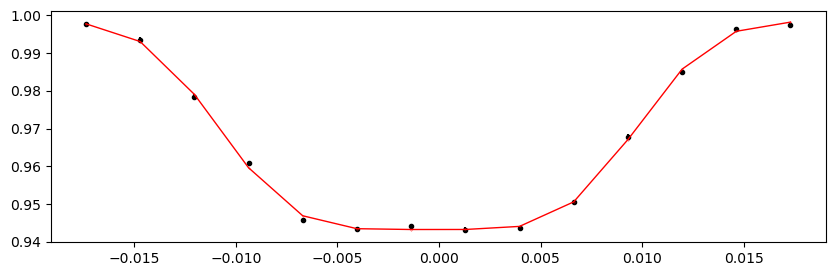

1334.2048 1.0002786053716999 -0.05512143769259481 -0.2766361703541277


 14%|███████▉                                                | 1411/10000 [00:03<00:19, 434.47it/s]


KeyboardInterrupt: 

## ETV O-C plot

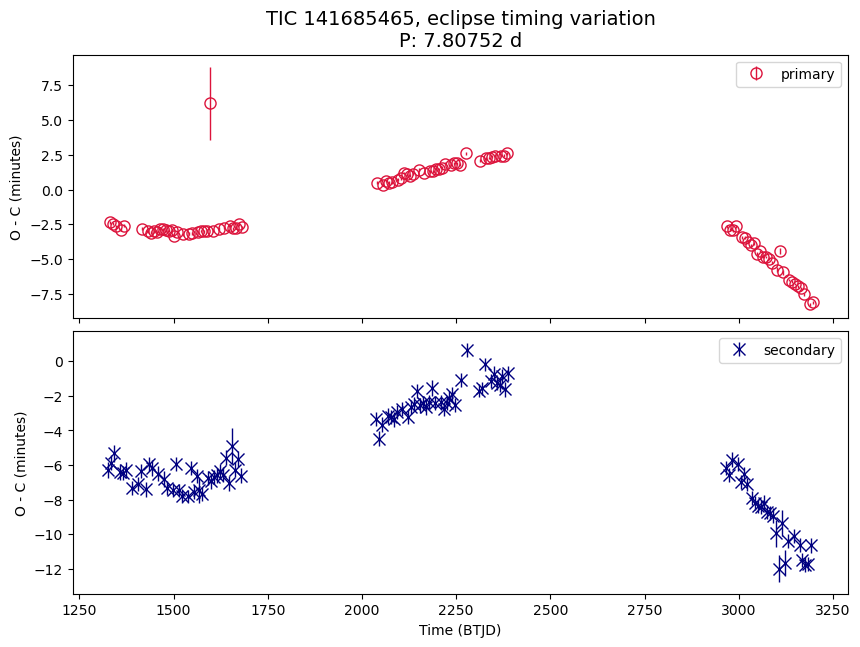

In [38]:
%matplotlib inline
# %matplotlib widget

#plot the extracted transit times to check for ETVs

num_rows = 2 if t0_secondary is not None else 1
figsize_y = 3.3 if num_rows == 1 else num_rows * 3.5
# num_rows = 1  # force to plot primary only
# figsize_y = 3.3

fig, axs = plt.subplots(num_rows, 1, figsize=(10, figsize_y), sharex=True)
if isinstance(axs, plt.Axes):  # handle edge case that num_rows == 1, returned axs is not a list
    axs = [axs]

in_df_primary = pd.read_csv(outfile_path)
in_df_primary['midpoint'] = in_df_primary['epoch'] + (in_df_primary['t0']*period)
in_df_primary['shift_mins'] = in_df_primary['t0']*period*24*60
in_df_primary['std_mins'] = in_df_primary['stdv_t0']*period*24*60

# axs[0].plot(in_df_primary['epoch'], in_df_primary['shift_mins'], 
#              lw = 1, color = 'crimson', )
# axs[0].scatter(in_df_primary['epoch'], in_df_primary['shift_mins'], 
#              marker = 'o', s=8**2, color = 'None', edgecolor = 'crimson', label="primary")
axs[0].errorbar(in_df_primary['epoch'], in_df_primary['shift_mins'], yerr = in_df_primary['std_mins'], 
             lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color = 'None', ecolor='crimson', markeredgecolor = 'crimson', label="primary")

# if False:
if t0_secondary is not None:
    in_df_secondary = pd.read_csv(outfile_path_s)
    in_df_secondary['midpoint'] = in_df_secondary['epoch'] + (in_df_secondary['t0']*period)
    in_df_secondary['shift_mins'] = in_df_secondary['t0']*period*24*60
    in_df_secondary['std_mins'] = in_df_secondary['stdv_t0']*period*24*60
    # axs[1].plot(in_df_secondary['epoch'], in_df_secondary['shift_mins'],
    #              lw = 1, color = 'navy', )
    # axs[1].scatter(in_df_secondary['epoch'], in_df_secondary['shift_mins'],
    #              marker = 'x',  s=9**2, color = 'navy', zorder = -2, label="secondary" );
    axs[1].errorbar(in_df_secondary['epoch'], in_df_secondary['shift_mins'], yerr = in_df_secondary['std_mins'], 
                 lw = 0, marker = 'x', elinewidth = 1, markersize = 9, color = 'navy', zorder = -2, label="secondary" );
else:
    in_df_secondary = None

for ax in axs:
    ax.set_ylabel("O - C (minutes)")
    ax.legend();

axs[-1].set_xlabel(f"Time ({search_result.time.format.upper()})")
axs[0].set_title(f"TIC {ticid}, eclipse timing variation\nP: {period} d", fontsize=14)

plt.subplots_adjust(hspace=0.05)
# plt.ylim(-3, 8)
plt.show()

### O-C Plot, Zoom In

Most data have cadences in 10min or less, with the exception of first three sectors (BTJD 1325 - 1407)

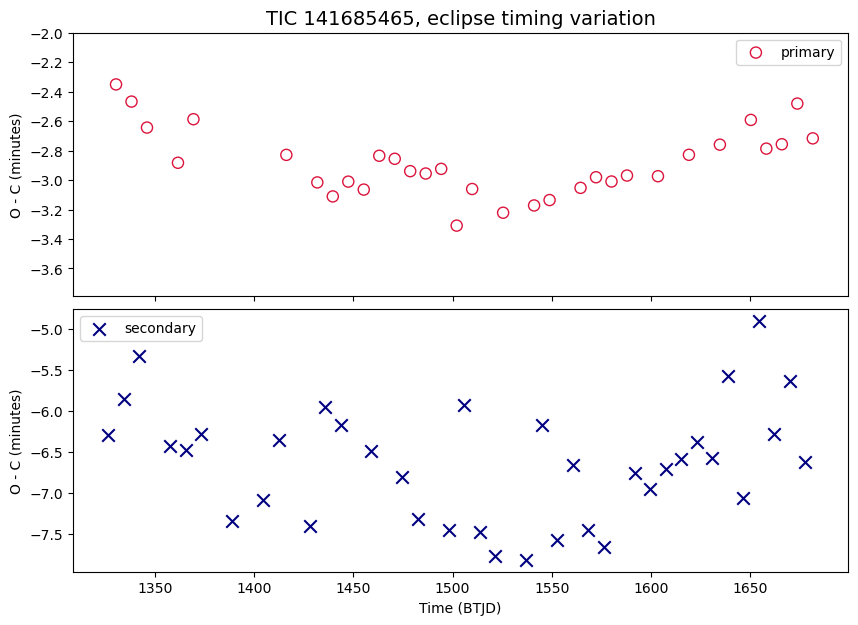

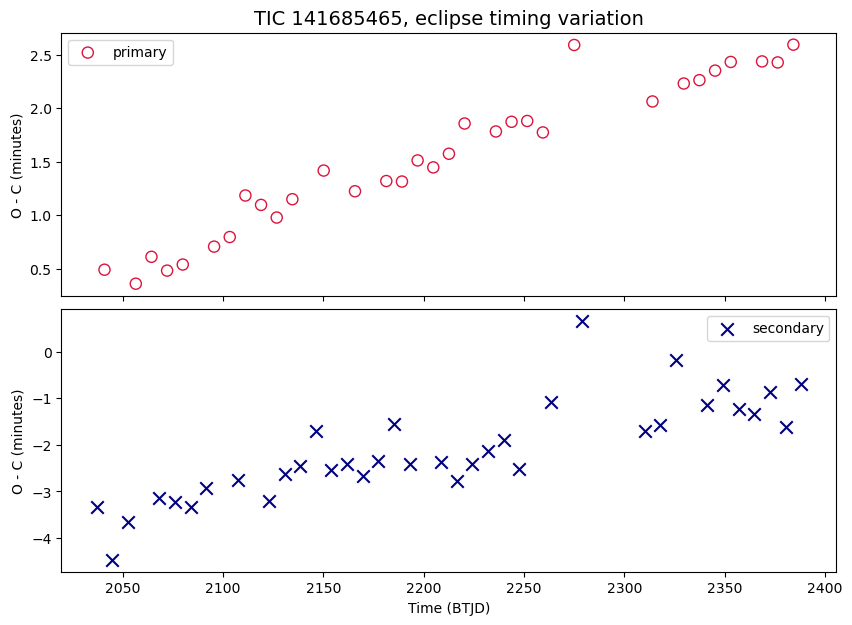

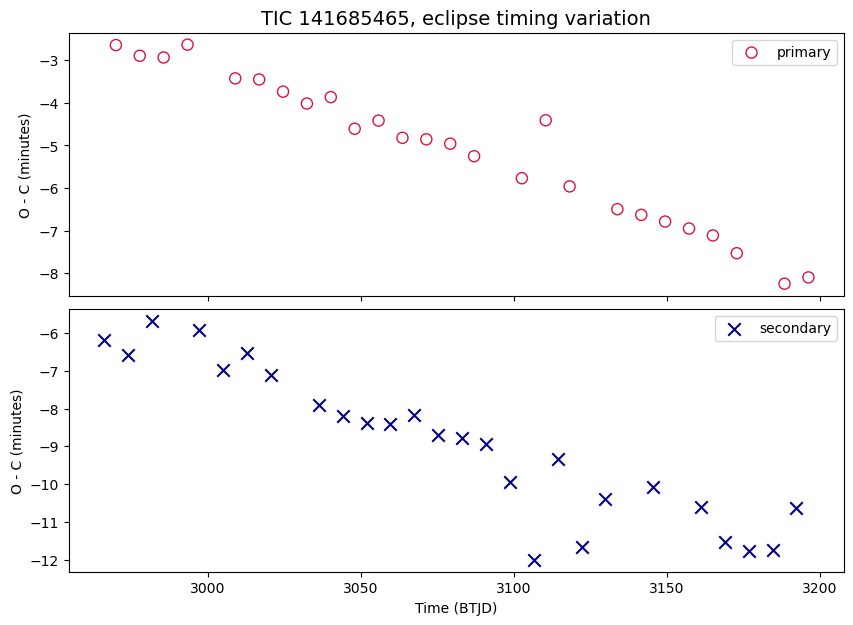

In [42]:
%matplotlib inline
# %matplotlib widget

zoom_ranges = [
    (1200, 1750),
    (2000, 2500),
    (2800, 3250),
]
title_suffix = "eclipse timing variation"

def tweak_axs_list(axs_list):
    axs_list[0][0].set_ylim(None, -2);
    # axs_list[1][0].set_ylim(None, 0.5);
    # axs_list[1][1].set_ylim(-5.5, 2);

    # ax = axs_list[0][0]
    # ax.set_title(f"{ax.get_title()} (2min cadence)")
    # ax = axs_list[1][0]
    # ax.set_title(f"{ax.get_title()} (2min cadence)")
    
    pass


def plot_oc_in_zoom_ranges(in_df_primary, in_df_secondary, zoom_ranges):
    axs_list = []
    for zoom_start, zoom_end in zoom_ranges:
        num_rows = 2 if t0_secondary is not None else 1
        figsize_y = 3.3 if num_rows == 1 else num_rows * 3.5
    
        fig, axs = plt.subplots(num_rows, 1, figsize=(10, figsize_y), sharex=True)
        if isinstance(axs, plt.Axes):  # handle edge case that num_rows == 1, returned axs is not a list
            axs = [axs]
        
        df_zoom = in_df_primary[(in_df_primary['epoch'] > zoom_start) & (in_df_primary['epoch'] < zoom_end)]
              
        axs[0].scatter(df_zoom['epoch'], df_zoom['shift_mins'], 
                       marker = 'o', s=8**2, color = 'None', edgecolor = 'crimson', label="primary")
        # axs[0].errorbar(df_zoom['epoch'], df_zoom['shift_mins'], yerr = df_zoom['std_mins'], 
        #                 lw = 0, marker = 'o', elinewidth = 1, markersize = 8, color = 'None', ecolor='crimson', markeredgecolor = 'crimson', label="primary")
        
        if in_df_secondary is not None:
            df_zoom = in_df_secondary[(in_df_secondary['epoch'] > zoom_start) & (in_df_secondary['epoch'] < zoom_end)]
        
            axs[1].scatter(df_zoom['epoch'], df_zoom['shift_mins'],
                           marker = 'x',  s=9**2, color = 'navy', zorder = -2, label="secondary" );
            # axs[1].errorbar(df_zoom['epoch'], df_zoom['shift_mins'], yerr = df_zoom['std_mins'],
            #                 lw = 0, marker = 'x', elinewidth = 1, markersize = 9, color = 'navy', zorder = -2, label="secondary" );
        
        for ax in axs:
            ax.set_ylabel("O - C (minutes)")
            ax.legend();
        
        axs[-1].set_xlabel("Time (BTJD)")
        axs[0].set_title(f"TIC {ticid}, {title_suffix}", fontsize=14)
        
        plt.subplots_adjust(hspace=0.05)
        axs_list.append(axs)
    return axs_list


axs_list = plot_oc_in_zoom_ranges(in_df_primary, in_df_secondary, zoom_ranges)
tweak_axs_list(axs_list);

## make a periodogram 

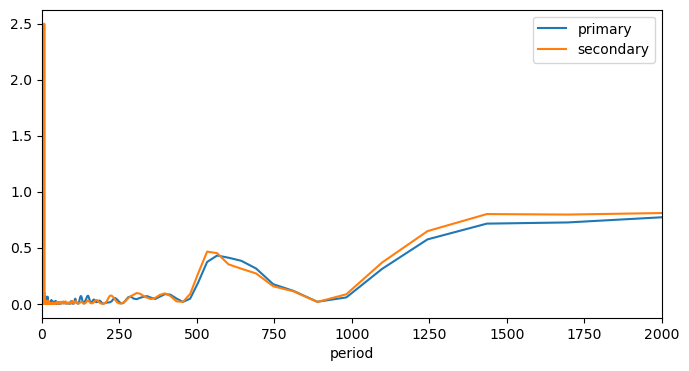

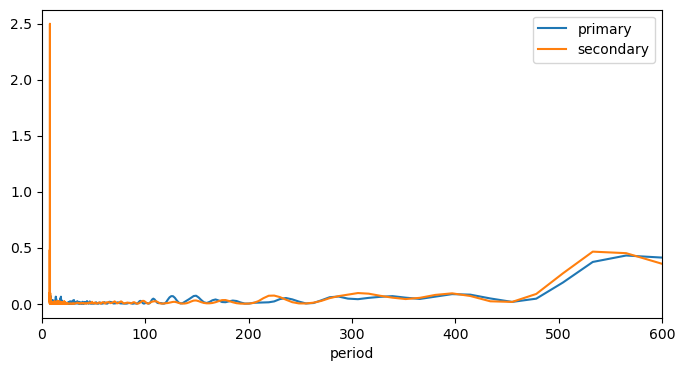

In [45]:
frequency, power = LombScargle(in_df_primary['epoch'], in_df_primary['shift_mins']).autopower()

fig, ax = plt.subplots(figsize=(8, 4))

plt.plot(1/frequency, power, label = 'primary')    

if t0_secondary is not None:
    frequency_s, power_s = LombScargle(in_df_secondary['epoch'], in_df_secondary['shift_mins']).autopower()
    plt.plot(1/frequency_s, power_s, label = 'secondary')    

plt.xlabel("period")

plt.legend()
plt.xlim(0, 2000)
plt.show()


if True:
    fig, ax = plt.subplots(figsize=(8, 4))
    
    plt.plot(1/frequency, power, label = 'primary')    
    
    if t0_secondary is not None:
        frequency_s, power_s = LombScargle(in_df_secondary['epoch'], in_df_secondary['shift_mins']).autopower()
        plt.plot(1/frequency_s, power_s, label = 'secondary')    
    
    plt.xlabel("period")
    
    plt.legend()
    plt.xlim(0, 600)
    plt.show()

## Results Summary

In [46]:
# FILL-IN the ETV results / comments
has_etv = "Y"
comments = "O-C suggests long-term (2000+ days) non-linear trend, amplitude ~10min, for both primary and secondary eclipses"

# Eclipse depth from the model
depth_pct_p = round(-mean_alpha1 * 100, 2)
if t0_secondary is not None:
    depth_pct_s = round(-mean_alpha1_s * 100, 2)
else:
    depth_pct_s = None

summary = {
    "tic": ticid,
    "has_etv": has_etv,
    "comments": comments,
    "period": period,  # the period used in ETV analysis
    "depth_pct_p": depth_pct_p,
    "depth_pct_s": depth_pct_s,
    "epoch_p": t0_primary,
    "epoch_s": t0_secondary,
    "num_sectors": len(sr),
    "time_span": round(time[-1] - time[0], 2),
    "time_start": round(time[0], 2),
    "time_end": round(time[-1], 2),
}

summary = pd.DataFrame.from_dict(summary, orient="index")
with pd.option_context('display.max_colwidth', None, 'display.max_rows', 999, 'display.max_columns', 99):
    display(summary);

# Single line to be added to a CSV
print("")
print(summary.transpose().to_csv(
    index=False,
    header=True, 
))

0
tic                                                                                                                141685465
has_etv                                                                                                                    Y
comments     O-C suggests long-term (2000+ days) non-linear trend, amplitude ~10min, for both primary and secondary eclipses
period                                                                                                               7.80752
depth_pct_p                                                                                                            22.94
depth_pct_s                                                                                                             5.51
epoch_p                                                                                                           1330.31728
epoch_s                                                                                                           1326.39728
num_sectors                                                                                                               34
time_span                                                                                                            1882.79
time_start                                                                                                           1325.34
time_end                                                                                                             3208.14


tic,has_etv,comments,period,depth_pct_p,depth_pct_s,epoch_p,epoch_s,num_sectors,time_span,time_start,time_end
141685465,Y,"O-C suggests long-term (2000+ days) non-linear trend, amplitude ~10min, for both primary and secondary eclipses",7.80752,22.94,5.51,1330.31728,1326.39728,34,1882.79,1325.34,3208.14

